<a href="https://colab.research.google.com/github/pranay8297/deep-learning-projects/blob/master/HiGNN_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Get all functions from
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from random import Random
from collections import defaultdict

import torch
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.data import DataLoader

from rdkit import Chem
from rdkit.Chem.BRICS import FindBRICSBonds
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit import RDLogger

from torch import nn
import torch.nn.functional as F
from torch.nn import Linear, Sequential, Parameter, Bilinear

from torch_scatter import scatter
from torch_geometric.nn import global_add_pool, GATConv
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.inits import glorot, reset
from torch_geometric.nn.pool.pool import pool_batch
from torch_geometric.nn.pool.consecutive import consecutive_cluster
import wandb


import os
import torch.nn.init as init
from torch_geometric.utils import softmax
from torch_geometric.nn import global_mean_pool

from ipdb import set_trace as st

# Section - 1: All the Helper Functions

In [2]:
# This cell consists of all the helper functions and helper classes that are required to create a dataset.
def onehot_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return [x == s for s in allowable_set]


def onehot_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return [x == s for s in allowable_set]


def atom_attr(mol, explicit_H=False, use_chirality=True, pharmaco=True, scaffold=True):
    if pharmaco:
        mol = tag_pharmacophore(mol)
    if scaffold:
        mol = tag_scaffold(mol)

    feat = []
    for i, atom in enumerate(mol.GetAtoms()):
        results = onehot_encoding_unk(
            atom.GetSymbol(),
            ['B', 'C', 'N', 'O', 'F', 'Si', 'P', 'S', 'Cl', 'As', 'Se', 'Br', 'Te', 'I', 'At', 'other'
             ]) + onehot_encoding_unk(atom.GetDegree(),
                                      [0, 1, 2, 3, 4, 5, 'other']) + \
                  [atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + \
                  onehot_encoding_unk(atom.GetHybridization(), [
                      Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                      Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
                      Chem.rdchem.HybridizationType.SP3D2, 'other'
                  ]) + [atom.GetIsAromatic()]
        if not explicit_H:
            results = results + onehot_encoding_unk(atom.GetTotalNumHs(),
                                                    [0, 1, 2, 3, 4])
        if use_chirality:
            try:
                results = results + onehot_encoding_unk(
                    atom.GetProp('_CIPCode'),
                    ['R', 'S']) + [atom.HasProp('_ChiralityPossible')]
            # print(one_of_k_encoding_unk(atom.GetProp('_CIPCode'), ['R', 'S']) + [atom.HasProp('_ChiralityPossible')])
            except:
                results = results + [0, 0] + [atom.HasProp('_ChiralityPossible')]
        if pharmaco:
            results = results + [int(atom.GetProp('Hbond_donor'))] + [int(atom.GetProp('Hbond_acceptor'))] + \
                      [int(atom.GetProp('Basic'))] + [int(atom.GetProp('Acid'))] + \
                      [int(atom.GetProp('Halogen'))]
        if scaffold:
            results = results + [int(atom.GetProp('Scaffold'))]
        feat.append(results)

    return np.array(feat)


def bond_attr(mol, use_chirality=True):
    feat = []
    index = []
    n = mol.GetNumAtoms()
    for i in range(n):
        for j in range(n):
            if i != j:
                bond = mol.GetBondBetweenAtoms(i, j)
                if bond is not None:
                    bt = bond.GetBondType()
                    bond_feats = [
                        bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE,
                        bt == Chem.rdchem.BondType.TRIPLE, bt == Chem.rdchem.BondType.AROMATIC,
                        bond.GetIsConjugated(),
                        bond.IsInRing()
                    ]
                    if use_chirality:
                        bond_feats = bond_feats + onehot_encoding_unk(
                            str(bond.GetStereo()),
                            ["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"])
                    feat.append(bond_feats)
                    index.append([i, j])

    return np.array(index), np.array(feat)


def bond_break(mol):
    results = np.array(sorted(list(FindBRICSBonds(mol))), dtype=np.long)

    if results.size == 0:
        cluster_idx = []
        Chem.rdmolops.GetMolFrags(mol, asMols=True, frags=cluster_idx)
        fra_edge_index, fra_edge_attr = bond_attr(mol)

    else:
        bond_to_break = results[:, 0, :]
        bond_to_break = bond_to_break.tolist()
        with Chem.RWMol(mol) as rwmol:
            for i in bond_to_break:
                rwmol.RemoveBond(*i)
        rwmol = rwmol.GetMol()
        cluster_idx = []
        Chem.rdmolops.GetMolFrags(rwmol, asMols=True, sanitizeFrags=False, frags=cluster_idx)
        fra_edge_index, fra_edge_attr = bond_attr(rwmol)
        cluster_idx = torch.LongTensor(cluster_idx)

    return fra_edge_index, fra_edge_attr, cluster_idx


# ---------------------------------------------
# Scaffold and pharmacophore information utils
# ---------------------------------------------
# tag pharmoco features to each atom
fun_smarts = {
        'Hbond_donor': '[$([N;!H0;v3,v4&+1]),$([O,S;H1;+0]),n&H1&+0]',
        'Hbond_acceptor': '[$([O,S;H1;v2;!$(*-*=[O,N,P,S])]),$([O,S;H0;v2]),$([O,S;-]),$([N;v3;!$(N-*=[O,N,P,S])]),n&X2&H0&+0,$([o,s;+0;!$([o,s]:n);!$([o,s]:c:n)])]',
        'Basic': '[#7;+,$([N;H2&+0][$([C,a]);!$([C,a](=O))]),$([N;H1&+0]([$([C,a]);!$([C,a](=O))])[$([C,a]);!$([C,a](=O))]),$([N;H0&+0]([C;!$(C(=O))])([C;!$(C(=O))])[C;!$(C(=O))]),$([n;X2;+0;-0])]',
        'Acid': '[C,S](=[O,S,P])-[O;H1,-1]',
        'Halogen': '[F,Cl,Br,I]'
        }
FunQuery = dict([(pharmaco, Chem.MolFromSmarts(s)) for (pharmaco, s) in fun_smarts.items()])


def tag_pharmacophore(mol):
    for fungrp, qmol in FunQuery.items():
        matches = mol.GetSubstructMatches(qmol)
        match_idxes = []
        for mat in matches:
            match_idxes.extend(mat)
        for i, atom in enumerate(mol.GetAtoms()):
            tag = '1' if i in match_idxes else '0'
            atom.SetProp(fungrp, tag)
    return mol


# tag scaffold information to each atom
def tag_scaffold(mol):
    core = MurckoScaffold.GetScaffoldForMol(mol)
    match_idxes = mol.GetSubstructMatch(core)
    for i, atom in enumerate(mol.GetAtoms()):
        tag = '1' if i in match_idxes else '0'
        atom.SetProp('Scaffold', tag)
    return mol

In [3]:
class MolData(Data):
    def __init__(self, fra_edge_index=None, fra_edge_attr=None, cluster_index=None, **kwargs):
        super(MolData, self).__init__(**kwargs)
        self.cluster_index = cluster_index
        self.fra_edge_index = fra_edge_index
        self.fra_edge_attr = fra_edge_attr

    def __inc__(self, key, value, *args, **kwargs):
        if key == 'cluster_index':
            return int(self.cluster_index.max()) + 1
        else:
            return super().__inc__(key, value, *args, **kwargs)


class MolDataset(InMemoryDataset):

    def __init__(self, root, fpath, dataset, task_type, tasks, logger=None, smiles_col = 'smiles',
                 transform=None, pre_transform=None, pre_filter=None):

        self.tasks = tasks
        self.dataset = dataset
        self.task_type = task_type
        self.logger = logger
        self.fpath = fpath
        self.smiles_col = smiles_col

        super(MolDataset, self).__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['{}.csv'.format(self.dataset)]

    @property
    def processed_file_names(self):
        return ['{}.pt'.format(self.dataset)]

    def download(self):
        pass

    def process(self):

        df = pd.read_csv(self.fpath)
        # df = df[:100]
        smilesList = df[self.smiles_col].values

        print(f'number of all smiles: {len(smilesList)}')
        remained_smiles = []
        canonical_smiles_list = []
        for smiles in smilesList:
            try:
                canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
                remained_smiles.append(smiles)
            except:
                self.logger.info(f'not successfully processed smiles: {smiles}')
                pass

        print(f'number of successfully processed smiles: {len(remained_smiles)}')
        df = df[df[self.smiles_col].isin(remained_smiles)].reset_index()

        if len(self.tasks) > 0:
            target = df[self.tasks].values

        smilesList = df[self.smiles_col].values
        data_list = []

        for i, smi in enumerate(tqdm(smilesList)):

            mol = Chem.MolFromSmiles(smi)
            data = self.mol2graph(mol)

            if data is not None and len(self.tasks) > 0:
                label = target[i]
                label[np.isnan(label)] = 666
                data.y = torch.LongTensor([label])
                if self.task_type == 'regression':
                    data.y = torch.FloatTensor([label])
                data_list.append(data)

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]
        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

    def mol2graph(self, mol):
        smiles = Chem.MolToSmiles(mol)
        if mol is None: return None
        node_attr = atom_attr(mol, scaffold = False)
        edge_index, edge_attr = bond_attr(mol)
        fra_edge_index, fra_edge_attr, cluster_index = bond_break(mol)
        data = MolData(
            x=torch.FloatTensor(node_attr),
            edge_index=torch.LongTensor(edge_index).t(),
            edge_attr=torch.FloatTensor(edge_attr),
            fra_edge_index=torch.LongTensor(fra_edge_index).t(),
            fra_edge_attr=torch.FloatTensor(fra_edge_attr),
            cluster_index=torch.LongTensor(cluster_index),
            y=None,
            smiles=smiles,
        )
        return data

In [4]:
def load_dataset_random(root, fpath, dataset, task_type, tasks=None, smiles_col = 'smiles', seed = 201):
    # save_path = path + 'processed/train_valid_test_{}_seed_{}.ckpt'.format(dataset, seed)
    # if os.path.isfile(save_path):
    #     trn, val, test = torch.load(save_path)
    #     return trn, val, test

    pyg_dataset = MolDataset(root=root, fpath = fpath, dataset=dataset, task_type=task_type, tasks=tasks, smiles_col = smiles_col)
    del pyg_dataset.data.smiles

    # Seed randomness
    random = Random(seed)
    indices = list(range(len(pyg_dataset)))
    random.seed(seed)
    random.shuffle(indices)

    train_size = int(0.8 * len(pyg_dataset))
    val_size = int(0.1 * len(pyg_dataset))
    test_size = len(pyg_dataset) - train_size - val_size

    trn_id, val_id, test_id = indices[:train_size], \
                              indices[train_size:(train_size + val_size)], \
                              indices[(train_size + val_size):]

    trn, val, test = pyg_dataset[torch.LongTensor(trn_id)], \
                     pyg_dataset[torch.LongTensor(val_id)], \
                     pyg_dataset[torch.LongTensor(test_id)]

    print(f'Total smiles = {len(pyg_dataset):,} | '
                f'train smiles = {train_size:,} | '
                f'val smiles = {val_size:,} | '
                f'test smiles = {test_size:,}')

    assert task_type == 'classification' or 'regression'
    if task_type == 'classification':
        weights = []
        for i in range(len(tasks)):
            validId = np.where((pyg_dataset.data.y[:, i] == 0) | (pyg_dataset.data.y[:, i] == 1))[0]
            pos_len = (pyg_dataset.data.y[:, i][validId].sum()).item()
            neg_len = len(pyg_dataset.data.y[:, i][validId]) - pos_len
            weights.append([(neg_len + pos_len) / neg_len, (neg_len + pos_len) / pos_len])
        trn.weights = weights

    else:
        trn.weights = None

    # torch.save([trn, val, test], save_path)
    return trn, val, test

def get_loaders(root, fpath, dataset, task_type = 'regression', tasks=None, smiles_col = 'smiles', seed = 201, bs = 32):

    '''
    This function prepares data loaders by using other helper functions.

    Args:
      root {Str}: Path to store saved data. Not csv file path
      path {Str}: Path to the CSV file
      smiles_col {Str}: smiles column name in the csv file
      label_col {Str or List}: Label column name in the csv file
      task_type {Str}: is it regression or classification
      bs {Int}: Batch size, use 32 if GPU available, else use 4.
    '''

    train, val, test = load_dataset_random(root, fpath, dataset, task_type, tasks = tasks, smiles_col = smiles_col, seed = seed)

    # train, val, test = load_dataset_random()
    train_dataloader = DataLoader(train, batch_size = bs, shuffle=True)
    valid_dataloader = DataLoader(val, bs)
    test_dataloader = DataLoader(test, bs)

    return train_dataloader, valid_dataloader, test_dataloader

In [5]:
wandb.init(project = "PBS Run - 1")

wandb: Currently logged in as: bindelapranay1997 (comp_chem). Use `wandb login --relogin` to force relogin


In [6]:
# This Cell consists of helper functions and base classes of HiGNN and the Message Passing Architecture.

class FeatureAttention(nn.Module):
    '''
    c = (W5 (W4fG sum ) + W5 (W4fG max ))
    '''
    def __init__(self, channels, reduction):
        super().__init__()
        self.mlp = Sequential(
            Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            Linear(channels // reduction, channels, bias=False),
        )

        self.reset_parameters()

    def reset_parameters(self):
        reset(self.mlp)

    def forward(self, x, batch, size=None):
        max_result = scatter(x, batch, dim=0, dim_size=size, reduce='max')
        sum_result = scatter(x, batch, dim=0, dim_size=size, reduce='sum')
        max_out = self.mlp(max_result)
        sum_out = self.mlp(sum_result)
        y = torch.sigmoid(max_out + sum_out)
        y = y[batch]
        return x * y

# ---------------------------------------
# Neural tensor networks conv
# ---------------------------------------
class NTNConv(MessagePassing):

    '''
    Base Message Passing Class for HiGNN. Core of the architecture.
    alpha(i j) = tanh(hi W[ ]h + W[h , h ] + b)
    d = d/a
    mi = ReLU(reshape(alpha(i, j), hj , d))
    β = W3T.[hi,mi,hi − mi].
    hi = β.hi + (1 - β).mi
    '''

    def __init__(self, in_channels, out_channels, slices, dropout, edge_dim=None, **kwargs):
        kwargs.setdefault('aggr', 'add')
        super(NTNConv, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.slices = slices
        self.dropout = dropout
        self.edge_dim = edge_dim

        self.weight_node = Parameter(torch.Tensor(in_channels,
                                                  out_channels))
        if edge_dim is not None:
            self.weight_edge = Parameter(torch.Tensor(edge_dim,
                                                      out_channels))
        else:
            self.weight_edge = self.register_parameter('weight_edge', None)

        self.bilinear = Bilinear(out_channels, out_channels, slices, bias=False)

        if self.edge_dim is not None:
            self.linear = Linear(3 * out_channels, slices)
        else:
            self.linear = Linear(2 * out_channels, slices)

        self._alpha = None

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight_node)
        glorot(self.weight_edge)
        self.bilinear.reset_parameters()
        self.linear.reset_parameters()

    def forward(self, x, edge_index, edge_attr=None, return_attention_weights=None):

        x = torch.matmul(x, self.weight_node)

        if self.weight_edge is not None:
            assert edge_attr is not None
            edge_attr = torch.matmul(edge_attr, self.weight_edge)

        out = self.propagate(edge_index, x=x, edge_attr=edge_attr)

        alpha = self._alpha
        self._alpha = None

        if isinstance(return_attention_weights, bool):
            assert alpha is not None
            return out, (edge_index, alpha)
        else:
            return out

    def message(self, x_i, x_j, edge_attr):
        score = self.bilinear(x_i, x_j)
        if edge_attr is not None:
            vec = torch.cat((x_i, edge_attr, x_j), 1)
            block_score = self.linear(vec)  # bias already included
        else:
            vec = torch.cat((x_i, x_j), 1)
            block_score = self.linear(vec)
        scores = score + block_score
        alpha = torch.tanh(scores)
        self._alpha = alpha
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)

        dim_split = self.out_channels // self.slices
        out = torch.max(x_j, edge_attr).view(-1, self.slices, dim_split)

        out = out * alpha.view(-1, self.slices, 1)
        out = out.view(-1, self.out_channels)
        return out

    def __repr__(self):
        return '{}({}, {}, slices={})'.format(self.__class__.__name__,
                                              self.in_channels,
                                              self.out_channels, self.slices)

class HiGNN(torch.nn.Module):
    """Hierarchical informative graph neural network for molecular representation.

    There are 2 parts to HiGNN, one is at molecule level and other is at fragment level.
    We do message passing at both levels (Atom Level and Fragment Level)

    Once after Message Passing,
      1. mean pool atom attributes
      2. Calculate Cross Attention scores of each of those fragment attributes to molecule attributes
      3. Weighted sum of fragment attributes using cross attention scores
      4. Concatenate molecule attributes obtained from atom level features and fragment level features and get prediction.

    After Message Passing

    Readout:
      hg = sigme(hi)

    Cross Attention -
    hg - Graph Readout
    st - Fragment Representation of Message Passing.

    alpha(t) = softmax(LeakyReLU(a [Whg || Wst]))


    """

    def __init__(self, in_channels, hidden_channels, out_channels, edge_dim, num_layers,
                 slices, dropout, f_att=False, r=4, brics=True, cl=False, save_path = None, load_path = None, num_outputs = 1):
        super(HiGNN, self).__init__()

        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.dropout = dropout

        self.num_outputs = num_outputs

        self.f_att = f_att
        self.brics = brics
        self.cl = cl

        self.save_path = save_path
        self.load_path = load_path

        self.pre_trained = True if load_path else False

        # atom feature transformation
        self.lin_a = Linear(in_channels, hidden_channels)
        self.lin_b = Linear(edge_dim, hidden_channels)

        # convs block
        self.atom_convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = NTNConv(hidden_channels, hidden_channels, slices=slices,
                           dropout=dropout, edge_dim=hidden_channels)
            self.atom_convs.append(conv)

        self.lin_gate = Linear(3 * hidden_channels, hidden_channels)

        if self.f_att:
            self.feature_att = FeatureAttention(channels=hidden_channels, reduction=r)

        if self.brics:
            # mol-fra attention
            self.cross_att = GATConv(hidden_channels, hidden_channels, heads=4,
                                     dropout=dropout, add_self_loops=False,
                                     negative_slope=0.01, concat=False)

        if self.brics:
            self.out = nn.ModuleList([Linear(2 * hidden_channels, out_channels) for i in range(self.num_outputs)])
        else:
            self.out = nn.ModuleList([Linear(hidden_channels, out_channels) for i in range(self.num_outputs)])

        if self.cl:
            self.lin_project = Linear(hidden_channels, int(hidden_channels/2))

        if self.pre_trained:
            self.load_model(load_model)

        self.reset_parameters()

    def save_model(self, save_path, complete_model = False):

        model_dict = {
            'atom_convs': self.atom_convs.state_dict(),
            'lin_gate': self.lin_gate.state_dict(),
            'lin_a': self.lin_a.state_dict(),
            'lin_b': self.lin_b.state_dict(),
        }

        if self.f_att:
            model_dict['feature_att'] =  self.feature_att.state_dict()

        if self.brics:
            model_dict['cross_att'] = self.cross_att.state_dict()

        if complete_model:
            model_dict['out'] = self.out.state_dict()

        torch.save(model_dict, save_path)

    def load_model(self, load_path):

        model_dict = torch.load(load_path)
        self.atom_convs.load_state_dict(model_dict['atom_convs'])
        self.lin_gate.load_state_dict(model_dict['lin_gate'])
        self.lin_a.load_state_dict(model_dict['lin_a'])
        self.lin_b.load_state_dict(model_dict['lin_b'])

        if self.f_att:
            self.feature_att.load_state_dict(model_dict['feature_att'])

        if self.brics:
            self.cross_att.load_state_dict(model_dict['cross_att'])

        if 'out' in model_dict:
            self.out.load_state_dict(model_dict['out'])


    def reset_parameters(self):

        self.lin_a.reset_parameters()
        self.lin_b.reset_parameters()

        for conv in self.atom_convs:
            conv.reset_parameters()

        self.lin_gate.reset_parameters()

        if self.f_att:
            self.feature_att.reset_parameters()

        if self.brics:
            self.cross_att.reset_parameters()

        for i in self.out:
            i.reset_parameters()

        if self.cl:
            self.lin_project.reset_parameters()

    def forward(self, data):
        # get mol input
        x = data.x
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        batch = data.batch

        x = F.relu(self.lin_a(x))  # (N, 46) -> (N, hidden_channels)
        edge_attr = F.relu(self.lin_b(edge_attr))  # (N, 10) -> (N, hidden_channels)

        # mol conv block
        for i in range(0, self.num_layers):
            h = F.relu(self.atom_convs[i](x, edge_index, edge_attr))
            beta = self.lin_gate(torch.cat([x, h, x - h], 1)).sigmoid()
            x = beta * x + (1 - beta) * h
            if self.f_att:
                x = self.feature_att(x, batch)

        mol_vec = global_add_pool(x, batch).relu_()

        if self.brics:
            # get fragment input
            fra_x = data.x
            fra_edge_index = data.fra_edge_index
            fra_edge_attr = data.fra_edge_attr
            cluster = data.cluster_index

            fra_x = F.relu(self.lin_a(fra_x))  # (N, 46) -> (N, hidden_channels)
            fra_edge_attr = F.relu(self.lin_b(fra_edge_attr))  # (N, 10) -> (N, hidden_channels)

            # fragment convs block
            for i in range(0, self.num_layers):
                fra_h = F.relu(self.atom_convs[i](fra_x, fra_edge_index, fra_edge_attr))
                beta = self.lin_gate(torch.cat([fra_x, fra_h, fra_x - fra_h], 1)).sigmoid()
                fra_x = beta * fra_x + (1 - beta) * fra_h

                if self.f_att:
                    fra_x = self.feature_att(fra_x, cluster)

            fra_x = global_add_pool(fra_x, cluster).relu_()

            # get fragment batch
            cluster, perm = consecutive_cluster(cluster)
            fra_batch = pool_batch(perm, data.batch)

            # molecule-fragment attention
            row = torch.arange(fra_batch.size(0), device=batch.device)
            mol_fra_index = torch.stack([row, fra_batch], dim=0)
            fra_vec = self.cross_att((fra_x, mol_vec), mol_fra_index).relu_()

            vectors_concat = list()
            vectors_concat.append(mol_vec)
            vectors_concat.append(fra_vec)

            out = torch.cat(vectors_concat, 1)

            # molecule-fragment contrastive
            if self.cl:
                out = F.dropout(out, p=self.dropout, training=self.training)
                return torch.cat([l(out) for l in self.out], dim = 1), self.lin_project(mol_vec).relu_(), self.lin_project(fra_vec).relu_()
            else:
                out = F.dropout(out, p=self.dropout, training=self.training)
                return torch.cat([l(out) for l in self.out], dim = 1)
        else:
            assert self.cl is False
            out = F.dropout(mol_vec, p=self.dropout, training=self.training)
            return torch.cat([l(out) for l in self.out], dim = 1)

def build_model(in_channels=45, hidden_channels = 64, out_channels = 1, edge_dim = 10, num_layers = 3, dropout = 0.2, slices = 2,
                  f_att = True, r = 4, brics = True, cl = False, save_path = None, load_path = None, num_outputs = 1):

    model = HiGNN(in_channels,
                  hidden_channels = hidden_channels,
                  out_channels = out_channels,
                  edge_dim = edge_dim,
                  num_layers = num_layers,
                  dropout = dropout,
                  slices = slices,
                  f_att = f_att,
                  r = r,
                  brics = brics,
                  cl = cl,
                  save_path = save_path,
                  load_path = load_path,
                  num_outputs = num_outputs )

    return model

In [7]:
def calculate_loss(criterion, out, y):

    '''
    criterion - Loss Function
    out - Batch Size * num_outputs
    y - Batch Size* num_outputs
    '''

    num_outputs = out.shape[-1]

    if len(y.shape) == 1:
        y = y.unsqueeze(dim = -1)
    assert out.shape == y.shape

    loss = criterion(out[:, 0].squeeze(), y[:, 0].squeeze())
    for i in range(1, num_outputs):
        loss += criterion(out[:, i].squeeze(), y[:, i].squeeze())

    return loss

In [8]:
def train_one_epoch(model, train_dataloader, val_dataloader, criterion_1, optimizer, scheduler, device, is_classification = False):

    total_loss_train = []
    total_loss_val = []
    rmse_train = []
    rmse_valid = []
    c = 0

    # st()
    for data in tqdm(train_dataloader):
        try:

            data = data.to(device)
            outputs = model(data)
            loss = calculate_loss(criterion_1, outputs, data.y)

            loss.backward()
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()

            # scheduler.step()
            total_loss_train.append(loss.item())

            if is_classification:
                # Calculate ROC_AUC
                rmse_train.append(roc_auc(train_label[:, 0].to(torch.device('cpu').numpy()), outputs[0].squeeze().detach().to(torch.device('cpu')).numpy()))
            else:
                rmse_train.append(np.sqrt(loss.item()))

            c += 1
            if (c%10 == 0):
                wandb.log({
                  "Train Loss Running Mean": np.mean(total_loss_train)
                })
                wandb.log({
                  "Train RMSE Running Mean": np.mean(rmse_train)
                })


        except Exception as e:
            print(e)

    with torch.no_grad():
        c = 0
        for data in val_dataloader:
            try:
                data = data.to(device)
                outputs = model(data)

                # loss = criterion_1(outputs.squeeze(), data.y.squeeze())
                loss = calculate_loss(criterion_1, outputs, data.y)

                c += 1
                total_loss_val.append(loss.item())

                if is_classification:
                    # Calculate ROC_AUC
                    rmse_valid.append(roc_auc(val_label[:, 0].to(torch.device('cpu').numpy()), outputs[0].squeeze().detach().to(torch.device('cpu')).numpy()))
                else:
                    rmse_valid.append(np.sqrt(loss.item()))
                if (c%3 == 0):
                    wandb.log({
                      "Validation Loss Running Mean": np.mean(total_loss_val)
                    })
                    wandb.log({
                      "Validation RMSE Running Mean": np.mean(rmse_valid)
                    })

                scheduler.step(np.mean(total_loss_val))
            except Exception as e:
                print(e)

    return np.mean(total_loss_train), np.mean(total_loss_val), np.mean(rmse_train), np.mean(rmse_valid)

def train_regression(model, train_dataloader, val_dataloader, learning_rate = 1e-03, min_lr = 1e-05, epochs = 50, wd = 1e-02):

    hyperparameters = {
        "batch_size": train_dataloader.batch_size,
        "num_epochs": epochs,
    }
    wandb.config.update(hyperparameters)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = wd)
    criterion_1 = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                            optimizer,
                            mode = 'min',
                            factor = 0.7,
                            patience = 10,
                            min_lr = min_lr
                )

    for epoch_num in range(epochs):

        train_loss, valid_loss, train_rmse, valid_rmse = train_one_epoch(model, train_dataloader, val_dataloader, criterion_1, optimizer, scheduler, device)
        print(
            f'Epochs: {epoch_num + 1} | Train Loss: {train_loss: .3f} \
            | Val Loss: {valid_loss: .3f} \
            | Train RMSE: {train_rmse: .3f} \
            | Val RMSE: {valid_rmse: .3f}')

    return model


# Section - 2: Train a Model

In [ ]:
# Prepare Data Loaders
# train_loader, val_loader, test_loader = get_loaders('./root/', "./chem_datasets/dataset-delaney.csv", 'SMILES', 'measured log(solubility:mol/L)', 'esol_1')
train_loader, val_loader, test_loader = get_loaders(root = './root/',
                                                    fpath = "./chem_datasets/dataset-delaney.csv",
                                                    dataset = "esol",
                                                    task_type = 'regression',
                                                    tasks = ['measured log(solubility:mol/L)'],
                                                    smiles_col = 'SMILES')

Total smiles = 1,144 | train smiles = 915 | val smiles = 114 | test smiles = 115


/home/ec2-user/virtenv/lib64/python3.7/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/home/ec2-user/virtenv/lib64/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
#Get Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Prepapre Model
hi_gnn = build_model()

In [ ]:
# Load a pre trained model if available. This cell is completely optional
hi_gnn.load_model("./models/hignn_test_sol_pretrained.pth")

In [ ]:
# Train the model
train_regression(hi_gnn, train_loader, val_loader, learning_rate = 1e-03, min_lr = 1e-04, epochs = 250, wd = 1e-03)

100%|██████████| 29/29 [00:00<00:00, 36.04it/s]


Epochs: 1 | Train Loss:  25.534             | Val Loss:  8.352             | Train RMSE:  4.935             | Val RMSE:  2.881


100%|██████████| 29/29 [00:00<00:00, 35.81it/s]


Epochs: 2 | Train Loss:  8.989             | Val Loss:  4.708             | Train RMSE:  2.947             | Val RMSE:  2.139


100%|██████████| 29/29 [00:00<00:00, 36.03it/s]


Epochs: 3 | Train Loss:  6.561             | Val Loss:  4.064             | Train RMSE:  2.498             | Val RMSE:  2.000


100%|██████████| 29/29 [00:00<00:00, 35.93it/s]


Epochs: 4 | Train Loss:  3.238             | Val Loss:  2.770             | Train RMSE:  1.755             | Val RMSE:  1.646


100%|██████████| 29/29 [00:00<00:00, 35.80it/s]


Epochs: 5 | Train Loss:  2.124             | Val Loss:  1.757             | Train RMSE:  1.442             | Val RMSE:  1.319


100%|██████████| 29/29 [00:00<00:00, 35.86it/s]


Epochs: 6 | Train Loss:  1.962             | Val Loss:  1.563             | Train RMSE:  1.386             | Val RMSE:  1.244


100%|██████████| 29/29 [00:00<00:00, 35.88it/s]


Epochs: 7 | Train Loss:  1.634             | Val Loss:  1.305             | Train RMSE:  1.271             | Val RMSE:  1.130


100%|██████████| 29/29 [00:00<00:00, 35.98it/s]


Epochs: 8 | Train Loss:  1.485             | Val Loss:  1.249             | Train RMSE:  1.203             | Val RMSE:  1.102


100%|██████████| 29/29 [00:00<00:00, 36.54it/s]


Epochs: 9 | Train Loss:  1.297             | Val Loss:  1.154             | Train RMSE:  1.127             | Val RMSE:  1.063


100%|██████████| 29/29 [00:00<00:00, 36.55it/s]


Epochs: 10 | Train Loss:  1.206             | Val Loss:  1.155             | Train RMSE:  1.082             | Val RMSE:  1.068


100%|██████████| 29/29 [00:00<00:00, 36.58it/s]


Epochs: 11 | Train Loss:  1.051             | Val Loss:  0.876             | Train RMSE:  1.009             | Val RMSE:  0.927


100%|██████████| 29/29 [00:00<00:00, 36.67it/s]


Epochs: 12 | Train Loss:  1.104             | Val Loss:  0.917             | Train RMSE:  1.034             | Val RMSE:  0.951


100%|██████████| 29/29 [00:00<00:00, 36.71it/s]


Epochs: 13 | Train Loss:  0.994             | Val Loss:  0.905             | Train RMSE:  0.990             | Val RMSE:  0.936


100%|██████████| 29/29 [00:00<00:00, 36.34it/s]


Epochs: 14 | Train Loss:  0.954             | Val Loss:  0.766             | Train RMSE:  0.970             | Val RMSE:  0.868


100%|██████████| 29/29 [00:00<00:00, 36.57it/s]


Epochs: 15 | Train Loss:  0.948             | Val Loss:  0.926             | Train RMSE:  0.964             | Val RMSE:  0.937


100%|██████████| 29/29 [00:00<00:00, 36.76it/s]


Epochs: 16 | Train Loss:  0.995             | Val Loss:  0.950             | Train RMSE:  0.982             | Val RMSE:  0.960


100%|██████████| 29/29 [00:00<00:00, 36.43it/s]


Epochs: 17 | Train Loss:  0.905             | Val Loss:  0.848             | Train RMSE:  0.941             | Val RMSE:  0.906


100%|██████████| 29/29 [00:00<00:00, 36.60it/s]


Epochs: 18 | Train Loss:  0.826             | Val Loss:  0.767             | Train RMSE:  0.898             | Val RMSE:  0.875


100%|██████████| 29/29 [00:00<00:00, 36.39it/s]


Epochs: 19 | Train Loss:  0.828             | Val Loss:  0.872             | Train RMSE:  0.901             | Val RMSE:  0.932


100%|██████████| 29/29 [00:00<00:00, 36.28it/s]


Epochs: 20 | Train Loss:  0.811             | Val Loss:  0.675             | Train RMSE:  0.892             | Val RMSE:  0.821


100%|██████████| 29/29 [00:00<00:00, 36.62it/s]


Epochs: 21 | Train Loss:  0.772             | Val Loss:  0.918             | Train RMSE:  0.869             | Val RMSE:  0.942


100%|██████████| 29/29 [00:00<00:00, 36.57it/s]


Epochs: 22 | Train Loss:  0.749             | Val Loss:  0.792             | Train RMSE:  0.857             | Val RMSE:  0.851


100%|██████████| 29/29 [00:00<00:00, 36.89it/s]


Epochs: 23 | Train Loss:  0.711             | Val Loss:  0.716             | Train RMSE:  0.831             | Val RMSE:  0.841


100%|██████████| 29/29 [00:00<00:00, 36.60it/s]


Epochs: 24 | Train Loss:  0.734             | Val Loss:  0.708             | Train RMSE:  0.846             | Val RMSE:  0.841


100%|██████████| 29/29 [00:00<00:00, 36.55it/s]


Epochs: 25 | Train Loss:  0.756             | Val Loss:  0.636             | Train RMSE:  0.859             | Val RMSE:  0.792


100%|██████████| 29/29 [00:00<00:00, 36.56it/s]


Epochs: 26 | Train Loss:  0.700             | Val Loss:  0.667             | Train RMSE:  0.828             | Val RMSE:  0.804


100%|██████████| 29/29 [00:00<00:00, 36.58it/s]


Epochs: 27 | Train Loss:  0.718             | Val Loss:  0.715             | Train RMSE:  0.834             | Val RMSE:  0.835


100%|██████████| 29/29 [00:00<00:00, 36.90it/s]


Epochs: 28 | Train Loss:  0.632             | Val Loss:  0.546             | Train RMSE:  0.786             | Val RMSE:  0.726


100%|██████████| 29/29 [00:00<00:00, 36.51it/s]


Epochs: 29 | Train Loss:  0.621             | Val Loss:  0.572             | Train RMSE:  0.781             | Val RMSE:  0.749


100%|██████████| 29/29 [00:00<00:00, 36.57it/s]


Epochs: 30 | Train Loss:  0.674             | Val Loss:  0.589             | Train RMSE:  0.810             | Val RMSE:  0.762


100%|██████████| 29/29 [00:00<00:00, 36.81it/s]


Epochs: 31 | Train Loss:  0.603             | Val Loss:  0.584             | Train RMSE:  0.770             | Val RMSE:  0.757


100%|██████████| 29/29 [00:00<00:00, 36.95it/s]


Epochs: 32 | Train Loss:  0.627             | Val Loss:  0.680             | Train RMSE:  0.782             | Val RMSE:  0.818


100%|██████████| 29/29 [00:00<00:00, 36.78it/s]


Epochs: 33 | Train Loss:  0.632             | Val Loss:  0.444             | Train RMSE:  0.786             | Val RMSE:  0.644


100%|██████████| 29/29 [00:00<00:00, 36.78it/s]


Epochs: 34 | Train Loss:  0.665             | Val Loss:  0.581             | Train RMSE:  0.805             | Val RMSE:  0.751


100%|██████████| 29/29 [00:00<00:00, 36.85it/s]


Epochs: 35 | Train Loss:  0.630             | Val Loss:  0.600             | Train RMSE:  0.781             | Val RMSE:  0.757


100%|██████████| 29/29 [00:00<00:00, 36.74it/s]


Epochs: 36 | Train Loss:  0.640             | Val Loss:  0.454             | Train RMSE:  0.791             | Val RMSE:  0.663


100%|██████████| 29/29 [00:00<00:00, 36.79it/s]


Epochs: 37 | Train Loss:  0.614             | Val Loss:  0.745             | Train RMSE:  0.774             | Val RMSE:  0.850


100%|██████████| 29/29 [00:00<00:00, 36.82it/s]


Epochs: 38 | Train Loss:  0.579             | Val Loss:  0.678             | Train RMSE:  0.751             | Val RMSE:  0.802


100%|██████████| 29/29 [00:00<00:00, 36.77it/s]


Epochs: 39 | Train Loss:  0.578             | Val Loss:  0.526             | Train RMSE:  0.753             | Val RMSE:  0.710


100%|██████████| 29/29 [00:00<00:00, 36.66it/s]


Epochs: 40 | Train Loss:  0.587             | Val Loss:  0.634             | Train RMSE:  0.760             | Val RMSE:  0.777


100%|██████████| 29/29 [00:00<00:00, 36.70it/s]


Epochs: 41 | Train Loss:  0.549             | Val Loss:  0.566             | Train RMSE:  0.730             | Val RMSE:  0.741


100%|██████████| 29/29 [00:00<00:00, 36.76it/s]


Epochs: 42 | Train Loss:  0.556             | Val Loss:  0.603             | Train RMSE:  0.739             | Val RMSE:  0.764


100%|██████████| 29/29 [00:00<00:00, 36.78it/s]


Epochs: 43 | Train Loss:  0.584             | Val Loss:  0.639             | Train RMSE:  0.757             | Val RMSE:  0.797


100%|██████████| 29/29 [00:00<00:00, 36.59it/s]


Epochs: 44 | Train Loss:  0.622             | Val Loss:  0.683             | Train RMSE:  0.782             | Val RMSE:  0.820


100%|██████████| 29/29 [00:00<00:00, 36.78it/s]


Epochs: 45 | Train Loss:  0.588             | Val Loss:  0.616             | Train RMSE:  0.756             | Val RMSE:  0.769


100%|██████████| 29/29 [00:00<00:00, 36.79it/s]


Epochs: 46 | Train Loss:  0.587             | Val Loss:  0.543             | Train RMSE:  0.758             | Val RMSE:  0.735


100%|██████████| 29/29 [00:00<00:00, 36.91it/s]


Epochs: 47 | Train Loss:  0.596             | Val Loss:  0.479             | Train RMSE:  0.758             | Val RMSE:  0.673


100%|██████████| 29/29 [00:00<00:00, 36.96it/s]


Epochs: 48 | Train Loss:  0.576             | Val Loss:  0.590             | Train RMSE:  0.750             | Val RMSE:  0.767


100%|██████████| 29/29 [00:00<00:00, 36.75it/s]


Epochs: 49 | Train Loss:  0.583             | Val Loss:  0.708             | Train RMSE:  0.754             | Val RMSE:  0.833


100%|██████████| 29/29 [00:00<00:00, 36.80it/s]


Epochs: 50 | Train Loss:  0.609             | Val Loss:  0.566             | Train RMSE:  0.772             | Val RMSE:  0.746


100%|██████████| 29/29 [00:00<00:00, 36.79it/s]


Epochs: 51 | Train Loss:  0.580             | Val Loss:  0.561             | Train RMSE:  0.753             | Val RMSE:  0.743


100%|██████████| 29/29 [00:00<00:00, 36.67it/s]


Epochs: 52 | Train Loss:  0.544             | Val Loss:  0.515             | Train RMSE:  0.731             | Val RMSE:  0.703


100%|██████████| 29/29 [00:00<00:00, 36.84it/s]


Epochs: 53 | Train Loss:  0.537             | Val Loss:  0.556             | Train RMSE:  0.726             | Val RMSE:  0.744


100%|██████████| 29/29 [00:00<00:00, 36.96it/s]


Epochs: 54 | Train Loss:  0.538             | Val Loss:  0.631             | Train RMSE:  0.719             | Val RMSE:  0.790


100%|██████████| 29/29 [00:00<00:00, 36.60it/s]


Epochs: 55 | Train Loss:  0.582             | Val Loss:  0.634             | Train RMSE:  0.756             | Val RMSE:  0.792


100%|██████████| 29/29 [00:00<00:00, 36.73it/s]


Epochs: 56 | Train Loss:  0.590             | Val Loss:  0.641             | Train RMSE:  0.761             | Val RMSE:  0.799


100%|██████████| 29/29 [00:00<00:00, 36.58it/s]


Epochs: 57 | Train Loss:  0.560             | Val Loss:  0.576             | Train RMSE:  0.742             | Val RMSE:  0.756


100%|██████████| 29/29 [00:00<00:00, 36.68it/s]


Epochs: 58 | Train Loss:  0.586             | Val Loss:  0.524             | Train RMSE:  0.758             | Val RMSE:  0.710


100%|██████████| 29/29 [00:00<00:00, 36.63it/s]


Epochs: 59 | Train Loss:  0.584             | Val Loss:  0.711             | Train RMSE:  0.755             | Val RMSE:  0.840


100%|██████████| 29/29 [00:00<00:00, 36.79it/s]


Epochs: 60 | Train Loss:  0.578             | Val Loss:  0.547             | Train RMSE:  0.754             | Val RMSE:  0.727


100%|██████████| 29/29 [00:00<00:00, 36.81it/s]


Epochs: 61 | Train Loss:  0.542             | Val Loss:  0.553             | Train RMSE:  0.729             | Val RMSE:  0.740


100%|██████████| 29/29 [00:00<00:00, 36.72it/s]


Epochs: 62 | Train Loss:  0.553             | Val Loss:  0.609             | Train RMSE:  0.737             | Val RMSE:  0.776


100%|██████████| 29/29 [00:00<00:00, 36.77it/s]


Epochs: 63 | Train Loss:  0.551             | Val Loss:  0.614             | Train RMSE:  0.736             | Val RMSE:  0.772


100%|██████████| 29/29 [00:00<00:00, 36.78it/s]


Epochs: 64 | Train Loss:  0.568             | Val Loss:  0.493             | Train RMSE:  0.748             | Val RMSE:  0.696


100%|██████████| 29/29 [00:00<00:00, 36.84it/s]


Epochs: 65 | Train Loss:  0.550             | Val Loss:  0.656             | Train RMSE:  0.736             | Val RMSE:  0.801


100%|██████████| 29/29 [00:00<00:00, 36.78it/s]


Epochs: 66 | Train Loss:  0.531             | Val Loss:  0.520             | Train RMSE:  0.717             | Val RMSE:  0.711


100%|██████████| 29/29 [00:00<00:00, 37.05it/s]


Epochs: 67 | Train Loss:  0.575             | Val Loss:  0.510             | Train RMSE:  0.749             | Val RMSE:  0.703


100%|██████████| 29/29 [00:00<00:00, 36.83it/s]


Epochs: 68 | Train Loss:  0.543             | Val Loss:  0.609             | Train RMSE:  0.727             | Val RMSE:  0.765


100%|██████████| 29/29 [00:00<00:00, 36.57it/s]


Epochs: 69 | Train Loss:  0.567             | Val Loss:  0.603             | Train RMSE:  0.745             | Val RMSE:  0.759


100%|██████████| 29/29 [00:00<00:00, 36.44it/s]


Epochs: 70 | Train Loss:  0.556             | Val Loss:  0.518             | Train RMSE:  0.738             | Val RMSE:  0.716


100%|██████████| 29/29 [00:00<00:00, 36.00it/s]


Epochs: 71 | Train Loss:  0.546             | Val Loss:  0.550             | Train RMSE:  0.730             | Val RMSE:  0.730


100%|██████████| 29/29 [00:00<00:00, 35.60it/s]


Epochs: 72 | Train Loss:  0.548             | Val Loss:  0.510             | Train RMSE:  0.731             | Val RMSE:  0.707


100%|██████████| 29/29 [00:00<00:00, 35.82it/s]


Epochs: 73 | Train Loss:  0.563             | Val Loss:  0.456             | Train RMSE:  0.741             | Val RMSE:  0.658


100%|██████████| 29/29 [00:00<00:00, 35.86it/s]


Epochs: 74 | Train Loss:  0.560             | Val Loss:  0.591             | Train RMSE:  0.740             | Val RMSE:  0.763


100%|██████████| 29/29 [00:00<00:00, 35.99it/s]


Epochs: 75 | Train Loss:  0.534             | Val Loss:  0.521             | Train RMSE:  0.723             | Val RMSE:  0.716


100%|██████████| 29/29 [00:00<00:00, 35.99it/s]


Epochs: 76 | Train Loss:  0.517             | Val Loss:  0.403             | Train RMSE:  0.708             | Val RMSE:  0.631


100%|██████████| 29/29 [00:00<00:00, 36.16it/s]


Epochs: 77 | Train Loss:  0.521             | Val Loss:  0.635             | Train RMSE:  0.715             | Val RMSE:  0.794


100%|██████████| 29/29 [00:00<00:00, 35.88it/s]


Epochs: 78 | Train Loss:  0.542             | Val Loss:  0.590             | Train RMSE:  0.728             | Val RMSE:  0.767


100%|██████████| 29/29 [00:00<00:00, 35.87it/s]


Epochs: 79 | Train Loss:  0.498             | Val Loss:  0.624             | Train RMSE:  0.699             | Val RMSE:  0.782


100%|██████████| 29/29 [00:00<00:00, 35.97it/s]


Epochs: 80 | Train Loss:  0.563             | Val Loss:  0.607             | Train RMSE:  0.743             | Val RMSE:  0.771


100%|██████████| 29/29 [00:00<00:00, 36.21it/s]


Epochs: 81 | Train Loss:  0.557             | Val Loss:  0.539             | Train RMSE:  0.741             | Val RMSE:  0.723


100%|██████████| 29/29 [00:00<00:00, 36.84it/s]


Epochs: 82 | Train Loss:  0.524             | Val Loss:  0.643             | Train RMSE:  0.718             | Val RMSE:  0.800


100%|██████████| 29/29 [00:00<00:00, 36.73it/s]


Epochs: 83 | Train Loss:  0.506             | Val Loss:  0.679             | Train RMSE:  0.704             | Val RMSE:  0.823


100%|██████████| 29/29 [00:00<00:00, 36.97it/s]


Epochs: 84 | Train Loss:  0.537             | Val Loss:  0.408             | Train RMSE:  0.728             | Val RMSE:  0.632


100%|██████████| 29/29 [00:00<00:00, 36.79it/s]


Epochs: 85 | Train Loss:  0.574             | Val Loss:  0.538             | Train RMSE:  0.745             | Val RMSE:  0.724


100%|██████████| 29/29 [00:00<00:00, 36.94it/s]


Epochs: 86 | Train Loss:  0.515             | Val Loss:  0.471             | Train RMSE:  0.710             | Val RMSE:  0.668


100%|██████████| 29/29 [00:00<00:00, 36.68it/s]


Epochs: 87 | Train Loss:  0.574             | Val Loss:  0.486             | Train RMSE:  0.745             | Val RMSE:  0.695


100%|██████████| 29/29 [00:00<00:00, 36.59it/s]


Epochs: 88 | Train Loss:  0.501             | Val Loss:  0.479             | Train RMSE:  0.699             | Val RMSE:  0.685


100%|██████████| 29/29 [00:00<00:00, 36.66it/s]


Epochs: 89 | Train Loss:  0.517             | Val Loss:  0.590             | Train RMSE:  0.712             | Val RMSE:  0.750


100%|██████████| 29/29 [00:00<00:00, 36.86it/s]


Epochs: 90 | Train Loss:  0.559             | Val Loss:  0.539             | Train RMSE:  0.738             | Val RMSE:  0.721


100%|██████████| 29/29 [00:00<00:00, 36.90it/s]


Epochs: 91 | Train Loss:  0.546             | Val Loss:  0.494             | Train RMSE:  0.729             | Val RMSE:  0.689


100%|██████████| 29/29 [00:00<00:00, 36.87it/s]


Epochs: 92 | Train Loss:  0.476             | Val Loss:  0.485             | Train RMSE:  0.679             | Val RMSE:  0.680


100%|██████████| 29/29 [00:00<00:00, 36.80it/s]


Epochs: 93 | Train Loss:  0.497             | Val Loss:  0.603             | Train RMSE:  0.699             | Val RMSE:  0.775


100%|██████████| 29/29 [00:00<00:00, 36.90it/s]


Epochs: 94 | Train Loss:  0.503             | Val Loss:  0.527             | Train RMSE:  0.702             | Val RMSE:  0.719


100%|██████████| 29/29 [00:00<00:00, 36.75it/s]


Epochs: 95 | Train Loss:  0.520             | Val Loss:  0.546             | Train RMSE:  0.714             | Val RMSE:  0.738


100%|██████████| 29/29 [00:00<00:00, 36.93it/s]


Epochs: 96 | Train Loss:  0.469             | Val Loss:  0.393             | Train RMSE:  0.679             | Val RMSE:  0.621


100%|██████████| 29/29 [00:00<00:00, 36.65it/s]


Epochs: 97 | Train Loss:  0.504             | Val Loss:  0.538             | Train RMSE:  0.704             | Val RMSE:  0.726


100%|██████████| 29/29 [00:00<00:00, 36.60it/s]


Epochs: 98 | Train Loss:  0.495             | Val Loss:  0.567             | Train RMSE:  0.694             | Val RMSE:  0.741


100%|██████████| 29/29 [00:00<00:00, 36.69it/s]


Epochs: 99 | Train Loss:  0.510             | Val Loss:  0.464             | Train RMSE:  0.705             | Val RMSE:  0.674


100%|██████████| 29/29 [00:00<00:00, 36.92it/s]


Epochs: 100 | Train Loss:  0.553             | Val Loss:  0.533             | Train RMSE:  0.737             | Val RMSE:  0.723


100%|██████████| 29/29 [00:00<00:00, 37.19it/s]


Epochs: 101 | Train Loss:  0.540             | Val Loss:  0.422             | Train RMSE:  0.724             | Val RMSE:  0.635


100%|██████████| 29/29 [00:00<00:00, 36.96it/s]


Epochs: 102 | Train Loss:  0.490             | Val Loss:  0.490             | Train RMSE:  0.693             | Val RMSE:  0.696


100%|██████████| 29/29 [00:00<00:00, 36.76it/s]


Epochs: 103 | Train Loss:  0.477             | Val Loss:  0.545             | Train RMSE:  0.686             | Val RMSE:  0.737


100%|██████████| 29/29 [00:00<00:00, 36.54it/s]


Epochs: 104 | Train Loss:  0.490             | Val Loss:  0.458             | Train RMSE:  0.694             | Val RMSE:  0.675


100%|██████████| 29/29 [00:00<00:00, 36.50it/s]


Epochs: 105 | Train Loss:  0.479             | Val Loss:  0.534             | Train RMSE:  0.686             | Val RMSE:  0.724


100%|██████████| 29/29 [00:00<00:00, 36.78it/s]


Epochs: 106 | Train Loss:  0.505             | Val Loss:  0.503             | Train RMSE:  0.700             | Val RMSE:  0.695


100%|██████████| 29/29 [00:00<00:00, 36.16it/s]


Epochs: 107 | Train Loss:  0.495             | Val Loss:  0.413             | Train RMSE:  0.693             | Val RMSE:  0.629


100%|██████████| 29/29 [00:00<00:00, 36.88it/s]


Epochs: 108 | Train Loss:  0.484             | Val Loss:  0.439             | Train RMSE:  0.683             | Val RMSE:  0.660


100%|██████████| 29/29 [00:00<00:00, 37.02it/s]


Epochs: 109 | Train Loss:  0.511             | Val Loss:  0.507             | Train RMSE:  0.709             | Val RMSE:  0.704


100%|██████████| 29/29 [00:00<00:00, 37.00it/s]


Epochs: 110 | Train Loss:  0.498             | Val Loss:  0.644             | Train RMSE:  0.699             | Val RMSE:  0.791


100%|██████████| 29/29 [00:00<00:00, 36.99it/s]


Epochs: 111 | Train Loss:  0.517             | Val Loss:  0.604             | Train RMSE:  0.713             | Val RMSE:  0.769


100%|██████████| 29/29 [00:00<00:00, 36.86it/s]


Epochs: 112 | Train Loss:  0.473             | Val Loss:  0.526             | Train RMSE:  0.679             | Val RMSE:  0.714


100%|██████████| 29/29 [00:00<00:00, 36.95it/s]


Epochs: 113 | Train Loss:  0.522             | Val Loss:  0.503             | Train RMSE:  0.719             | Val RMSE:  0.698


100%|██████████| 29/29 [00:00<00:00, 37.02it/s]


Epochs: 114 | Train Loss:  0.472             | Val Loss:  0.470             | Train RMSE:  0.679             | Val RMSE:  0.680


100%|██████████| 29/29 [00:00<00:00, 37.11it/s]


Epochs: 115 | Train Loss:  0.478             | Val Loss:  0.440             | Train RMSE:  0.686             | Val RMSE:  0.662


100%|██████████| 29/29 [00:00<00:00, 36.90it/s]


Epochs: 116 | Train Loss:  0.490             | Val Loss:  0.446             | Train RMSE:  0.692             | Val RMSE:  0.650


100%|██████████| 29/29 [00:00<00:00, 36.79it/s]


Epochs: 117 | Train Loss:  0.457             | Val Loss:  0.508             | Train RMSE:  0.672             | Val RMSE:  0.692


100%|██████████| 29/29 [00:00<00:00, 36.96it/s]


Epochs: 118 | Train Loss:  0.466             | Val Loss:  0.560             | Train RMSE:  0.674             | Val RMSE:  0.740


100%|██████████| 29/29 [00:00<00:00, 37.10it/s]


Epochs: 119 | Train Loss:  0.472             | Val Loss:  0.462             | Train RMSE:  0.676             | Val RMSE:  0.676


100%|██████████| 29/29 [00:00<00:00, 37.17it/s]


Epochs: 120 | Train Loss:  0.519             | Val Loss:  0.559             | Train RMSE:  0.705             | Val RMSE:  0.730


100%|██████████| 29/29 [00:00<00:00, 37.19it/s]


Epochs: 121 | Train Loss:  0.543             | Val Loss:  0.525             | Train RMSE:  0.726             | Val RMSE:  0.718


100%|██████████| 29/29 [00:00<00:00, 37.25it/s]


Epochs: 122 | Train Loss:  0.478             | Val Loss:  0.491             | Train RMSE:  0.686             | Val RMSE:  0.692


100%|██████████| 29/29 [00:00<00:00, 37.32it/s]


Epochs: 123 | Train Loss:  0.550             | Val Loss:  0.541             | Train RMSE:  0.733             | Val RMSE:  0.723


100%|██████████| 29/29 [00:00<00:00, 37.00it/s]


Epochs: 124 | Train Loss:  0.465             | Val Loss:  0.565             | Train RMSE:  0.676             | Val RMSE:  0.750


100%|██████████| 29/29 [00:00<00:00, 36.89it/s]


Epochs: 125 | Train Loss:  0.482             | Val Loss:  0.517             | Train RMSE:  0.687             | Val RMSE:  0.708


100%|██████████| 29/29 [00:00<00:00, 36.92it/s]


Epochs: 126 | Train Loss:  0.511             | Val Loss:  0.602             | Train RMSE:  0.709             | Val RMSE:  0.774


100%|██████████| 29/29 [00:00<00:00, 36.95it/s]


Epochs: 127 | Train Loss:  0.491             | Val Loss:  0.391             | Train RMSE:  0.692             | Val RMSE:  0.619


100%|██████████| 29/29 [00:00<00:00, 37.03it/s]


Epochs: 128 | Train Loss:  0.456             | Val Loss:  0.497             | Train RMSE:  0.667             | Val RMSE:  0.703


100%|██████████| 29/29 [00:00<00:00, 36.74it/s]


Epochs: 129 | Train Loss:  0.463             | Val Loss:  0.468             | Train RMSE:  0.674             | Val RMSE:  0.675


100%|██████████| 29/29 [00:00<00:00, 36.83it/s]


Epochs: 130 | Train Loss:  0.456             | Val Loss:  0.438             | Train RMSE:  0.670             | Val RMSE:  0.638


100%|██████████| 29/29 [00:00<00:00, 36.77it/s]


Epochs: 131 | Train Loss:  0.460             | Val Loss:  0.455             | Train RMSE:  0.671             | Val RMSE:  0.669


100%|██████████| 29/29 [00:00<00:00, 36.99it/s]


Epochs: 132 | Train Loss:  0.489             | Val Loss:  0.490             | Train RMSE:  0.692             | Val RMSE:  0.684


100%|██████████| 29/29 [00:00<00:00, 36.87it/s]


Epochs: 133 | Train Loss:  0.483             | Val Loss:  0.563             | Train RMSE:  0.687             | Val RMSE:  0.747


100%|██████████| 29/29 [00:00<00:00, 36.91it/s]


Epochs: 134 | Train Loss:  0.428             | Val Loss:  0.457             | Train RMSE:  0.648             | Val RMSE:  0.672


100%|██████████| 29/29 [00:00<00:00, 36.91it/s]


Epochs: 135 | Train Loss:  0.474             | Val Loss:  0.439             | Train RMSE:  0.680             | Val RMSE:  0.658


100%|██████████| 29/29 [00:00<00:00, 36.93it/s]


Epochs: 136 | Train Loss:  0.480             | Val Loss:  0.512             | Train RMSE:  0.679             | Val RMSE:  0.712


100%|██████████| 29/29 [00:00<00:00, 37.05it/s]


Epochs: 137 | Train Loss:  0.476             | Val Loss:  0.471             | Train RMSE:  0.685             | Val RMSE:  0.684


100%|██████████| 29/29 [00:00<00:00, 37.03it/s]


Epochs: 138 | Train Loss:  0.473             | Val Loss:  0.472             | Train RMSE:  0.679             | Val RMSE:  0.678


100%|██████████| 29/29 [00:00<00:00, 36.83it/s]


Epochs: 139 | Train Loss:  0.467             | Val Loss:  0.449             | Train RMSE:  0.676             | Val RMSE:  0.657


100%|██████████| 29/29 [00:00<00:00, 36.85it/s]


Epochs: 140 | Train Loss:  0.427             | Val Loss:  0.566             | Train RMSE:  0.644             | Val RMSE:  0.747


100%|██████████| 29/29 [00:00<00:00, 36.86it/s]


Epochs: 141 | Train Loss:  0.479             | Val Loss:  0.346             | Train RMSE:  0.685             | Val RMSE:  0.582


100%|██████████| 29/29 [00:00<00:00, 37.09it/s]


Epochs: 142 | Train Loss:  0.475             | Val Loss:  0.512             | Train RMSE:  0.683             | Val RMSE:  0.708


100%|██████████| 29/29 [00:00<00:00, 37.02it/s]


Epochs: 143 | Train Loss:  0.454             | Val Loss:  0.464             | Train RMSE:  0.668             | Val RMSE:  0.677


100%|██████████| 29/29 [00:00<00:00, 36.63it/s]


Epochs: 144 | Train Loss:  0.489             | Val Loss:  0.415             | Train RMSE:  0.694             | Val RMSE:  0.642


100%|██████████| 29/29 [00:00<00:00, 36.90it/s]


Epochs: 145 | Train Loss:  0.462             | Val Loss:  0.541             | Train RMSE:  0.670             | Val RMSE:  0.734


100%|██████████| 29/29 [00:00<00:00, 37.02it/s]


Epochs: 146 | Train Loss:  0.450             | Val Loss:  0.441             | Train RMSE:  0.665             | Val RMSE:  0.642


100%|██████████| 29/29 [00:00<00:00, 36.94it/s]


Epochs: 147 | Train Loss:  0.444             | Val Loss:  0.434             | Train RMSE:  0.658             | Val RMSE:  0.657


100%|██████████| 29/29 [00:00<00:00, 36.91it/s]


Epochs: 148 | Train Loss:  0.447             | Val Loss:  0.514             | Train RMSE:  0.661             | Val RMSE:  0.716


100%|██████████| 29/29 [00:00<00:00, 36.89it/s]


Epochs: 149 | Train Loss:  0.456             | Val Loss:  0.499             | Train RMSE:  0.669             | Val RMSE:  0.704


100%|██████████| 29/29 [00:00<00:00, 37.08it/s]


Epochs: 150 | Train Loss:  0.458             | Val Loss:  0.434             | Train RMSE:  0.665             | Val RMSE:  0.656


100%|██████████| 29/29 [00:00<00:00, 36.97it/s]


Epochs: 151 | Train Loss:  0.479             | Val Loss:  0.386             | Train RMSE:  0.683             | Val RMSE:  0.617


100%|██████████| 29/29 [00:00<00:00, 37.00it/s]


Epochs: 152 | Train Loss:  0.437             | Val Loss:  0.478             | Train RMSE:  0.655             | Val RMSE:  0.689


100%|██████████| 29/29 [00:00<00:00, 37.01it/s]


Epochs: 153 | Train Loss:  0.467             | Val Loss:  0.461             | Train RMSE:  0.678             | Val RMSE:  0.675


100%|██████████| 29/29 [00:00<00:00, 37.00it/s]


Epochs: 154 | Train Loss:  0.438             | Val Loss:  0.460             | Train RMSE:  0.654             | Val RMSE:  0.672


100%|██████████| 29/29 [00:00<00:00, 37.01it/s]


Epochs: 155 | Train Loss:  0.452             | Val Loss:  0.517             | Train RMSE:  0.663             | Val RMSE:  0.715


100%|██████████| 29/29 [00:00<00:00, 37.06it/s]


Epochs: 156 | Train Loss:  0.436             | Val Loss:  0.536             | Train RMSE:  0.654             | Val RMSE:  0.730


100%|██████████| 29/29 [00:00<00:00, 36.94it/s]


Epochs: 157 | Train Loss:  0.435             | Val Loss:  0.485             | Train RMSE:  0.655             | Val RMSE:  0.684


100%|██████████| 29/29 [00:00<00:00, 37.02it/s]


Epochs: 158 | Train Loss:  0.433             | Val Loss:  0.495             | Train RMSE:  0.651             | Val RMSE:  0.701


100%|██████████| 29/29 [00:00<00:00, 36.92it/s]


Epochs: 159 | Train Loss:  0.481             | Val Loss:  0.522             | Train RMSE:  0.686             | Val RMSE:  0.719


100%|██████████| 29/29 [00:00<00:00, 36.90it/s]


Epochs: 160 | Train Loss:  0.440             | Val Loss:  0.417             | Train RMSE:  0.656             | Val RMSE:  0.642


100%|██████████| 29/29 [00:00<00:00, 36.98it/s]


Epochs: 161 | Train Loss:  0.407             | Val Loss:  0.426             | Train RMSE:  0.627             | Val RMSE:  0.629


100%|██████████| 29/29 [00:00<00:00, 36.85it/s]


Epochs: 162 | Train Loss:  0.417             | Val Loss:  0.549             | Train RMSE:  0.639             | Val RMSE:  0.739


100%|██████████| 29/29 [00:00<00:00, 36.97it/s]


Epochs: 163 | Train Loss:  0.493             | Val Loss:  0.393             | Train RMSE:  0.694             | Val RMSE:  0.626


100%|██████████| 29/29 [00:00<00:00, 36.97it/s]


Epochs: 164 | Train Loss:  0.517             | Val Loss:  0.432             | Train RMSE:  0.711             | Val RMSE:  0.653


100%|██████████| 29/29 [00:00<00:00, 36.79it/s]


Epochs: 165 | Train Loss:  0.441             | Val Loss:  0.490             | Train RMSE:  0.659             | Val RMSE:  0.700


100%|██████████| 29/29 [00:00<00:00, 36.91it/s]


Epochs: 166 | Train Loss:  0.476             | Val Loss:  0.551             | Train RMSE:  0.679             | Val RMSE:  0.741


100%|██████████| 29/29 [00:00<00:00, 36.80it/s]


Epochs: 167 | Train Loss:  0.461             | Val Loss:  0.506             | Train RMSE:  0.671             | Val RMSE:  0.698


100%|██████████| 29/29 [00:00<00:00, 36.90it/s]


Epochs: 168 | Train Loss:  0.442             | Val Loss:  0.467             | Train RMSE:  0.659             | Val RMSE:  0.674


100%|██████████| 29/29 [00:00<00:00, 36.85it/s]


Epochs: 169 | Train Loss:  0.448             | Val Loss:  0.563             | Train RMSE:  0.664             | Val RMSE:  0.750


100%|██████████| 29/29 [00:00<00:00, 36.91it/s]


Epochs: 170 | Train Loss:  0.417             | Val Loss:  0.491             | Train RMSE:  0.638             | Val RMSE:  0.692


100%|██████████| 29/29 [00:00<00:00, 36.97it/s]


Epochs: 171 | Train Loss:  0.448             | Val Loss:  0.407             | Train RMSE:  0.663             | Val RMSE:  0.636


100%|██████████| 29/29 [00:00<00:00, 36.80it/s]


Epochs: 172 | Train Loss:  0.438             | Val Loss:  0.491             | Train RMSE:  0.654             | Val RMSE:  0.700


100%|██████████| 29/29 [00:00<00:00, 36.82it/s]


Epochs: 173 | Train Loss:  0.425             | Val Loss:  0.527             | Train RMSE:  0.645             | Val RMSE:  0.723


100%|██████████| 29/29 [00:00<00:00, 36.86it/s]


Epochs: 174 | Train Loss:  0.440             | Val Loss:  0.592             | Train RMSE:  0.653             | Val RMSE:  0.755


100%|██████████| 29/29 [00:00<00:00, 36.99it/s]


Epochs: 175 | Train Loss:  0.441             | Val Loss:  0.508             | Train RMSE:  0.657             | Val RMSE:  0.709


100%|██████████| 29/29 [00:00<00:00, 36.79it/s]


Epochs: 176 | Train Loss:  0.467             | Val Loss:  0.441             | Train RMSE:  0.676             | Val RMSE:  0.659


100%|██████████| 29/29 [00:00<00:00, 36.95it/s]


Epochs: 177 | Train Loss:  0.454             | Val Loss:  0.469             | Train RMSE:  0.669             | Val RMSE:  0.680


100%|██████████| 29/29 [00:00<00:00, 36.94it/s]


Epochs: 178 | Train Loss:  0.464             | Val Loss:  0.435             | Train RMSE:  0.673             | Val RMSE:  0.658


100%|██████████| 29/29 [00:00<00:00, 36.68it/s]


Epochs: 179 | Train Loss:  0.459             | Val Loss:  0.472             | Train RMSE:  0.673             | Val RMSE:  0.673


100%|██████████| 29/29 [00:00<00:00, 36.77it/s]


Epochs: 180 | Train Loss:  0.437             | Val Loss:  0.464             | Train RMSE:  0.654             | Val RMSE:  0.679


100%|██████████| 29/29 [00:00<00:00, 36.67it/s]


Epochs: 181 | Train Loss:  0.449             | Val Loss:  0.579             | Train RMSE:  0.662             | Val RMSE:  0.746


100%|██████████| 29/29 [00:00<00:00, 36.77it/s]


Epochs: 182 | Train Loss:  0.444             | Val Loss:  0.508             | Train RMSE:  0.661             | Val RMSE:  0.701


100%|██████████| 29/29 [00:00<00:00, 36.76it/s]


Epochs: 183 | Train Loss:  0.446             | Val Loss:  0.542             | Train RMSE:  0.660             | Val RMSE:  0.726


100%|██████████| 29/29 [00:00<00:00, 36.90it/s]


Epochs: 184 | Train Loss:  0.421             | Val Loss:  0.492             | Train RMSE:  0.644             | Val RMSE:  0.694


100%|██████████| 29/29 [00:00<00:00, 36.91it/s]


Epochs: 185 | Train Loss:  0.446             | Val Loss:  0.447             | Train RMSE:  0.662             | Val RMSE:  0.658


100%|██████████| 29/29 [00:00<00:00, 36.92it/s]


Epochs: 186 | Train Loss:  0.427             | Val Loss:  0.473             | Train RMSE:  0.646             | Val RMSE:  0.679


100%|██████████| 29/29 [00:00<00:00, 36.82it/s]


Epochs: 187 | Train Loss:  0.425             | Val Loss:  0.538             | Train RMSE:  0.646             | Val RMSE:  0.724


100%|██████████| 29/29 [00:00<00:00, 36.87it/s]


Epochs: 188 | Train Loss:  0.414             | Val Loss:  0.451             | Train RMSE:  0.634             | Val RMSE:  0.663


100%|██████████| 29/29 [00:00<00:00, 36.48it/s]


Epochs: 189 | Train Loss:  0.430             | Val Loss:  0.405             | Train RMSE:  0.645             | Val RMSE:  0.631


100%|██████████| 29/29 [00:00<00:00, 36.69it/s]


Epochs: 190 | Train Loss:  0.434             | Val Loss:  0.525             | Train RMSE:  0.651             | Val RMSE:  0.716


100%|██████████| 29/29 [00:00<00:00, 36.44it/s]


Epochs: 191 | Train Loss:  0.394             | Val Loss:  0.464             | Train RMSE:  0.619             | Val RMSE:  0.672


100%|██████████| 29/29 [00:00<00:00, 36.46it/s]


Epochs: 192 | Train Loss:  0.442             | Val Loss:  0.423             | Train RMSE:  0.654             | Val RMSE:  0.636


100%|██████████| 29/29 [00:00<00:00, 36.61it/s]


Epochs: 193 | Train Loss:  0.450             | Val Loss:  0.529             | Train RMSE:  0.666             | Val RMSE:  0.708


100%|██████████| 29/29 [00:00<00:00, 36.90it/s]


Epochs: 194 | Train Loss:  0.405             | Val Loss:  0.355             | Train RMSE:  0.632             | Val RMSE:  0.582


100%|██████████| 29/29 [00:00<00:00, 36.79it/s]


Epochs: 195 | Train Loss:  0.444             | Val Loss:  0.531             | Train RMSE:  0.659             | Val RMSE:  0.728


100%|██████████| 29/29 [00:00<00:00, 36.74it/s]


Epochs: 196 | Train Loss:  0.435             | Val Loss:  0.418             | Train RMSE:  0.648             | Val RMSE:  0.639


100%|██████████| 29/29 [00:00<00:00, 36.76it/s]


Epochs: 197 | Train Loss:  0.412             | Val Loss:  0.419             | Train RMSE:  0.634             | Val RMSE:  0.636


100%|██████████| 29/29 [00:00<00:00, 36.85it/s]


Epochs: 198 | Train Loss:  0.429             | Val Loss:  0.551             | Train RMSE:  0.647             | Val RMSE:  0.732


100%|██████████| 29/29 [00:00<00:00, 36.98it/s]


Epochs: 199 | Train Loss:  0.425             | Val Loss:  0.457             | Train RMSE:  0.647             | Val RMSE:  0.675


100%|██████████| 29/29 [00:00<00:00, 36.92it/s]


Epochs: 200 | Train Loss:  0.405             | Val Loss:  0.505             | Train RMSE:  0.629             | Val RMSE:  0.705


100%|██████████| 29/29 [00:00<00:00, 37.00it/s]


Epochs: 201 | Train Loss:  0.428             | Val Loss:  0.541             | Train RMSE:  0.650             | Val RMSE:  0.732


100%|██████████| 29/29 [00:00<00:00, 36.98it/s]


Epochs: 202 | Train Loss:  0.396             | Val Loss:  0.524             | Train RMSE:  0.623             | Val RMSE:  0.719


100%|██████████| 29/29 [00:00<00:00, 37.10it/s]


Epochs: 203 | Train Loss:  0.432             | Val Loss:  0.483             | Train RMSE:  0.651             | Val RMSE:  0.691


100%|██████████| 29/29 [00:00<00:00, 36.94it/s]


Epochs: 204 | Train Loss:  0.456             | Val Loss:  0.507             | Train RMSE:  0.668             | Val RMSE:  0.699


100%|██████████| 29/29 [00:00<00:00, 37.08it/s]


Epochs: 205 | Train Loss:  0.412             | Val Loss:  0.423             | Train RMSE:  0.637             | Val RMSE:  0.648


100%|██████████| 29/29 [00:00<00:00, 37.04it/s]


Epochs: 206 | Train Loss:  0.418             | Val Loss:  0.403             | Train RMSE:  0.638             | Val RMSE:  0.633


100%|██████████| 29/29 [00:00<00:00, 37.06it/s]


Epochs: 207 | Train Loss:  0.421             | Val Loss:  0.430             | Train RMSE:  0.644             | Val RMSE:  0.654


100%|██████████| 29/29 [00:00<00:00, 36.97it/s]


Epochs: 208 | Train Loss:  0.431             | Val Loss:  0.484             | Train RMSE:  0.648             | Val RMSE:  0.689


100%|██████████| 29/29 [00:00<00:00, 36.89it/s]


Epochs: 209 | Train Loss:  0.423             | Val Loss:  0.385             | Train RMSE:  0.639             | Val RMSE:  0.616


100%|██████████| 29/29 [00:00<00:00, 36.97it/s]


Epochs: 210 | Train Loss:  0.402             | Val Loss:  0.414             | Train RMSE:  0.628             | Val RMSE:  0.643


100%|██████████| 29/29 [00:00<00:00, 36.81it/s]


Epochs: 211 | Train Loss:  0.457             | Val Loss:  0.503             | Train RMSE:  0.666             | Val RMSE:  0.701


100%|██████████| 29/29 [00:00<00:00, 36.80it/s]


Epochs: 212 | Train Loss:  0.419             | Val Loss:  0.448             | Train RMSE:  0.640             | Val RMSE:  0.660


100%|██████████| 29/29 [00:00<00:00, 36.88it/s]


Epochs: 213 | Train Loss:  0.399             | Val Loss:  0.467             | Train RMSE:  0.625             | Val RMSE:  0.680


100%|██████████| 29/29 [00:00<00:00, 36.76it/s]


Epochs: 214 | Train Loss:  0.396             | Val Loss:  0.373             | Train RMSE:  0.622             | Val RMSE:  0.610


100%|██████████| 29/29 [00:00<00:00, 36.94it/s]


Epochs: 215 | Train Loss:  0.424             | Val Loss:  0.431             | Train RMSE:  0.647             | Val RMSE:  0.634


100%|██████████| 29/29 [00:00<00:00, 36.78it/s]


Epochs: 216 | Train Loss:  0.374             | Val Loss:  0.439             | Train RMSE:  0.605             | Val RMSE:  0.653


100%|██████████| 29/29 [00:00<00:00, 36.82it/s]


Epochs: 217 | Train Loss:  0.383             | Val Loss:  0.433             | Train RMSE:  0.612             | Val RMSE:  0.644


100%|██████████| 29/29 [00:00<00:00, 36.92it/s]


Epochs: 218 | Train Loss:  0.408             | Val Loss:  0.376             | Train RMSE:  0.627             | Val RMSE:  0.612


100%|██████████| 29/29 [00:00<00:00, 36.75it/s]


Epochs: 219 | Train Loss:  0.399             | Val Loss:  0.427             | Train RMSE:  0.623             | Val RMSE:  0.651


100%|██████████| 29/29 [00:00<00:00, 36.83it/s]


Epochs: 220 | Train Loss:  0.417             | Val Loss:  0.575             | Train RMSE:  0.640             | Val RMSE:  0.755


100%|██████████| 29/29 [00:00<00:00, 36.84it/s]


Epochs: 221 | Train Loss:  0.429             | Val Loss:  0.356             | Train RMSE:  0.650             | Val RMSE:  0.584


100%|██████████| 29/29 [00:00<00:00, 36.71it/s]


Epochs: 222 | Train Loss:  0.412             | Val Loss:  0.411             | Train RMSE:  0.634             | Val RMSE:  0.632


100%|██████████| 29/29 [00:00<00:00, 36.63it/s]


Epochs: 223 | Train Loss:  0.414             | Val Loss:  0.416             | Train RMSE:  0.638             | Val RMSE:  0.639


100%|██████████| 29/29 [00:00<00:00, 36.62it/s]


Epochs: 224 | Train Loss:  0.421             | Val Loss:  0.474             | Train RMSE:  0.641             | Val RMSE:  0.684


100%|██████████| 29/29 [00:00<00:00, 36.57it/s]


Epochs: 225 | Train Loss:  0.417             | Val Loss:  0.435             | Train RMSE:  0.639             | Val RMSE:  0.644


100%|██████████| 29/29 [00:00<00:00, 36.85it/s]


Epochs: 226 | Train Loss:  0.389             | Val Loss:  0.391             | Train RMSE:  0.618             | Val RMSE:  0.624


100%|██████████| 29/29 [00:00<00:00, 36.89it/s]


Epochs: 227 | Train Loss:  0.395             | Val Loss:  0.340             | Train RMSE:  0.622             | Val RMSE:  0.578


100%|██████████| 29/29 [00:00<00:00, 37.12it/s]


Epochs: 228 | Train Loss:  0.395             | Val Loss:  0.533             | Train RMSE:  0.622             | Val RMSE:  0.726


100%|██████████| 29/29 [00:00<00:00, 36.96it/s]


Epochs: 229 | Train Loss:  0.404             | Val Loss:  0.398             | Train RMSE:  0.631             | Val RMSE:  0.628


100%|██████████| 29/29 [00:00<00:00, 37.04it/s]


Epochs: 230 | Train Loss:  0.435             | Val Loss:  0.370             | Train RMSE:  0.652             | Val RMSE:  0.583


100%|██████████| 29/29 [00:00<00:00, 36.92it/s]


Epochs: 231 | Train Loss:  0.406             | Val Loss:  0.398             | Train RMSE:  0.633             | Val RMSE:  0.628


100%|██████████| 29/29 [00:00<00:00, 36.80it/s]


Epochs: 232 | Train Loss:  0.418             | Val Loss:  0.362             | Train RMSE:  0.640             | Val RMSE:  0.582


100%|██████████| 29/29 [00:00<00:00, 36.82it/s]


Epochs: 233 | Train Loss:  0.424             | Val Loss:  0.452             | Train RMSE:  0.645             | Val RMSE:  0.660


100%|██████████| 29/29 [00:00<00:00, 36.66it/s]


Epochs: 234 | Train Loss:  0.419             | Val Loss:  0.413             | Train RMSE:  0.639             | Val RMSE:  0.640


100%|██████████| 29/29 [00:00<00:00, 36.86it/s]


Epochs: 235 | Train Loss:  0.408             | Val Loss:  0.360             | Train RMSE:  0.632             | Val RMSE:  0.592


100%|██████████| 29/29 [00:00<00:00, 36.79it/s]


Epochs: 236 | Train Loss:  0.412             | Val Loss:  0.475             | Train RMSE:  0.636             | Val RMSE:  0.677


100%|██████████| 29/29 [00:00<00:00, 36.65it/s]


Epochs: 237 | Train Loss:  0.401             | Val Loss:  0.453             | Train RMSE:  0.628             | Val RMSE:  0.672


100%|██████████| 29/29 [00:00<00:00, 36.68it/s]


Epochs: 238 | Train Loss:  0.404             | Val Loss:  0.488             | Train RMSE:  0.631             | Val RMSE:  0.689


100%|██████████| 29/29 [00:00<00:00, 36.91it/s]


Epochs: 239 | Train Loss:  0.405             | Val Loss:  0.366             | Train RMSE:  0.627             | Val RMSE:  0.600


100%|██████████| 29/29 [00:00<00:00, 36.75it/s]


Epochs: 240 | Train Loss:  0.404             | Val Loss:  0.438             | Train RMSE:  0.628             | Val RMSE:  0.661


100%|██████████| 29/29 [00:00<00:00, 36.77it/s]


Epochs: 241 | Train Loss:  0.419             | Val Loss:  0.410             | Train RMSE:  0.637             | Val RMSE:  0.640


100%|██████████| 29/29 [00:00<00:00, 36.78it/s]


Epochs: 242 | Train Loss:  0.420             | Val Loss:  0.327             | Train RMSE:  0.642             | Val RMSE:  0.566


100%|██████████| 29/29 [00:00<00:00, 36.59it/s]


Epochs: 243 | Train Loss:  0.404             | Val Loss:  0.381             | Train RMSE:  0.629             | Val RMSE:  0.614


100%|██████████| 29/29 [00:00<00:00, 36.69it/s]


Epochs: 244 | Train Loss:  0.427             | Val Loss:  0.381             | Train RMSE:  0.645             | Val RMSE:  0.612


100%|██████████| 29/29 [00:00<00:00, 36.83it/s]


Epochs: 245 | Train Loss:  0.394             | Val Loss:  0.336             | Train RMSE:  0.622             | Val RMSE:  0.571


100%|██████████| 29/29 [00:00<00:00, 36.78it/s]


Epochs: 246 | Train Loss:  0.403             | Val Loss:  0.386             | Train RMSE:  0.623             | Val RMSE:  0.617


100%|██████████| 29/29 [00:00<00:00, 36.81it/s]


Epochs: 247 | Train Loss:  0.370             | Val Loss:  0.399             | Train RMSE:  0.598             | Val RMSE:  0.631


100%|██████████| 29/29 [00:00<00:00, 36.79it/s]


Epochs: 248 | Train Loss:  0.447             | Val Loss:  0.408             | Train RMSE:  0.658             | Val RMSE:  0.634


100%|██████████| 29/29 [00:00<00:00, 36.77it/s]


Epochs: 249 | Train Loss:  0.378             | Val Loss:  0.439             | Train RMSE:  0.607             | Val RMSE:  0.654


100%|██████████| 29/29 [00:00<00:00, 36.97it/s]

Epochs: 250 | Train Loss:  0.413             | Val Loss:  0.383             | Train RMSE:  0.635             | Val RMSE:  0.603


HiGNN(
  (lin_a): Linear(in_features=45, out_features=64, bias=True)
  (lin_b): Linear(in_features=10, out_features=64, bias=True)
  (atom_convs): ModuleList(
    (0): NTNConv(64, 64, slices=2)
    (1): NTNConv(64, 64, slices=2)
    (2): NTNConv(64, 64, slices=2)
  )
  (lin_gate): Linear(in_features=192, out_features=64, bias=True)
  (feature_att): FeatureAttention(
    (mlp): Sequential(
      (0): Linear(in_features=64, out_features=16, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=16, out_features=64, bias=False)
    )
  )
  (cross_att): GATConv(64, 64, heads=4)
  (out): ModuleList(
    (0): Linear(in_features=128, out_features=1, bias=True)
  )
)

# Section - 3: Code for pretraining a model.

In [ ]:
# Prepapre the Data Loaders.
train_loader, valid_loader, test_loader = get_loaders(root = './root/',
                                                      fpath = "./chem_datasets/deleney_assistant_ds_descriptors.csv",
                                                      dataset = "deleney_assistant_ds_descriptors",
                                                      task_type = 'regression',
                                                      tasks = ['MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'FpDensityMorgan1', 'Chi0v', 'Chi1v', 'LabuteASA', 'PEOE_VSA6', 'MolLogP', 'MolMR'],
                                                      smiles_col = 'smiles'
                                                  )

Total smiles = 89,051 | train smiles = 71,240 | val smiles = 8,905 | test smiles = 8,906


/home/ec2-user/virtenv/lib64/python3.7/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/home/ec2-user/virtenv/lib64/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
# Build a Model - Make Sure that num_outputs is the number of outputs that we are trying to predict, in this case 10
hi_gnn = build_model(num_outputs = 10)

In [ ]:
# Get The device object
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Train the model by passing in data loaders model object
hi_gnn = train_regression(hi_gnn, train_loader, valid_loader, learning_rate = 1e-03, min_lr = 1e-04, epochs = 3, wd = 1e-03)

100%|██████████| 2227/2227 [01:11<00:00, 31.09it/s]


Epochs: 1 | Train Loss:  1471.696             | Val Loss:  1486.437             | Train RMSE:  37.937             | Val RMSE:  38.152


100%|██████████| 2227/2227 [01:10<00:00, 31.42it/s]


Epochs: 2 | Train Loss:  1294.425             | Val Loss:  1277.298             | Train RMSE:  35.622             | Val RMSE:  35.341


100%|██████████| 2227/2227 [01:10<00:00, 31.69it/s]


Epochs: 3 | Train Loss:  1259.048             | Val Loss:  1276.295             | Train RMSE:  35.097             | Val RMSE:  35.398


In [ ]:
# Save the model
hi_gnn.save_model("./models/hignn_test_sol_pretrained.pth")

**Code for prediction**

In [ ]:
def predict(model, dl, device = device):

  '''
  This model takes in model and dataloader and gives out predicted values for all the samples in the dataloader.

  Args:
    model {nn.module}: Model Object (HiGNN)
    dl {DataLoader}: DataLoader object.
    device {torch.device}: cuda if GPU available else cpu
  '''
  out = torch.Tensor([])
  model.eval()
  with torch.no_grad():
    for x in dl:
      x = x.to(device)
      outputs = model(x)
      yhat = outputs.squeeze()
      yhat = yhat.to(torch.device('cpu'))
      out = torch.cat([out, yhat], dim = -1)
  return out.numpy()

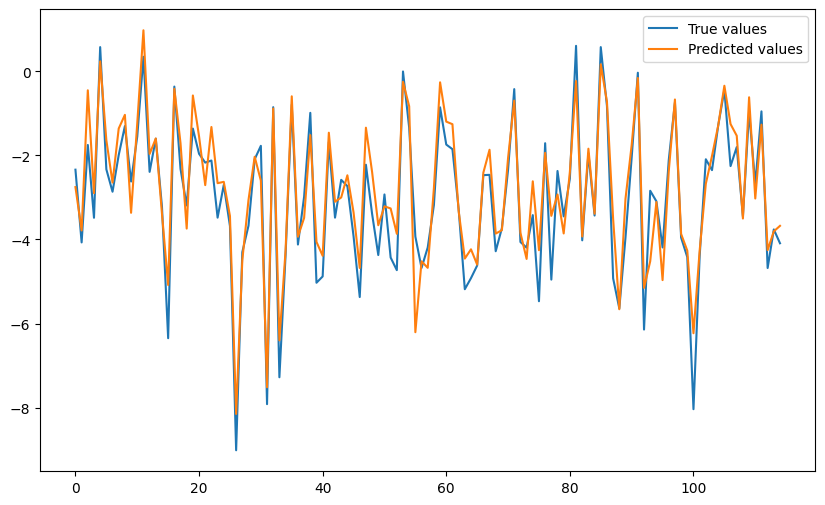

In [ ]:
# Visualization of Predicted values and real values.
import matplotlib.pyplot as plt

y = torch.Tensor([])
for x in test_loader:
  y = torch.cat([y, x.y.squeeze()], dim = 0)

y = y.numpy()
y_hat = predict(hi_gnn, test_loader)


plt.figure(figsize=(10,6))

# Plotting y
plt.plot(y, label='True values')

# Plotting yhat
plt.plot(y_hat, label='Predicted values')

plt.legend()
plt.show()

# Section - 4 - input_PBS_final

In [128]:
df = pd.read_csv("./chem_datasets/input_PBS_final.csv")
df.head()

,SMILES,Average logS PBS
0,[C@@H]1(CO)[C@@H](O)[C@@H](OCCOCCOCCOCCOCC#C)[...,-4.011887
1,[C@@H]1(CO)[C@@H](O)[C@@H](OS(=O)(=O)NC(COCCOC...,-4.032920
2,[C@@H]1(CO)[C@@H](OS(NC(COCCOCCOCCOCC#C)=O)(=O...,-3.962574
3,[C@@H]1(COCCOCCOCCOCCOCC#C)[C@@H](O)[C@@H](O)[...,-4.007889
4,[C@@H]1(COP(=O)(NCCOCCOCCOCCOCC#C)O)[C@@H](O)[...,-4.004365


In [105]:
df.describe()

,Average logS PBS
count,3719.000000
mean,-5.443525
std,1.347607
min,-9.924453
25%,-6.259637
50%,-5.204120
75%,-4.230992
max,-3.581699


In [129]:
df = df.sample(frac=1).reset_index(drop=True)
df.to_csv('./chem_datasets/input_PBS_final_random.csv', index= None)

In [130]:
df = pd.read_csv('./chem_datasets/input_PBS_final_random.csv')
df.head()

,SMILES,Average logS PBS
0,N1(C(C2=CC=CC(NC(NC3=NN=C(SCCN(C)C)S3)=O)=C2)=...,-4.081970
1,C1(F)=C(OCC2CCN2S(=O)(F)=O)C=CC(NC(=O)NC2=NN=C...,-5.416801
2,C1(N(C(C2=CC=C(Br)S2)=O)CCCN2CCOCC2)=NC2=C(S1)...,-5.588380
3,O=C1N(CCC2=CC3=C(NC(=O)N3)C=C2)C(CCN2C(=O)N3C=...,-5.193142
4,C12=C(C(=O)N(CCC3=CC=C(OC)C(OC)=C3)C(CCN3C(=O)...,-6.879426


In [10]:
# Prepapre the Data Loaders.
train_loader, valid_loader, test_loader = get_loaders(root = './root/',
                                                      fpath = "./chem_datasets/input_PBS_final_random.csv",
                                                      dataset = "input_PBS_final_random_iter_3",
                                                      task_type = 'regression',
                                                      tasks = ['Average logS PBS'],
                                                      smiles_col = 'SMILES'
                                                  )

Total smiles = 3,719 | train smiles = 2,975 | val smiles = 371 | test smiles = 373


/home/ec2-user/virtenv/lib64/python3.7/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/home/ec2-user/virtenv/lib64/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [13]:
#Get Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Build Model
hi_gnn = build_model()

In [15]:
# Train the model
train_regression(hi_gnn, train_loader, valid_loader, learning_rate = 1e-03, min_lr = 1e-04, epochs = 250, wd = 1e-03)

100%|██████████| 93/93 [00:03<00:00, 24.27it/s]


Epochs: 1 | Train Loss:  4.668             | Val Loss:  1.974             | Train RMSE:  1.977             | Val RMSE:  1.390


100%|██████████| 93/93 [00:02<00:00, 37.11it/s]


Epochs: 2 | Train Loss:  1.881             | Val Loss:  1.757             | Train RMSE:  1.354             | Val RMSE:  1.313


100%|██████████| 93/93 [00:02<00:00, 37.07it/s]


Epochs: 3 | Train Loss:  1.746             | Val Loss:  1.985             | Train RMSE:  1.307             | Val RMSE:  1.398


100%|██████████| 93/93 [00:02<00:00, 37.04it/s]


Epochs: 4 | Train Loss:  1.560             | Val Loss:  1.465             | Train RMSE:  1.236             | Val RMSE:  1.204


100%|██████████| 93/93 [00:02<00:00, 36.98it/s]


Epochs: 5 | Train Loss:  1.482             | Val Loss:  1.542             | Train RMSE:  1.205             | Val RMSE:  1.238


100%|██████████| 93/93 [00:02<00:00, 37.01it/s]


Epochs: 6 | Train Loss:  1.444             | Val Loss:  1.479             | Train RMSE:  1.186             | Val RMSE:  1.202


100%|██████████| 93/93 [00:02<00:00, 37.05it/s]


Epochs: 7 | Train Loss:  1.357             | Val Loss:  1.419             | Train RMSE:  1.151             | Val RMSE:  1.183


100%|██████████| 93/93 [00:02<00:00, 37.06it/s]


Epochs: 8 | Train Loss:  1.352             | Val Loss:  1.477             | Train RMSE:  1.152             | Val RMSE:  1.209


100%|██████████| 93/93 [00:02<00:00, 36.97it/s]


Epochs: 9 | Train Loss:  1.359             | Val Loss:  1.551             | Train RMSE:  1.157             | Val RMSE:  1.240


100%|██████████| 93/93 [00:02<00:00, 36.94it/s]


Epochs: 10 | Train Loss:  1.334             | Val Loss:  1.410             | Train RMSE:  1.142             | Val RMSE:  1.177


100%|██████████| 93/93 [00:02<00:00, 36.87it/s]


Epochs: 11 | Train Loss:  1.347             | Val Loss:  1.345             | Train RMSE:  1.143             | Val RMSE:  1.148


100%|██████████| 93/93 [00:02<00:00, 37.00it/s]


Epochs: 12 | Train Loss:  1.319             | Val Loss:  1.415             | Train RMSE:  1.138             | Val RMSE:  1.186


100%|██████████| 93/93 [00:02<00:00, 37.06it/s]


Epochs: 13 | Train Loss:  1.308             | Val Loss:  1.276             | Train RMSE:  1.130             | Val RMSE:  1.121


100%|██████████| 93/93 [00:02<00:00, 37.00it/s]


Epochs: 14 | Train Loss:  1.332             | Val Loss:  1.302             | Train RMSE:  1.142             | Val RMSE:  1.132


100%|██████████| 93/93 [00:02<00:00, 37.02it/s]


Epochs: 15 | Train Loss:  1.282             | Val Loss:  1.338             | Train RMSE:  1.121             | Val RMSE:  1.151


100%|██████████| 93/93 [00:02<00:00, 36.89it/s]


Epochs: 16 | Train Loss:  1.259             | Val Loss:  1.299             | Train RMSE:  1.110             | Val RMSE:  1.125


100%|██████████| 93/93 [00:02<00:00, 37.02it/s]


Epochs: 17 | Train Loss:  1.276             | Val Loss:  1.310             | Train RMSE:  1.121             | Val RMSE:  1.140


100%|██████████| 93/93 [00:02<00:00, 37.05it/s]


Epochs: 18 | Train Loss:  1.219             | Val Loss:  1.246             | Train RMSE:  1.090             | Val RMSE:  1.102


100%|██████████| 93/93 [00:02<00:00, 37.05it/s]


Epochs: 19 | Train Loss:  1.255             | Val Loss:  1.222             | Train RMSE:  1.107             | Val RMSE:  1.100


100%|██████████| 93/93 [00:02<00:00, 37.04it/s]


Epochs: 20 | Train Loss:  1.285             | Val Loss:  1.309             | Train RMSE:  1.124             | Val RMSE:  1.136


100%|██████████| 93/93 [00:02<00:00, 36.99it/s]


Epochs: 21 | Train Loss:  1.257             | Val Loss:  1.244             | Train RMSE:  1.107             | Val RMSE:  1.106


100%|██████████| 93/93 [00:02<00:00, 37.03it/s]


Epochs: 22 | Train Loss:  1.221             | Val Loss:  1.293             | Train RMSE:  1.089             | Val RMSE:  1.127


100%|██████████| 93/93 [00:02<00:00, 36.97it/s]


Epochs: 23 | Train Loss:  1.199             | Val Loss:  1.273             | Train RMSE:  1.084             | Val RMSE:  1.115


100%|██████████| 93/93 [00:02<00:00, 36.84it/s]


Epochs: 24 | Train Loss:  1.199             | Val Loss:  1.253             | Train RMSE:  1.085             | Val RMSE:  1.110


100%|██████████| 93/93 [00:02<00:00, 36.81it/s]


Epochs: 25 | Train Loss:  1.186             | Val Loss:  1.231             | Train RMSE:  1.077             | Val RMSE:  1.102


100%|██████████| 93/93 [00:02<00:00, 36.83it/s]


Epochs: 26 | Train Loss:  1.225             | Val Loss:  1.194             | Train RMSE:  1.095             | Val RMSE:  1.088


100%|██████████| 93/93 [00:02<00:00, 36.81it/s]


Epochs: 27 | Train Loss:  1.212             | Val Loss:  1.222             | Train RMSE:  1.089             | Val RMSE:  1.096


100%|██████████| 93/93 [00:02<00:00, 36.93it/s]


Epochs: 28 | Train Loss:  1.177             | Val Loss:  1.307             | Train RMSE:  1.074             | Val RMSE:  1.132


100%|██████████| 93/93 [00:02<00:00, 36.94it/s]


Epochs: 29 | Train Loss:  1.148             | Val Loss:  1.199             | Train RMSE:  1.061             | Val RMSE:  1.082


100%|██████████| 93/93 [00:02<00:00, 37.00it/s]


Epochs: 30 | Train Loss:  1.163             | Val Loss:  1.268             | Train RMSE:  1.066             | Val RMSE:  1.118


100%|██████████| 93/93 [00:02<00:00, 37.02it/s]


Epochs: 31 | Train Loss:  1.147             | Val Loss:  1.139             | Train RMSE:  1.058             | Val RMSE:  1.056


100%|██████████| 93/93 [00:02<00:00, 37.04it/s]


Epochs: 32 | Train Loss:  1.153             | Val Loss:  1.302             | Train RMSE:  1.064             | Val RMSE:  1.132


100%|██████████| 93/93 [00:02<00:00, 36.88it/s]


Epochs: 33 | Train Loss:  1.151             | Val Loss:  1.134             | Train RMSE:  1.060             | Val RMSE:  1.058


100%|██████████| 93/93 [00:02<00:00, 36.79it/s]


Epochs: 34 | Train Loss:  1.142             | Val Loss:  1.233             | Train RMSE:  1.058             | Val RMSE:  1.095


100%|██████████| 93/93 [00:02<00:00, 37.00it/s]


Epochs: 35 | Train Loss:  1.153             | Val Loss:  1.237             | Train RMSE:  1.061             | Val RMSE:  1.103


100%|██████████| 93/93 [00:02<00:00, 36.98it/s]


Epochs: 36 | Train Loss:  1.134             | Val Loss:  1.172             | Train RMSE:  1.053             | Val RMSE:  1.069


100%|██████████| 93/93 [00:02<00:00, 36.97it/s]


Epochs: 37 | Train Loss:  1.163             | Val Loss:  1.146             | Train RMSE:  1.065             | Val RMSE:  1.064


100%|██████████| 93/93 [00:02<00:00, 37.00it/s]


Epochs: 38 | Train Loss:  1.137             | Val Loss:  1.195             | Train RMSE:  1.051             | Val RMSE:  1.088


100%|██████████| 93/93 [00:02<00:00, 36.97it/s]


Epochs: 39 | Train Loss:  1.135             | Val Loss:  1.142             | Train RMSE:  1.056             | Val RMSE:  1.060


100%|██████████| 93/93 [00:02<00:00, 36.99it/s]


Epochs: 40 | Train Loss:  1.113             | Val Loss:  1.191             | Train RMSE:  1.042             | Val RMSE:  1.084


100%|██████████| 93/93 [00:02<00:00, 36.95it/s]


Epochs: 41 | Train Loss:  1.130             | Val Loss:  1.286             | Train RMSE:  1.049             | Val RMSE:  1.125


100%|██████████| 93/93 [00:02<00:00, 36.88it/s]


Epochs: 42 | Train Loss:  1.086             | Val Loss:  1.274             | Train RMSE:  1.027             | Val RMSE:  1.117


100%|██████████| 93/93 [00:02<00:00, 36.94it/s]


Epochs: 43 | Train Loss:  1.124             | Val Loss:  1.192             | Train RMSE:  1.048             | Val RMSE:  1.084


100%|██████████| 93/93 [00:02<00:00, 37.08it/s]


Epochs: 44 | Train Loss:  1.085             | Val Loss:  1.228             | Train RMSE:  1.028             | Val RMSE:  1.098


100%|██████████| 93/93 [00:02<00:00, 37.12it/s]


Epochs: 45 | Train Loss:  1.101             | Val Loss:  1.153             | Train RMSE:  1.038             | Val RMSE:  1.066


100%|██████████| 93/93 [00:02<00:00, 37.03it/s]


Epochs: 46 | Train Loss:  1.102             | Val Loss:  1.172             | Train RMSE:  1.035             | Val RMSE:  1.067


100%|██████████| 93/93 [00:02<00:00, 36.97it/s]


Epochs: 47 | Train Loss:  1.074             | Val Loss:  1.082             | Train RMSE:  1.021             | Val RMSE:  1.031


100%|██████████| 93/93 [00:02<00:00, 36.89it/s]


Epochs: 48 | Train Loss:  1.130             | Val Loss:  1.157             | Train RMSE:  1.050             | Val RMSE:  1.062


100%|██████████| 93/93 [00:02<00:00, 36.79it/s]


Epochs: 49 | Train Loss:  1.081             | Val Loss:  1.110             | Train RMSE:  1.027             | Val RMSE:  1.043


100%|██████████| 93/93 [00:02<00:00, 36.79it/s]


Epochs: 50 | Train Loss:  1.073             | Val Loss:  1.009             | Train RMSE:  1.025             | Val RMSE:  0.998


100%|██████████| 93/93 [00:02<00:00, 36.83it/s]


Epochs: 51 | Train Loss:  1.076             | Val Loss:  1.131             | Train RMSE:  1.023             | Val RMSE:  1.057


100%|██████████| 93/93 [00:02<00:00, 36.87it/s]


Epochs: 52 | Train Loss:  1.046             | Val Loss:  1.242             | Train RMSE:  1.010             | Val RMSE:  1.097


100%|██████████| 93/93 [00:02<00:00, 36.68it/s]


Epochs: 53 | Train Loss:  1.080             | Val Loss:  1.026             | Train RMSE:  1.026             | Val RMSE:  1.002


100%|██████████| 93/93 [00:02<00:00, 36.69it/s]


Epochs: 54 | Train Loss:  1.067             | Val Loss:  1.014             | Train RMSE:  1.020             | Val RMSE:  0.997


100%|██████████| 93/93 [00:02<00:00, 36.98it/s]


Epochs: 55 | Train Loss:  1.062             | Val Loss:  1.053             | Train RMSE:  1.018             | Val RMSE:  1.018


100%|██████████| 93/93 [00:02<00:00, 36.88it/s]


Epochs: 56 | Train Loss:  1.055             | Val Loss:  1.062             | Train RMSE:  1.014             | Val RMSE:  1.023


100%|██████████| 93/93 [00:02<00:00, 36.76it/s]


Epochs: 57 | Train Loss:  1.071             | Val Loss:  1.042             | Train RMSE:  1.022             | Val RMSE:  1.016


100%|██████████| 93/93 [00:02<00:00, 36.90it/s]


Epochs: 58 | Train Loss:  1.039             | Val Loss:  1.115             | Train RMSE:  1.007             | Val RMSE:  1.044


100%|██████████| 93/93 [00:02<00:00, 36.86it/s]


Epochs: 59 | Train Loss:  1.015             | Val Loss:  1.227             | Train RMSE:  0.996             | Val RMSE:  1.096


100%|██████████| 93/93 [00:02<00:00, 37.07it/s]


Epochs: 60 | Train Loss:  1.029             | Val Loss:  1.046             | Train RMSE:  1.004             | Val RMSE:  1.014


100%|██████████| 93/93 [00:02<00:00, 37.02it/s]


Epochs: 61 | Train Loss:  1.036             | Val Loss:  1.092             | Train RMSE:  1.007             | Val RMSE:  1.036


100%|██████████| 93/93 [00:02<00:00, 37.08it/s]


Epochs: 62 | Train Loss:  1.022             | Val Loss:  1.084             | Train RMSE:  1.000             | Val RMSE:  1.030


100%|██████████| 93/93 [00:02<00:00, 37.11it/s]


Epochs: 63 | Train Loss:  1.028             | Val Loss:  0.995             | Train RMSE:  1.001             | Val RMSE:  0.989


100%|██████████| 93/93 [00:02<00:00, 37.11it/s]


Epochs: 64 | Train Loss:  1.040             | Val Loss:  1.142             | Train RMSE:  1.006             | Val RMSE:  1.057


100%|██████████| 93/93 [00:02<00:00, 37.08it/s]


Epochs: 65 | Train Loss:  1.030             | Val Loss:  1.113             | Train RMSE:  1.003             | Val RMSE:  1.040


100%|██████████| 93/93 [00:02<00:00, 37.02it/s]


Epochs: 66 | Train Loss:  1.028             | Val Loss:  1.137             | Train RMSE:  1.003             | Val RMSE:  1.055


100%|██████████| 93/93 [00:02<00:00, 36.94it/s]


Epochs: 67 | Train Loss:  1.033             | Val Loss:  1.032             | Train RMSE:  1.004             | Val RMSE:  1.008


100%|██████████| 93/93 [00:02<00:00, 37.03it/s]


Epochs: 68 | Train Loss:  0.978             | Val Loss:  1.043             | Train RMSE:  0.977             | Val RMSE:  1.006


100%|██████████| 93/93 [00:02<00:00, 37.01it/s]


Epochs: 69 | Train Loss:  0.993             | Val Loss:  1.123             | Train RMSE:  0.985             | Val RMSE:  1.052


100%|██████████| 93/93 [00:02<00:00, 36.99it/s]


Epochs: 70 | Train Loss:  1.030             | Val Loss:  1.144             | Train RMSE:  1.002             | Val RMSE:  1.060


100%|██████████| 93/93 [00:02<00:00, 37.04it/s]


Epochs: 71 | Train Loss:  1.012             | Val Loss:  1.013             | Train RMSE:  0.995             | Val RMSE:  0.991


100%|██████████| 93/93 [00:02<00:00, 36.95it/s]


Epochs: 72 | Train Loss:  1.005             | Val Loss:  1.069             | Train RMSE:  0.989             | Val RMSE:  1.021


100%|██████████| 93/93 [00:02<00:00, 36.90it/s]


Epochs: 73 | Train Loss:  0.967             | Val Loss:  0.965             | Train RMSE:  0.970             | Val RMSE:  0.975


100%|██████████| 93/93 [00:02<00:00, 36.89it/s]


Epochs: 74 | Train Loss:  0.988             | Val Loss:  0.983             | Train RMSE:  0.985             | Val RMSE:  0.980


100%|██████████| 93/93 [00:02<00:00, 36.96it/s]


Epochs: 75 | Train Loss:  1.006             | Val Loss:  0.958             | Train RMSE:  0.993             | Val RMSE:  0.971


100%|██████████| 93/93 [00:02<00:00, 36.96it/s]


Epochs: 76 | Train Loss:  1.024             | Val Loss:  1.117             | Train RMSE:  1.002             | Val RMSE:  1.049


100%|██████████| 93/93 [00:02<00:00, 36.99it/s]


Epochs: 77 | Train Loss:  1.007             | Val Loss:  1.010             | Train RMSE:  0.993             | Val RMSE:  0.997


100%|██████████| 93/93 [00:02<00:00, 36.96it/s]


Epochs: 78 | Train Loss:  1.021             | Val Loss:  1.076             | Train RMSE:  0.998             | Val RMSE:  1.029


100%|██████████| 93/93 [00:02<00:00, 36.88it/s]


Epochs: 79 | Train Loss:  0.981             | Val Loss:  1.117             | Train RMSE:  0.981             | Val RMSE:  1.046


100%|██████████| 93/93 [00:02<00:00, 36.95it/s]


Epochs: 80 | Train Loss:  0.990             | Val Loss:  0.941             | Train RMSE:  0.984             | Val RMSE:  0.961


100%|██████████| 93/93 [00:02<00:00, 37.00it/s]


Epochs: 81 | Train Loss:  0.954             | Val Loss:  1.055             | Train RMSE:  0.965             | Val RMSE:  1.018


100%|██████████| 93/93 [00:02<00:00, 37.01it/s]


Epochs: 82 | Train Loss:  0.949             | Val Loss:  1.042             | Train RMSE:  0.964             | Val RMSE:  1.015


100%|██████████| 93/93 [00:02<00:00, 37.02it/s]


Epochs: 83 | Train Loss:  0.975             | Val Loss:  1.046             | Train RMSE:  0.976             | Val RMSE:  1.018


100%|██████████| 93/93 [00:02<00:00, 37.04it/s]


Epochs: 84 | Train Loss:  0.949             | Val Loss:  1.039             | Train RMSE:  0.965             | Val RMSE:  1.012


100%|██████████| 93/93 [00:02<00:00, 37.05it/s]


Epochs: 85 | Train Loss:  0.992             | Val Loss:  1.052             | Train RMSE:  0.985             | Val RMSE:  1.019


100%|██████████| 93/93 [00:02<00:00, 36.95it/s]


Epochs: 86 | Train Loss:  0.975             | Val Loss:  0.924             | Train RMSE:  0.974             | Val RMSE:  0.951


100%|██████████| 93/93 [00:02<00:00, 36.93it/s]


Epochs: 87 | Train Loss:  0.966             | Val Loss:  1.099             | Train RMSE:  0.971             | Val RMSE:  1.039


100%|██████████| 93/93 [00:02<00:00, 37.02it/s]


Epochs: 88 | Train Loss:  0.949             | Val Loss:  1.133             | Train RMSE:  0.960             | Val RMSE:  1.052


100%|██████████| 93/93 [00:02<00:00, 36.97it/s]


Epochs: 89 | Train Loss:  0.952             | Val Loss:  1.084             | Train RMSE:  0.963             | Val RMSE:  1.025


100%|██████████| 93/93 [00:02<00:00, 36.97it/s]


Epochs: 90 | Train Loss:  0.960             | Val Loss:  1.070             | Train RMSE:  0.966             | Val RMSE:  1.027


100%|██████████| 93/93 [00:02<00:00, 36.85it/s]


Epochs: 91 | Train Loss:  0.977             | Val Loss:  0.917             | Train RMSE:  0.979             | Val RMSE:  0.953


100%|██████████| 93/93 [00:02<00:00, 36.86it/s]


Epochs: 92 | Train Loss:  0.978             | Val Loss:  1.038             | Train RMSE:  0.976             | Val RMSE:  1.007


100%|██████████| 93/93 [00:02<00:00, 36.94it/s]


Epochs: 93 | Train Loss:  0.968             | Val Loss:  0.988             | Train RMSE:  0.973             | Val RMSE:  0.987


100%|██████████| 93/93 [00:02<00:00, 37.03it/s]


Epochs: 94 | Train Loss:  0.913             | Val Loss:  1.016             | Train RMSE:  0.944             | Val RMSE:  0.997


100%|██████████| 93/93 [00:02<00:00, 37.08it/s]


Epochs: 95 | Train Loss:  0.938             | Val Loss:  1.068             | Train RMSE:  0.955             | Val RMSE:  1.027


100%|██████████| 93/93 [00:02<00:00, 37.22it/s]


Epochs: 96 | Train Loss:  0.934             | Val Loss:  1.003             | Train RMSE:  0.953             | Val RMSE:  0.994


100%|██████████| 93/93 [00:02<00:00, 37.05it/s]


Epochs: 97 | Train Loss:  0.977             | Val Loss:  0.953             | Train RMSE:  0.975             | Val RMSE:  0.968


100%|██████████| 93/93 [00:02<00:00, 37.13it/s]


Epochs: 98 | Train Loss:  0.932             | Val Loss:  1.077             | Train RMSE:  0.952             | Val RMSE:  1.028


100%|██████████| 93/93 [00:02<00:00, 36.83it/s]


Epochs: 99 | Train Loss:  0.933             | Val Loss:  1.050             | Train RMSE:  0.954             | Val RMSE:  1.015


100%|██████████| 93/93 [00:02<00:00, 36.66it/s]


Epochs: 100 | Train Loss:  0.951             | Val Loss:  1.046             | Train RMSE:  0.964             | Val RMSE:  1.012


100%|██████████| 93/93 [00:02<00:00, 37.00it/s]


Epochs: 101 | Train Loss:  0.946             | Val Loss:  0.969             | Train RMSE:  0.959             | Val RMSE:  0.976


100%|██████████| 93/93 [00:02<00:00, 36.97it/s]


Epochs: 102 | Train Loss:  0.932             | Val Loss:  1.050             | Train RMSE:  0.954             | Val RMSE:  1.012


100%|██████████| 93/93 [00:02<00:00, 37.00it/s]


Epochs: 103 | Train Loss:  0.917             | Val Loss:  0.906             | Train RMSE:  0.947             | Val RMSE:  0.948


100%|██████████| 93/93 [00:02<00:00, 36.89it/s]


Epochs: 104 | Train Loss:  0.928             | Val Loss:  0.951             | Train RMSE:  0.951             | Val RMSE:  0.966


100%|██████████| 93/93 [00:02<00:00, 36.91it/s]


Epochs: 105 | Train Loss:  0.946             | Val Loss:  0.943             | Train RMSE:  0.962             | Val RMSE:  0.960


100%|██████████| 93/93 [00:02<00:00, 36.88it/s]


Epochs: 106 | Train Loss:  0.908             | Val Loss:  0.994             | Train RMSE:  0.939             | Val RMSE:  0.986


100%|██████████| 93/93 [00:02<00:00, 37.04it/s]


Epochs: 107 | Train Loss:  0.905             | Val Loss:  0.934             | Train RMSE:  0.938             | Val RMSE:  0.958


100%|██████████| 93/93 [00:02<00:00, 37.04it/s]


Epochs: 108 | Train Loss:  0.916             | Val Loss:  0.902             | Train RMSE:  0.945             | Val RMSE:  0.943


100%|██████████| 93/93 [00:02<00:00, 37.02it/s]


Epochs: 109 | Train Loss:  0.901             | Val Loss:  0.976             | Train RMSE:  0.939             | Val RMSE:  0.978


100%|██████████| 93/93 [00:02<00:00, 37.08it/s]


Epochs: 110 | Train Loss:  0.897             | Val Loss:  0.964             | Train RMSE:  0.938             | Val RMSE:  0.967


100%|██████████| 93/93 [00:02<00:00, 36.99it/s]


Epochs: 111 | Train Loss:  0.907             | Val Loss:  0.873             | Train RMSE:  0.943             | Val RMSE:  0.929


100%|██████████| 93/93 [00:02<00:00, 36.76it/s]


Epochs: 112 | Train Loss:  0.909             | Val Loss:  0.953             | Train RMSE:  0.939             | Val RMSE:  0.969


100%|██████████| 93/93 [00:02<00:00, 36.98it/s]


Epochs: 113 | Train Loss:  0.889             | Val Loss:  0.982             | Train RMSE:  0.928             | Val RMSE:  0.983


100%|██████████| 93/93 [00:02<00:00, 37.00it/s]


Epochs: 114 | Train Loss:  0.866             | Val Loss:  0.917             | Train RMSE:  0.920             | Val RMSE:  0.947


100%|██████████| 93/93 [00:02<00:00, 37.00it/s]


Epochs: 115 | Train Loss:  0.893             | Val Loss:  1.013             | Train RMSE:  0.931             | Val RMSE:  1.003


100%|██████████| 93/93 [00:02<00:00, 37.00it/s]


Epochs: 116 | Train Loss:  0.935             | Val Loss:  0.854             | Train RMSE:  0.957             | Val RMSE:  0.917


100%|██████████| 93/93 [00:02<00:00, 36.91it/s]


Epochs: 117 | Train Loss:  0.878             | Val Loss:  0.967             | Train RMSE:  0.925             | Val RMSE:  0.977


100%|██████████| 93/93 [00:02<00:00, 36.95it/s]


Epochs: 118 | Train Loss:  0.909             | Val Loss:  0.939             | Train RMSE:  0.941             | Val RMSE:  0.963


100%|██████████| 93/93 [00:02<00:00, 37.03it/s]


Epochs: 119 | Train Loss:  0.874             | Val Loss:  0.959             | Train RMSE:  0.922             | Val RMSE:  0.970


100%|██████████| 93/93 [00:02<00:00, 36.96it/s]


Epochs: 120 | Train Loss:  0.882             | Val Loss:  0.954             | Train RMSE:  0.926             | Val RMSE:  0.966


100%|██████████| 93/93 [00:02<00:00, 36.90it/s]


Epochs: 121 | Train Loss:  0.893             | Val Loss:  0.933             | Train RMSE:  0.933             | Val RMSE:  0.960


100%|██████████| 93/93 [00:02<00:00, 36.92it/s]


Epochs: 122 | Train Loss:  0.868             | Val Loss:  0.934             | Train RMSE:  0.916             | Val RMSE:  0.956


100%|██████████| 93/93 [00:02<00:00, 36.78it/s]


Epochs: 123 | Train Loss:  0.865             | Val Loss:  0.929             | Train RMSE:  0.919             | Val RMSE:  0.955


100%|██████████| 93/93 [00:02<00:00, 36.87it/s]


Epochs: 124 | Train Loss:  0.857             | Val Loss:  0.963             | Train RMSE:  0.915             | Val RMSE:  0.977


100%|██████████| 93/93 [00:02<00:00, 36.99it/s]


Epochs: 125 | Train Loss:  0.881             | Val Loss:  0.945             | Train RMSE:  0.926             | Val RMSE:  0.962


100%|██████████| 93/93 [00:02<00:00, 36.99it/s]


Epochs: 126 | Train Loss:  0.863             | Val Loss:  0.932             | Train RMSE:  0.916             | Val RMSE:  0.960


100%|██████████| 93/93 [00:02<00:00, 37.10it/s]


Epochs: 127 | Train Loss:  0.908             | Val Loss:  0.918             | Train RMSE:  0.942             | Val RMSE:  0.946


100%|██████████| 93/93 [00:02<00:00, 37.09it/s]


Epochs: 128 | Train Loss:  0.867             | Val Loss:  0.922             | Train RMSE:  0.919             | Val RMSE:  0.953


100%|██████████| 93/93 [00:02<00:00, 37.07it/s]


Epochs: 129 | Train Loss:  0.877             | Val Loss:  0.835             | Train RMSE:  0.926             | Val RMSE:  0.907


100%|██████████| 93/93 [00:02<00:00, 37.11it/s]


Epochs: 130 | Train Loss:  0.855             | Val Loss:  0.894             | Train RMSE:  0.912             | Val RMSE:  0.938


100%|██████████| 93/93 [00:02<00:00, 37.12it/s]


Epochs: 131 | Train Loss:  0.902             | Val Loss:  0.892             | Train RMSE:  0.938             | Val RMSE:  0.937


100%|██████████| 93/93 [00:02<00:00, 37.09it/s]


Epochs: 132 | Train Loss:  0.891             | Val Loss:  0.911             | Train RMSE:  0.931             | Val RMSE:  0.946


100%|██████████| 93/93 [00:02<00:00, 37.04it/s]


Epochs: 133 | Train Loss:  0.839             | Val Loss:  0.919             | Train RMSE:  0.903             | Val RMSE:  0.948


100%|██████████| 93/93 [00:02<00:00, 36.98it/s]


Epochs: 134 | Train Loss:  0.840             | Val Loss:  0.864             | Train RMSE:  0.901             | Val RMSE:  0.918


100%|██████████| 93/93 [00:02<00:00, 37.08it/s]


Epochs: 135 | Train Loss:  0.873             | Val Loss:  0.912             | Train RMSE:  0.920             | Val RMSE:  0.943


100%|██████████| 93/93 [00:02<00:00, 37.11it/s]


Epochs: 136 | Train Loss:  0.857             | Val Loss:  0.839             | Train RMSE:  0.914             | Val RMSE:  0.906


100%|██████████| 93/93 [00:02<00:00, 37.08it/s]


Epochs: 137 | Train Loss:  0.886             | Val Loss:  0.930             | Train RMSE:  0.927             | Val RMSE:  0.958


100%|██████████| 93/93 [00:02<00:00, 37.15it/s]


Epochs: 138 | Train Loss:  0.863             | Val Loss:  0.837             | Train RMSE:  0.920             | Val RMSE:  0.908


100%|██████████| 93/93 [00:02<00:00, 37.19it/s]


Epochs: 139 | Train Loss:  0.848             | Val Loss:  0.873             | Train RMSE:  0.912             | Val RMSE:  0.922


100%|██████████| 93/93 [00:02<00:00, 37.09it/s]


Epochs: 140 | Train Loss:  0.861             | Val Loss:  0.983             | Train RMSE:  0.915             | Val RMSE:  0.985


100%|██████████| 93/93 [00:02<00:00, 37.07it/s]


Epochs: 141 | Train Loss:  0.844             | Val Loss:  0.994             | Train RMSE:  0.910             | Val RMSE:  0.991


100%|██████████| 93/93 [00:02<00:00, 37.15it/s]


Epochs: 142 | Train Loss:  0.828             | Val Loss:  0.917             | Train RMSE:  0.897             | Val RMSE:  0.950


100%|██████████| 93/93 [00:02<00:00, 37.08it/s]


Epochs: 143 | Train Loss:  0.829             | Val Loss:  0.926             | Train RMSE:  0.897             | Val RMSE:  0.952


100%|██████████| 93/93 [00:02<00:00, 37.17it/s]


Epochs: 144 | Train Loss:  0.884             | Val Loss:  0.834             | Train RMSE:  0.924             | Val RMSE:  0.904


100%|██████████| 93/93 [00:02<00:00, 37.11it/s]


Epochs: 145 | Train Loss:  0.826             | Val Loss:  0.988             | Train RMSE:  0.899             | Val RMSE:  0.986


100%|██████████| 93/93 [00:02<00:00, 37.10it/s]


Epochs: 146 | Train Loss:  0.853             | Val Loss:  0.867             | Train RMSE:  0.912             | Val RMSE:  0.915


100%|██████████| 93/93 [00:02<00:00, 37.07it/s]


Epochs: 147 | Train Loss:  0.847             | Val Loss:  0.849             | Train RMSE:  0.908             | Val RMSE:  0.916


100%|██████████| 93/93 [00:02<00:00, 37.08it/s]


Epochs: 148 | Train Loss:  0.833             | Val Loss:  0.844             | Train RMSE:  0.903             | Val RMSE:  0.913


100%|██████████| 93/93 [00:02<00:00, 37.09it/s]


Epochs: 149 | Train Loss:  0.827             | Val Loss:  0.900             | Train RMSE:  0.897             | Val RMSE:  0.942


100%|██████████| 93/93 [00:02<00:00, 37.08it/s]


Epochs: 150 | Train Loss:  0.844             | Val Loss:  0.897             | Train RMSE:  0.907             | Val RMSE:  0.937


100%|██████████| 93/93 [00:02<00:00, 36.91it/s]


Epochs: 151 | Train Loss:  0.855             | Val Loss:  0.952             | Train RMSE:  0.914             | Val RMSE:  0.966


100%|██████████| 93/93 [00:02<00:00, 37.01it/s]


Epochs: 152 | Train Loss:  0.868             | Val Loss:  0.887             | Train RMSE:  0.919             | Val RMSE:  0.935


100%|██████████| 93/93 [00:02<00:00, 37.03it/s]


Epochs: 153 | Train Loss:  0.840             | Val Loss:  0.965             | Train RMSE:  0.906             | Val RMSE:  0.973


100%|██████████| 93/93 [00:02<00:00, 36.98it/s]


Epochs: 154 | Train Loss:  0.842             | Val Loss:  0.840             | Train RMSE:  0.908             | Val RMSE:  0.909


100%|██████████| 93/93 [00:02<00:00, 37.01it/s]


Epochs: 155 | Train Loss:  0.843             | Val Loss:  0.945             | Train RMSE:  0.907             | Val RMSE:  0.959


100%|██████████| 93/93 [00:02<00:00, 37.03it/s]


Epochs: 156 | Train Loss:  0.863             | Val Loss:  0.836             | Train RMSE:  0.917             | Val RMSE:  0.906


100%|██████████| 93/93 [00:02<00:00, 37.08it/s]


Epochs: 157 | Train Loss:  0.833             | Val Loss:  0.902             | Train RMSE:  0.901             | Val RMSE:  0.943


100%|██████████| 93/93 [00:02<00:00, 37.07it/s]


Epochs: 158 | Train Loss:  0.856             | Val Loss:  0.908             | Train RMSE:  0.913             | Val RMSE:  0.940


100%|██████████| 93/93 [00:02<00:00, 37.11it/s]


Epochs: 159 | Train Loss:  0.844             | Val Loss:  0.887             | Train RMSE:  0.908             | Val RMSE:  0.934


100%|██████████| 93/93 [00:02<00:00, 37.08it/s]


Epochs: 160 | Train Loss:  0.817             | Val Loss:  0.867             | Train RMSE:  0.893             | Val RMSE:  0.927


100%|██████████| 93/93 [00:02<00:00, 37.12it/s]


Epochs: 161 | Train Loss:  0.832             | Val Loss:  0.939             | Train RMSE:  0.899             | Val RMSE:  0.961


100%|██████████| 93/93 [00:02<00:00, 37.09it/s]


Epochs: 162 | Train Loss:  0.814             | Val Loss:  0.839             | Train RMSE:  0.892             | Val RMSE:  0.911


100%|██████████| 93/93 [00:02<00:00, 36.95it/s]


Epochs: 163 | Train Loss:  0.829             | Val Loss:  0.812             | Train RMSE:  0.897             | Val RMSE:  0.894


100%|██████████| 93/93 [00:02<00:00, 37.00it/s]


Epochs: 164 | Train Loss:  0.811             | Val Loss:  0.847             | Train RMSE:  0.890             | Val RMSE:  0.913


100%|██████████| 93/93 [00:02<00:00, 37.01it/s]


Epochs: 165 | Train Loss:  0.836             | Val Loss:  0.948             | Train RMSE:  0.906             | Val RMSE:  0.966


100%|██████████| 93/93 [00:02<00:00, 37.08it/s]


Epochs: 166 | Train Loss:  0.791             | Val Loss:  0.867             | Train RMSE:  0.877             | Val RMSE:  0.921


100%|██████████| 93/93 [00:02<00:00, 36.96it/s]


Epochs: 167 | Train Loss:  0.826             | Val Loss:  0.959             | Train RMSE:  0.894             | Val RMSE:  0.963


100%|██████████| 93/93 [00:02<00:00, 36.83it/s]


Epochs: 168 | Train Loss:  0.810             | Val Loss:  0.906             | Train RMSE:  0.887             | Val RMSE:  0.941


100%|██████████| 93/93 [00:02<00:00, 36.88it/s]


Epochs: 169 | Train Loss:  0.819             | Val Loss:  0.857             | Train RMSE:  0.897             | Val RMSE:  0.918


100%|██████████| 93/93 [00:02<00:00, 36.86it/s]


Epochs: 170 | Train Loss:  0.787             | Val Loss:  0.998             | Train RMSE:  0.877             | Val RMSE:  0.987


100%|██████████| 93/93 [00:02<00:00, 36.88it/s]


Epochs: 171 | Train Loss:  0.800             | Val Loss:  0.871             | Train RMSE:  0.883             | Val RMSE:  0.920


100%|██████████| 93/93 [00:02<00:00, 37.02it/s]


Epochs: 172 | Train Loss:  0.834             | Val Loss:  0.943             | Train RMSE:  0.902             | Val RMSE:  0.961


100%|██████████| 93/93 [00:02<00:00, 36.98it/s]


Epochs: 173 | Train Loss:  0.793             | Val Loss:  0.900             | Train RMSE:  0.879             | Val RMSE:  0.939


100%|██████████| 93/93 [00:02<00:00, 36.98it/s]


Epochs: 174 | Train Loss:  0.831             | Val Loss:  0.883             | Train RMSE:  0.900             | Val RMSE:  0.928


100%|██████████| 93/93 [00:02<00:00, 37.05it/s]


Epochs: 175 | Train Loss:  0.807             | Val Loss:  0.916             | Train RMSE:  0.890             | Val RMSE:  0.948


100%|██████████| 93/93 [00:02<00:00, 37.05it/s]


Epochs: 176 | Train Loss:  0.811             | Val Loss:  0.891             | Train RMSE:  0.889             | Val RMSE:  0.937


100%|██████████| 93/93 [00:02<00:00, 37.02it/s]


Epochs: 177 | Train Loss:  0.807             | Val Loss:  0.814             | Train RMSE:  0.887             | Val RMSE:  0.894


100%|██████████| 93/93 [00:02<00:00, 37.06it/s]


Epochs: 178 | Train Loss:  0.800             | Val Loss:  0.929             | Train RMSE:  0.885             | Val RMSE:  0.952


100%|██████████| 93/93 [00:02<00:00, 37.01it/s]


Epochs: 179 | Train Loss:  0.802             | Val Loss:  0.848             | Train RMSE:  0.884             | Val RMSE:  0.915


100%|██████████| 93/93 [00:02<00:00, 37.03it/s]


Epochs: 180 | Train Loss:  0.782             | Val Loss:  0.941             | Train RMSE:  0.871             | Val RMSE:  0.965


100%|██████████| 93/93 [00:02<00:00, 36.96it/s]


Epochs: 181 | Train Loss:  0.814             | Val Loss:  0.807             | Train RMSE:  0.891             | Val RMSE:  0.893


100%|██████████| 93/93 [00:02<00:00, 36.76it/s]


Epochs: 182 | Train Loss:  0.793             | Val Loss:  0.828             | Train RMSE:  0.879             | Val RMSE:  0.897


100%|██████████| 93/93 [00:02<00:00, 36.95it/s]


Epochs: 183 | Train Loss:  0.846             | Val Loss:  0.842             | Train RMSE:  0.908             | Val RMSE:  0.906


100%|██████████| 93/93 [00:02<00:00, 36.92it/s]


Epochs: 184 | Train Loss:  0.794             | Val Loss:  0.835             | Train RMSE:  0.879             | Val RMSE:  0.899


100%|██████████| 93/93 [00:02<00:00, 36.86it/s]


Epochs: 185 | Train Loss:  0.811             | Val Loss:  0.836             | Train RMSE:  0.890             | Val RMSE:  0.910


100%|██████████| 93/93 [00:02<00:00, 36.90it/s]


Epochs: 186 | Train Loss:  0.820             | Val Loss:  0.898             | Train RMSE:  0.893             | Val RMSE:  0.938


100%|██████████| 93/93 [00:02<00:00, 36.88it/s]


Epochs: 187 | Train Loss:  0.814             | Val Loss:  0.913             | Train RMSE:  0.890             | Val RMSE:  0.947


100%|██████████| 93/93 [00:02<00:00, 36.79it/s]


Epochs: 188 | Train Loss:  0.787             | Val Loss:  0.841             | Train RMSE:  0.876             | Val RMSE:  0.908


100%|██████████| 93/93 [00:02<00:00, 36.88it/s]


Epochs: 189 | Train Loss:  0.830             | Val Loss:  0.888             | Train RMSE:  0.903             | Val RMSE:  0.934


100%|██████████| 93/93 [00:02<00:00, 36.83it/s]


Epochs: 190 | Train Loss:  0.786             | Val Loss:  0.797             | Train RMSE:  0.877             | Val RMSE:  0.888


100%|██████████| 93/93 [00:02<00:00, 36.86it/s]


Epochs: 191 | Train Loss:  0.794             | Val Loss:  0.867             | Train RMSE:  0.880             | Val RMSE:  0.916


100%|██████████| 93/93 [00:02<00:00, 36.97it/s]


Epochs: 192 | Train Loss:  0.789             | Val Loss:  0.800             | Train RMSE:  0.880             | Val RMSE:  0.888


100%|██████████| 93/93 [00:02<00:00, 36.94it/s]


Epochs: 193 | Train Loss:  0.760             | Val Loss:  0.860             | Train RMSE:  0.861             | Val RMSE:  0.916


100%|██████████| 93/93 [00:02<00:00, 36.98it/s]


Epochs: 194 | Train Loss:  0.772             | Val Loss:  0.865             | Train RMSE:  0.869             | Val RMSE:  0.922


100%|██████████| 93/93 [00:02<00:00, 36.92it/s]


Epochs: 195 | Train Loss:  0.787             | Val Loss:  0.876             | Train RMSE:  0.879             | Val RMSE:  0.925


100%|██████████| 93/93 [00:02<00:00, 37.02it/s]


Epochs: 196 | Train Loss:  0.818             | Val Loss:  0.848             | Train RMSE:  0.893             | Val RMSE:  0.916


100%|██████████| 93/93 [00:02<00:00, 37.08it/s]


Epochs: 197 | Train Loss:  0.794             | Val Loss:  0.811             | Train RMSE:  0.878             | Val RMSE:  0.890


100%|██████████| 93/93 [00:02<00:00, 37.05it/s]


Epochs: 198 | Train Loss:  0.804             | Val Loss:  0.870             | Train RMSE:  0.885             | Val RMSE:  0.925


100%|██████████| 93/93 [00:02<00:00, 37.04it/s]


Epochs: 199 | Train Loss:  0.764             | Val Loss:  0.935             | Train RMSE:  0.862             | Val RMSE:  0.954


100%|██████████| 93/93 [00:02<00:00, 36.70it/s]


Epochs: 200 | Train Loss:  0.781             | Val Loss:  0.796             | Train RMSE:  0.874             | Val RMSE:  0.886


100%|██████████| 93/93 [00:02<00:00, 36.82it/s]


Epochs: 201 | Train Loss:  0.800             | Val Loss:  0.925             | Train RMSE:  0.882             | Val RMSE:  0.954


100%|██████████| 93/93 [00:02<00:00, 36.70it/s]


Epochs: 202 | Train Loss:  0.790             | Val Loss:  0.843             | Train RMSE:  0.878             | Val RMSE:  0.912


100%|██████████| 93/93 [00:02<00:00, 36.74it/s]


Epochs: 203 | Train Loss:  0.780             | Val Loss:  0.802             | Train RMSE:  0.874             | Val RMSE:  0.888


100%|██████████| 93/93 [00:02<00:00, 36.26it/s]


Epochs: 204 | Train Loss:  0.783             | Val Loss:  0.777             | Train RMSE:  0.873             | Val RMSE:  0.875


100%|██████████| 93/93 [00:02<00:00, 36.37it/s]


Epochs: 205 | Train Loss:  0.774             | Val Loss:  0.844             | Train RMSE:  0.869             | Val RMSE:  0.912


100%|██████████| 93/93 [00:02<00:00, 36.81it/s]


Epochs: 206 | Train Loss:  0.794             | Val Loss:  0.838             | Train RMSE:  0.880             | Val RMSE:  0.911


100%|██████████| 93/93 [00:02<00:00, 37.16it/s]


Epochs: 207 | Train Loss:  0.759             | Val Loss:  1.025             | Train RMSE:  0.860             | Val RMSE:  1.008


100%|██████████| 93/93 [00:02<00:00, 37.16it/s]


Epochs: 208 | Train Loss:  0.777             | Val Loss:  0.826             | Train RMSE:  0.868             | Val RMSE:  0.900


100%|██████████| 93/93 [00:02<00:00, 37.14it/s]


Epochs: 209 | Train Loss:  0.779             | Val Loss:  0.908             | Train RMSE:  0.871             | Val RMSE:  0.948


100%|██████████| 93/93 [00:02<00:00, 37.05it/s]


Epochs: 210 | Train Loss:  0.759             | Val Loss:  0.959             | Train RMSE:  0.861             | Val RMSE:  0.969


100%|██████████| 93/93 [00:02<00:00, 37.14it/s]


Epochs: 211 | Train Loss:  0.771             | Val Loss:  0.877             | Train RMSE:  0.865             | Val RMSE:  0.929


100%|██████████| 93/93 [00:02<00:00, 37.16it/s]


Epochs: 212 | Train Loss:  0.795             | Val Loss:  0.941             | Train RMSE:  0.882             | Val RMSE:  0.962


100%|██████████| 93/93 [00:02<00:00, 36.31it/s]


Epochs: 213 | Train Loss:  0.767             | Val Loss:  0.807             | Train RMSE:  0.866             | Val RMSE:  0.886


100%|██████████| 93/93 [00:02<00:00, 36.25it/s]


Epochs: 214 | Train Loss:  0.779             | Val Loss:  0.811             | Train RMSE:  0.873             | Val RMSE:  0.890


100%|██████████| 93/93 [00:02<00:00, 37.05it/s]


Epochs: 215 | Train Loss:  0.754             | Val Loss:  0.821             | Train RMSE:  0.859             | Val RMSE:  0.895


100%|██████████| 93/93 [00:02<00:00, 37.06it/s]


Epochs: 216 | Train Loss:  0.794             | Val Loss:  0.877             | Train RMSE:  0.883             | Val RMSE:  0.929


100%|██████████| 93/93 [00:02<00:00, 37.09it/s]


Epochs: 217 | Train Loss:  0.781             | Val Loss:  0.846             | Train RMSE:  0.875             | Val RMSE:  0.912


100%|██████████| 93/93 [00:02<00:00, 37.08it/s]


Epochs: 218 | Train Loss:  0.759             | Val Loss:  0.795             | Train RMSE:  0.862             | Val RMSE:  0.882


100%|██████████| 93/93 [00:02<00:00, 36.90it/s]


Epochs: 219 | Train Loss:  0.754             | Val Loss:  0.787             | Train RMSE:  0.859             | Val RMSE:  0.879


100%|██████████| 93/93 [00:02<00:00, 37.11it/s]


Epochs: 220 | Train Loss:  0.747             | Val Loss:  0.899             | Train RMSE:  0.853             | Val RMSE:  0.938


100%|██████████| 93/93 [00:02<00:00, 37.21it/s]


Epochs: 221 | Train Loss:  0.777             | Val Loss:  0.851             | Train RMSE:  0.868             | Val RMSE:  0.916


100%|██████████| 93/93 [00:02<00:00, 37.11it/s]


Epochs: 222 | Train Loss:  0.749             | Val Loss:  0.837             | Train RMSE:  0.856             | Val RMSE:  0.907


100%|██████████| 93/93 [00:02<00:00, 37.02it/s]


Epochs: 223 | Train Loss:  0.732             | Val Loss:  0.809             | Train RMSE:  0.844             | Val RMSE:  0.891


100%|██████████| 93/93 [00:02<00:00, 36.94it/s]


Epochs: 224 | Train Loss:  0.781             | Val Loss:  0.800             | Train RMSE:  0.870             | Val RMSE:  0.892


100%|██████████| 93/93 [00:02<00:00, 37.08it/s]


Epochs: 225 | Train Loss:  0.774             | Val Loss:  0.763             | Train RMSE:  0.872             | Val RMSE:  0.867


100%|██████████| 93/93 [00:02<00:00, 37.05it/s]


Epochs: 226 | Train Loss:  0.774             | Val Loss:  0.902             | Train RMSE:  0.869             | Val RMSE:  0.934


100%|██████████| 93/93 [00:02<00:00, 37.11it/s]


Epochs: 227 | Train Loss:  0.762             | Val Loss:  0.893             | Train RMSE:  0.861             | Val RMSE:  0.932


100%|██████████| 93/93 [00:02<00:00, 37.13it/s]


Epochs: 228 | Train Loss:  0.752             | Val Loss:  0.810             | Train RMSE:  0.856             | Val RMSE:  0.893


100%|██████████| 93/93 [00:02<00:00, 37.16it/s]


Epochs: 229 | Train Loss:  0.779             | Val Loss:  0.788             | Train RMSE:  0.869             | Val RMSE:  0.878


100%|██████████| 93/93 [00:02<00:00, 37.14it/s]


Epochs: 230 | Train Loss:  0.764             | Val Loss:  0.826             | Train RMSE:  0.863             | Val RMSE:  0.904


100%|██████████| 93/93 [00:02<00:00, 37.04it/s]


Epochs: 231 | Train Loss:  0.770             | Val Loss:  1.006             | Train RMSE:  0.869             | Val RMSE:  0.993


100%|██████████| 93/93 [00:02<00:00, 36.97it/s]


Epochs: 232 | Train Loss:  0.753             | Val Loss:  0.779             | Train RMSE:  0.857             | Val RMSE:  0.879


100%|██████████| 93/93 [00:02<00:00, 36.87it/s]


Epochs: 233 | Train Loss:  0.784             | Val Loss:  0.820             | Train RMSE:  0.875             | Val RMSE:  0.896


100%|██████████| 93/93 [00:02<00:00, 36.81it/s]


Epochs: 234 | Train Loss:  0.751             | Val Loss:  0.929             | Train RMSE:  0.856             | Val RMSE:  0.955


100%|██████████| 93/93 [00:02<00:00, 36.77it/s]


Epochs: 235 | Train Loss:  0.776             | Val Loss:  0.780             | Train RMSE:  0.871             | Val RMSE:  0.876


100%|██████████| 93/93 [00:02<00:00, 36.85it/s]


Epochs: 236 | Train Loss:  0.728             | Val Loss:  0.871             | Train RMSE:  0.844             | Val RMSE:  0.924


100%|██████████| 93/93 [00:02<00:00, 36.97it/s]


Epochs: 237 | Train Loss:  0.741             | Val Loss:  0.792             | Train RMSE:  0.851             | Val RMSE:  0.883


100%|██████████| 93/93 [00:02<00:00, 37.07it/s]


Epochs: 238 | Train Loss:  0.748             | Val Loss:  0.766             | Train RMSE:  0.853             | Val RMSE:  0.871


100%|██████████| 93/93 [00:02<00:00, 37.07it/s]


Epochs: 239 | Train Loss:  0.734             | Val Loss:  0.845             | Train RMSE:  0.847             | Val RMSE:  0.913


100%|██████████| 93/93 [00:02<00:00, 37.11it/s]


Epochs: 240 | Train Loss:  0.729             | Val Loss:  0.784             | Train RMSE:  0.840             | Val RMSE:  0.882


100%|██████████| 93/93 [00:02<00:00, 37.09it/s]


Epochs: 241 | Train Loss:  0.756             | Val Loss:  0.940             | Train RMSE:  0.859             | Val RMSE:  0.961


100%|██████████| 93/93 [00:02<00:00, 37.15it/s]


Epochs: 242 | Train Loss:  0.741             | Val Loss:  0.877             | Train RMSE:  0.851             | Val RMSE:  0.932


100%|██████████| 93/93 [00:02<00:00, 37.06it/s]


Epochs: 243 | Train Loss:  0.773             | Val Loss:  0.800             | Train RMSE:  0.867             | Val RMSE:  0.888


100%|██████████| 93/93 [00:02<00:00, 37.08it/s]


Epochs: 244 | Train Loss:  0.768             | Val Loss:  0.826             | Train RMSE:  0.867             | Val RMSE:  0.903


100%|██████████| 93/93 [00:02<00:00, 37.08it/s]


Epochs: 245 | Train Loss:  0.736             | Val Loss:  0.765             | Train RMSE:  0.844             | Val RMSE:  0.868


100%|██████████| 93/93 [00:02<00:00, 37.14it/s]


Epochs: 246 | Train Loss:  0.739             | Val Loss:  0.841             | Train RMSE:  0.848             | Val RMSE:  0.912


100%|██████████| 93/93 [00:02<00:00, 37.13it/s]


Epochs: 247 | Train Loss:  0.763             | Val Loss:  0.891             | Train RMSE:  0.864             | Val RMSE:  0.935


100%|██████████| 93/93 [00:02<00:00, 37.10it/s]


Epochs: 248 | Train Loss:  0.747             | Val Loss:  0.827             | Train RMSE:  0.851             | Val RMSE:  0.904


100%|██████████| 93/93 [00:02<00:00, 36.92it/s]


Epochs: 249 | Train Loss:  0.767             | Val Loss:  0.870             | Train RMSE:  0.866             | Val RMSE:  0.930


100%|██████████| 93/93 [00:02<00:00, 36.89it/s]


Epochs: 250 | Train Loss:  0.743             | Val Loss:  0.830             | Train RMSE:  0.851             | Val RMSE:  0.903


HiGNN(
  (lin_a): Linear(in_features=45, out_features=64, bias=True)
  (lin_b): Linear(in_features=10, out_features=64, bias=True)
  (atom_convs): ModuleList(
    (0): NTNConv(64, 64, slices=2)
    (1): NTNConv(64, 64, slices=2)
    (2): NTNConv(64, 64, slices=2)
  )
  (lin_gate): Linear(in_features=192, out_features=64, bias=True)
  (feature_att): FeatureAttention(
    (mlp): Sequential(
      (0): Linear(in_features=64, out_features=16, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=16, out_features=64, bias=False)
    )
  )
  (cross_att): GATConv(64, 64, heads=4)
  (out): ModuleList(
    (0): Linear(in_features=128, out_features=1, bias=True)
  )
)

# Input SPR

In [27]:
df = pd.read_csv("./chem_datasets/input_SPR_final.csv")
df.head()

,SMILES,Average logS SPR
0,[C@@H]1(C)N[C@H](C)C2=C(C1)C(C(=O)NCCC1=CC=C(F...,-5.125518
1,[C@@H]1(O)[C@@H](N)[C@H](OC2=CN=CC(C3=CC=C4C(=...,-3.730487
2,[C@H]1(C)N[C@@H](C)C2=C(C1)C(C(OCC)=O)=C(NC(C1...,-4.434152
3,[C@H]1(NC(CSC2=NC(=O)NC=C2Cl)=O)C2=C(CC1)C=C(O...,-4.709965
4,[C@H]1(NC(NC2=NN=C(SCCN(C)C)S2)=O)CC[C@H](C)CC1,-4.003488


In [29]:
df = df.sample(frac=1).reset_index(drop=True)
df.to_csv('./chem_datasets/input_SPR_final_random.csv', index = False)

In [31]:
df = pd.read_csv('./chem_datasets/input_SPR_final_random.csv')
df.head()

,SMILES,Average logS SPR
0,C12=C(N=C(C3=CC=C(Br)C=C3)N1)C(=O)NC(N)=N2,-4.856985
1,O=C(NC1=NC2=C(C=C3OCCOC3=C2)S1)C1=CC=C2CCCNC2=C1,-5.832683
2,OC(C1=NN(C2=C(C(NC3=NC4=C(C=C5C(=C4)OCCO5)S3)=...,-4.013676
3,FC1=CC2=C(C=C1)N=C(N(CCCN1CCOCC1)C(=O)C1=CC=C(...,-6.163043
4,N1(CC(N[C@H](C2=NC3=C(N2)C=CC=C3)CC(C)C)=O)C(=...,-4.882729


In [9]:
# Prepapre the Data Loaders. - root/dataset - ./root/processed/input_SPR_final_random_iter_1
# In order
train_loader, valid_loader, test_loader = get_loaders(root = './root/',
                                                      fpath = './chem_datasets/input_SPR_final_random.csv',
                                                      dataset = "input_SPR_final_random_iter_1",
                                                      task_type = 'regression',
                                                      tasks = ['Average logS SPR'],
                                                      smiles_col = 'SMILES'
                                                  )

Total smiles = 7,141 | train smiles = 5,712 | val smiles = 714 | test smiles = 715


/home/ec2-user/virtenv/lib64/python3.7/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/home/ec2-user/virtenv/lib64/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
next(iter(train_loader))

In [ ]:
#Get Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Build Model
spr_hi_gnn = build_model()

# Train the model
spr_hi_gnn = train_regression(spr_hi_gnn, train_loader, valid_loader, learning_rate = 1e-03, min_lr = 1e-04, epochs = 250, wd = 1e-03)

100%|██████████| 179/179 [00:06<00:00, 27.42it/s]


Epochs: 1 | Train Loss:  2.413             | Val Loss:  0.988             | Train RMSE:  1.350             | Val RMSE:  0.978


100%|██████████| 179/179 [00:04<00:00, 37.39it/s]


Epochs: 2 | Train Loss:  0.866             | Val Loss:  0.834             | Train RMSE:  0.920             | Val RMSE:  0.896


100%|██████████| 179/179 [00:04<00:00, 37.30it/s]


Epochs: 3 | Train Loss:  0.812             | Val Loss:  0.917             | Train RMSE:  0.890             | Val RMSE:  0.942


100%|██████████| 179/179 [00:04<00:00, 37.30it/s]


Epochs: 4 | Train Loss:  0.770             | Val Loss:  0.827             | Train RMSE:  0.866             | Val RMSE:  0.899


100%|██████████| 179/179 [00:04<00:00, 37.40it/s]


Epochs: 5 | Train Loss:  0.740             | Val Loss:  0.849             | Train RMSE:  0.849             | Val RMSE:  0.908


100%|██████████| 179/179 [00:04<00:00, 37.33it/s]


Epochs: 6 | Train Loss:  0.751             | Val Loss:  0.713             | Train RMSE:  0.856             | Val RMSE:  0.827


100%|██████████| 179/179 [00:04<00:00, 37.36it/s]


Epochs: 7 | Train Loss:  0.736             | Val Loss:  0.777             | Train RMSE:  0.848             | Val RMSE:  0.858


100%|██████████| 179/179 [00:04<00:00, 37.54it/s]


Epochs: 8 | Train Loss:  0.726             | Val Loss:  0.796             | Train RMSE:  0.842             | Val RMSE:  0.874


100%|██████████| 179/179 [00:04<00:00, 37.45it/s]


Epochs: 9 | Train Loss:  0.712             | Val Loss:  0.725             | Train RMSE:  0.834             | Val RMSE:  0.831


100%|██████████| 179/179 [00:04<00:00, 36.95it/s]


Epochs: 10 | Train Loss:  0.709             | Val Loss:  0.761             | Train RMSE:  0.833             | Val RMSE:  0.860


100%|██████████| 179/179 [00:04<00:00, 36.63it/s]


Epochs: 11 | Train Loss:  0.694             | Val Loss:  0.752             | Train RMSE:  0.820             | Val RMSE:  0.854


100%|██████████| 179/179 [00:04<00:00, 37.21it/s]


Epochs: 12 | Train Loss:  0.703             | Val Loss:  0.748             | Train RMSE:  0.827             | Val RMSE:  0.848


100%|██████████| 179/179 [00:04<00:00, 37.34it/s]


Epochs: 13 | Train Loss:  0.703             | Val Loss:  0.713             | Train RMSE:  0.826             | Val RMSE:  0.832


100%|██████████| 179/179 [00:04<00:00, 37.27it/s]


Epochs: 14 | Train Loss:  0.688             | Val Loss:  0.759             | Train RMSE:  0.818             | Val RMSE:  0.851


100%|██████████| 179/179 [00:04<00:00, 37.22it/s]


Epochs: 15 | Train Loss:  0.686             | Val Loss:  0.698             | Train RMSE:  0.817             | Val RMSE:  0.817


100%|██████████| 179/179 [00:04<00:00, 37.11it/s]


Epochs: 16 | Train Loss:  0.683             | Val Loss:  0.726             | Train RMSE:  0.816             | Val RMSE:  0.833


100%|██████████| 179/179 [00:04<00:00, 36.93it/s]


Epochs: 17 | Train Loss:  0.669             | Val Loss:  0.720             | Train RMSE:  0.804             | Val RMSE:  0.834


100%|██████████| 179/179 [00:04<00:00, 37.13it/s]


Epochs: 18 | Train Loss:  0.664             | Val Loss:  0.702             | Train RMSE:  0.804             | Val RMSE:  0.825


100%|██████████| 179/179 [00:04<00:00, 37.16it/s]


Epochs: 19 | Train Loss:  0.663             | Val Loss:  0.701             | Train RMSE:  0.803             | Val RMSE:  0.825


100%|██████████| 179/179 [00:04<00:00, 37.08it/s]


Epochs: 20 | Train Loss:  0.674             | Val Loss:  0.707             | Train RMSE:  0.811             | Val RMSE:  0.828


100%|██████████| 179/179 [00:04<00:00, 37.27it/s]


Epochs: 21 | Train Loss:  0.665             | Val Loss:  0.667             | Train RMSE:  0.805             | Val RMSE:  0.798


100%|██████████| 179/179 [00:04<00:00, 37.34it/s]


Epochs: 22 | Train Loss:  0.658             | Val Loss:  0.669             | Train RMSE:  0.799             | Val RMSE:  0.802


100%|██████████| 179/179 [00:04<00:00, 37.36it/s]


Epochs: 23 | Train Loss:  0.674             | Val Loss:  0.687             | Train RMSE:  0.810             | Val RMSE:  0.815


100%|██████████| 179/179 [00:04<00:00, 37.04it/s]


Epochs: 24 | Train Loss:  0.659             | Val Loss:  0.701             | Train RMSE:  0.801             | Val RMSE:  0.820


100%|██████████| 179/179 [00:04<00:00, 37.38it/s]


Epochs: 25 | Train Loss:  0.637             | Val Loss:  0.735             | Train RMSE:  0.787             | Val RMSE:  0.837


100%|██████████| 179/179 [00:04<00:00, 37.38it/s]


Epochs: 26 | Train Loss:  0.649             | Val Loss:  0.685             | Train RMSE:  0.793             | Val RMSE:  0.805


100%|██████████| 179/179 [00:04<00:00, 37.31it/s]


Epochs: 27 | Train Loss:  0.656             | Val Loss:  0.705             | Train RMSE:  0.800             | Val RMSE:  0.820


100%|██████████| 179/179 [00:04<00:00, 36.42it/s]


Epochs: 28 | Train Loss:  0.641             | Val Loss:  0.736             | Train RMSE:  0.790             | Val RMSE:  0.838


100%|██████████| 179/179 [00:04<00:00, 36.41it/s]


Epochs: 29 | Train Loss:  0.658             | Val Loss:  0.682             | Train RMSE:  0.801             | Val RMSE:  0.806


100%|██████████| 179/179 [00:04<00:00, 37.33it/s]


Epochs: 30 | Train Loss:  0.642             | Val Loss:  0.701             | Train RMSE:  0.789             | Val RMSE:  0.821


100%|██████████| 179/179 [00:04<00:00, 37.39it/s]


Epochs: 31 | Train Loss:  0.630             | Val Loss:  0.655             | Train RMSE:  0.784             | Val RMSE:  0.788


100%|██████████| 179/179 [00:04<00:00, 37.42it/s]


Epochs: 32 | Train Loss:  0.635             | Val Loss:  0.656             | Train RMSE:  0.786             | Val RMSE:  0.801


100%|██████████| 179/179 [00:04<00:00, 37.37it/s]


Epochs: 33 | Train Loss:  0.630             | Val Loss:  0.722             | Train RMSE:  0.783             | Val RMSE:  0.832


100%|██████████| 179/179 [00:04<00:00, 37.47it/s]


Epochs: 34 | Train Loss:  0.617             | Val Loss:  0.624             | Train RMSE:  0.775             | Val RMSE:  0.770


100%|██████████| 179/179 [00:04<00:00, 36.98it/s]


Epochs: 35 | Train Loss:  0.622             | Val Loss:  0.684             | Train RMSE:  0.778             | Val RMSE:  0.814


100%|██████████| 179/179 [00:04<00:00, 37.22it/s]


Epochs: 36 | Train Loss:  0.615             | Val Loss:  0.670             | Train RMSE:  0.773             | Val RMSE:  0.798


100%|██████████| 179/179 [00:04<00:00, 37.24it/s]


Epochs: 37 | Train Loss:  0.619             | Val Loss:  0.637             | Train RMSE:  0.776             | Val RMSE:  0.787


100%|██████████| 179/179 [00:04<00:00, 37.31it/s]


Epochs: 38 | Train Loss:  0.621             | Val Loss:  0.685             | Train RMSE:  0.778             | Val RMSE:  0.805


100%|██████████| 179/179 [00:04<00:00, 37.37it/s]


Epochs: 39 | Train Loss:  0.624             | Val Loss:  0.668             | Train RMSE:  0.778             | Val RMSE:  0.798


100%|██████████| 179/179 [00:04<00:00, 37.43it/s]


Epochs: 40 | Train Loss:  0.601             | Val Loss:  0.716             | Train RMSE:  0.764             | Val RMSE:  0.824


100%|██████████| 179/179 [00:04<00:00, 37.41it/s]


Epochs: 41 | Train Loss:  0.607             | Val Loss:  0.654             | Train RMSE:  0.767             | Val RMSE:  0.791


100%|██████████| 179/179 [00:04<00:00, 37.30it/s]


Epochs: 42 | Train Loss:  0.607             | Val Loss:  0.657             | Train RMSE:  0.768             | Val RMSE:  0.794


100%|██████████| 179/179 [00:04<00:00, 37.18it/s]


Epochs: 43 | Train Loss:  0.609             | Val Loss:  0.679             | Train RMSE:  0.769             | Val RMSE:  0.805


100%|██████████| 179/179 [00:04<00:00, 37.13it/s]


Epochs: 44 | Train Loss:  0.614             | Val Loss:  0.667             | Train RMSE:  0.772             | Val RMSE:  0.800


100%|██████████| 179/179 [00:04<00:00, 37.09it/s]


Epochs: 45 | Train Loss:  0.599             | Val Loss:  0.646             | Train RMSE:  0.762             | Val RMSE:  0.787


100%|██████████| 179/179 [00:04<00:00, 37.07it/s]


Epochs: 46 | Train Loss:  0.598             | Val Loss:  0.624             | Train RMSE:  0.762             | Val RMSE:  0.772


100%|██████████| 179/179 [00:04<00:00, 37.10it/s]


Epochs: 47 | Train Loss:  0.599             | Val Loss:  0.639             | Train RMSE:  0.762             | Val RMSE:  0.779


100%|██████████| 179/179 [00:04<00:00, 37.21it/s]


Epochs: 48 | Train Loss:  0.601             | Val Loss:  0.606             | Train RMSE:  0.765             | Val RMSE:  0.762


100%|██████████| 179/179 [00:04<00:00, 37.31it/s]


Epochs: 49 | Train Loss:  0.594             | Val Loss:  0.628             | Train RMSE:  0.758             | Val RMSE:  0.774


100%|██████████| 179/179 [00:04<00:00, 37.14it/s]


Epochs: 50 | Train Loss:  0.585             | Val Loss:  0.615             | Train RMSE:  0.755             | Val RMSE:  0.766


100%|██████████| 179/179 [00:04<00:00, 37.25it/s]


Epochs: 51 | Train Loss:  0.594             | Val Loss:  0.622             | Train RMSE:  0.758             | Val RMSE:  0.773


100%|██████████| 179/179 [00:04<00:00, 37.08it/s]


Epochs: 52 | Train Loss:  0.595             | Val Loss:  0.625             | Train RMSE:  0.760             | Val RMSE:  0.778


100%|██████████| 179/179 [00:04<00:00, 37.06it/s]


Epochs: 53 | Train Loss:  0.579             | Val Loss:  0.629             | Train RMSE:  0.752             | Val RMSE:  0.777


100%|██████████| 179/179 [00:04<00:00, 37.18it/s]


Epochs: 54 | Train Loss:  0.579             | Val Loss:  0.586             | Train RMSE:  0.749             | Val RMSE:  0.753


100%|██████████| 179/179 [00:04<00:00, 37.31it/s]


Epochs: 55 | Train Loss:  0.592             | Val Loss:  0.652             | Train RMSE:  0.755             | Val RMSE:  0.787


100%|██████████| 179/179 [00:04<00:00, 37.25it/s]


Epochs: 56 | Train Loss:  0.583             | Val Loss:  0.609             | Train RMSE:  0.752             | Val RMSE:  0.765


100%|██████████| 179/179 [00:04<00:00, 37.15it/s]


Epochs: 57 | Train Loss:  0.574             | Val Loss:  0.579             | Train RMSE:  0.747             | Val RMSE:  0.749


100%|██████████| 179/179 [00:04<00:00, 37.01it/s]


Epochs: 58 | Train Loss:  0.582             | Val Loss:  0.626             | Train RMSE:  0.749             | Val RMSE:  0.769


100%|██████████| 179/179 [00:04<00:00, 37.37it/s]


Epochs: 59 | Train Loss:  0.575             | Val Loss:  0.607             | Train RMSE:  0.748             | Val RMSE:  0.764


100%|██████████| 179/179 [00:04<00:00, 37.13it/s]


Epochs: 60 | Train Loss:  0.579             | Val Loss:  0.628             | Train RMSE:  0.750             | Val RMSE:  0.780


100%|██████████| 179/179 [00:04<00:00, 37.16it/s]


Epochs: 61 | Train Loss:  0.577             | Val Loss:  0.616             | Train RMSE:  0.749             | Val RMSE:  0.767


100%|██████████| 179/179 [00:04<00:00, 37.19it/s]


Epochs: 62 | Train Loss:  0.578             | Val Loss:  0.589             | Train RMSE:  0.748             | Val RMSE:  0.750


100%|██████████| 179/179 [00:04<00:00, 37.24it/s]


Epochs: 63 | Train Loss:  0.564             | Val Loss:  0.608             | Train RMSE:  0.741             | Val RMSE:  0.763


100%|██████████| 179/179 [00:04<00:00, 37.36it/s]


Epochs: 64 | Train Loss:  0.572             | Val Loss:  0.609             | Train RMSE:  0.747             | Val RMSE:  0.766


100%|██████████| 179/179 [00:04<00:00, 37.40it/s]


Epochs: 65 | Train Loss:  0.570             | Val Loss:  0.584             | Train RMSE:  0.745             | Val RMSE:  0.747


100%|██████████| 179/179 [00:04<00:00, 37.28it/s]


Epochs: 66 | Train Loss:  0.568             | Val Loss:  0.578             | Train RMSE:  0.742             | Val RMSE:  0.743


100%|██████████| 179/179 [00:04<00:00, 37.27it/s]


Epochs: 67 | Train Loss:  0.566             | Val Loss:  0.609             | Train RMSE:  0.742             | Val RMSE:  0.762


100%|██████████| 179/179 [00:04<00:00, 37.23it/s]


Epochs: 68 | Train Loss:  0.569             | Val Loss:  0.616             | Train RMSE:  0.745             | Val RMSE:  0.761


100%|██████████| 179/179 [00:04<00:00, 37.18it/s]


Epochs: 69 | Train Loss:  0.551             | Val Loss:  0.614             | Train RMSE:  0.732             | Val RMSE:  0.769


100%|██████████| 179/179 [00:04<00:00, 37.09it/s]


Epochs: 70 | Train Loss:  0.578             | Val Loss:  0.595             | Train RMSE:  0.751             | Val RMSE:  0.751


100%|██████████| 179/179 [00:04<00:00, 36.40it/s]


Epochs: 71 | Train Loss:  0.568             | Val Loss:  0.601             | Train RMSE:  0.742             | Val RMSE:  0.757


100%|██████████| 179/179 [00:04<00:00, 37.04it/s]


Epochs: 72 | Train Loss:  0.552             | Val Loss:  0.586             | Train RMSE:  0.732             | Val RMSE:  0.750


100%|██████████| 179/179 [00:04<00:00, 37.26it/s]


Epochs: 73 | Train Loss:  0.557             | Val Loss:  0.578             | Train RMSE:  0.734             | Val RMSE:  0.744


100%|██████████| 179/179 [00:04<00:00, 37.21it/s]


Epochs: 74 | Train Loss:  0.567             | Val Loss:  0.589             | Train RMSE:  0.741             | Val RMSE:  0.754


100%|██████████| 179/179 [00:04<00:00, 37.12it/s]


Epochs: 75 | Train Loss:  0.563             | Val Loss:  0.595             | Train RMSE:  0.738             | Val RMSE:  0.758


100%|██████████| 179/179 [00:04<00:00, 37.09it/s]


Epochs: 76 | Train Loss:  0.559             | Val Loss:  0.589             | Train RMSE:  0.735             | Val RMSE:  0.749


100%|██████████| 179/179 [00:04<00:00, 37.22it/s]


Epochs: 77 | Train Loss:  0.546             | Val Loss:  0.614             | Train RMSE:  0.729             | Val RMSE:  0.759


100%|██████████| 179/179 [00:04<00:00, 37.24it/s]


Epochs: 78 | Train Loss:  0.553             | Val Loss:  0.579             | Train RMSE:  0.732             | Val RMSE:  0.739


100%|██████████| 179/179 [00:04<00:00, 37.18it/s]


Epochs: 79 | Train Loss:  0.553             | Val Loss:  0.551             | Train RMSE:  0.732             | Val RMSE:  0.724


100%|██████████| 179/179 [00:04<00:00, 37.15it/s]


Epochs: 80 | Train Loss:  0.554             | Val Loss:  0.606             | Train RMSE:  0.733             | Val RMSE:  0.762


100%|██████████| 179/179 [00:04<00:00, 37.23it/s]


Epochs: 81 | Train Loss:  0.557             | Val Loss:  0.585             | Train RMSE:  0.735             | Val RMSE:  0.755


100%|██████████| 179/179 [00:04<00:00, 37.18it/s]


Epochs: 82 | Train Loss:  0.552             | Val Loss:  0.539             | Train RMSE:  0.732             | Val RMSE:  0.720


100%|██████████| 179/179 [00:04<00:00, 37.23it/s]


Epochs: 83 | Train Loss:  0.552             | Val Loss:  0.570             | Train RMSE:  0.732             | Val RMSE:  0.738


100%|██████████| 179/179 [00:04<00:00, 37.32it/s]


Epochs: 84 | Train Loss:  0.556             | Val Loss:  0.601             | Train RMSE:  0.732             | Val RMSE:  0.759


100%|██████████| 179/179 [00:04<00:00, 37.20it/s]


Epochs: 85 | Train Loss:  0.550             | Val Loss:  0.576             | Train RMSE:  0.730             | Val RMSE:  0.746


100%|██████████| 179/179 [00:04<00:00, 36.98it/s]


Epochs: 86 | Train Loss:  0.552             | Val Loss:  0.559             | Train RMSE:  0.733             | Val RMSE:  0.729


100%|██████████| 179/179 [00:04<00:00, 37.05it/s]


Epochs: 87 | Train Loss:  0.541             | Val Loss:  0.643             | Train RMSE:  0.726             | Val RMSE:  0.783


100%|██████████| 179/179 [00:04<00:00, 37.21it/s]


Epochs: 88 | Train Loss:  0.547             | Val Loss:  0.585             | Train RMSE:  0.726             | Val RMSE:  0.753


100%|██████████| 179/179 [00:04<00:00, 37.18it/s]


Epochs: 89 | Train Loss:  0.537             | Val Loss:  0.546             | Train RMSE:  0.722             | Val RMSE:  0.722


100%|██████████| 179/179 [00:04<00:00, 36.50it/s]


Epochs: 90 | Train Loss:  0.546             | Val Loss:  0.562             | Train RMSE:  0.728             | Val RMSE:  0.737


100%|██████████| 179/179 [00:04<00:00, 36.55it/s]


Epochs: 91 | Train Loss:  0.542             | Val Loss:  0.563             | Train RMSE:  0.724             | Val RMSE:  0.732


100%|██████████| 179/179 [00:04<00:00, 36.81it/s]


Epochs: 92 | Train Loss:  0.534             | Val Loss:  0.559             | Train RMSE:  0.720             | Val RMSE:  0.727


100%|██████████| 179/179 [00:04<00:00, 37.24it/s]


Epochs: 93 | Train Loss:  0.538             | Val Loss:  0.580             | Train RMSE:  0.721             | Val RMSE:  0.745


100%|██████████| 179/179 [00:04<00:00, 37.06it/s]


Epochs: 94 | Train Loss:  0.543             | Val Loss:  0.569             | Train RMSE:  0.726             | Val RMSE:  0.732


100%|██████████| 179/179 [00:04<00:00, 37.11it/s]


Epochs: 95 | Train Loss:  0.541             | Val Loss:  0.573             | Train RMSE:  0.723             | Val RMSE:  0.738


100%|██████████| 179/179 [00:04<00:00, 37.22it/s]


Epochs: 96 | Train Loss:  0.526             | Val Loss:  0.576             | Train RMSE:  0.714             | Val RMSE:  0.747


100%|██████████| 179/179 [00:04<00:00, 37.06it/s]


Epochs: 97 | Train Loss:  0.533             | Val Loss:  0.576             | Train RMSE:  0.717             | Val RMSE:  0.740


100%|██████████| 179/179 [00:04<00:00, 37.35it/s]


Epochs: 98 | Train Loss:  0.529             | Val Loss:  0.532             | Train RMSE:  0.715             | Val RMSE:  0.713


100%|██████████| 179/179 [00:04<00:00, 37.15it/s]


Epochs: 99 | Train Loss:  0.530             | Val Loss:  0.581             | Train RMSE:  0.718             | Val RMSE:  0.744


100%|██████████| 179/179 [00:04<00:00, 36.95it/s]


Epochs: 100 | Train Loss:  0.536             | Val Loss:  0.552             | Train RMSE:  0.720             | Val RMSE:  0.727


100%|██████████| 179/179 [00:04<00:00, 37.24it/s]


Epochs: 101 | Train Loss:  0.531             | Val Loss:  0.632             | Train RMSE:  0.718             | Val RMSE:  0.772


100%|██████████| 179/179 [00:04<00:00, 36.79it/s]


Epochs: 102 | Train Loss:  0.519             | Val Loss:  0.578             | Train RMSE:  0.709             | Val RMSE:  0.741


100%|██████████| 179/179 [00:04<00:00, 37.20it/s]


Epochs: 103 | Train Loss:  0.532             | Val Loss:  0.590             | Train RMSE:  0.719             | Val RMSE:  0.749


100%|██████████| 179/179 [00:04<00:00, 36.97it/s]


Epochs: 104 | Train Loss:  0.520             | Val Loss:  0.540             | Train RMSE:  0.712             | Val RMSE:  0.719


100%|██████████| 179/179 [00:04<00:00, 36.40it/s]


Epochs: 105 | Train Loss:  0.526             | Val Loss:  0.523             | Train RMSE:  0.715             | Val RMSE:  0.709


100%|██████████| 179/179 [00:04<00:00, 36.89it/s]


Epochs: 106 | Train Loss:  0.530             | Val Loss:  0.558             | Train RMSE:  0.719             | Val RMSE:  0.728


100%|██████████| 179/179 [00:04<00:00, 37.31it/s]


Epochs: 107 | Train Loss:  0.524             | Val Loss:  0.588             | Train RMSE:  0.713             | Val RMSE:  0.755


100%|██████████| 179/179 [00:04<00:00, 36.51it/s]


Epochs: 108 | Train Loss:  0.530             | Val Loss:  0.583             | Train RMSE:  0.718             | Val RMSE:  0.746


100%|██████████| 179/179 [00:04<00:00, 36.89it/s]


Epochs: 109 | Train Loss:  0.513             | Val Loss:  0.530             | Train RMSE:  0.706             | Val RMSE:  0.712


100%|██████████| 179/179 [00:04<00:00, 37.32it/s]


Epochs: 110 | Train Loss:  0.525             | Val Loss:  0.558             | Train RMSE:  0.713             | Val RMSE:  0.729


100%|██████████| 179/179 [00:04<00:00, 37.22it/s]


Epochs: 111 | Train Loss:  0.520             | Val Loss:  0.541             | Train RMSE:  0.709             | Val RMSE:  0.720


100%|██████████| 179/179 [00:04<00:00, 37.27it/s]


Epochs: 112 | Train Loss:  0.524             | Val Loss:  0.549             | Train RMSE:  0.712             | Val RMSE:  0.722


100%|██████████| 179/179 [00:04<00:00, 37.33it/s]


Epochs: 113 | Train Loss:  0.515             | Val Loss:  0.558             | Train RMSE:  0.708             | Val RMSE:  0.733


100%|██████████| 179/179 [00:04<00:00, 37.33it/s]


Epochs: 114 | Train Loss:  0.518             | Val Loss:  0.581             | Train RMSE:  0.710             | Val RMSE:  0.753


100%|██████████| 179/179 [00:04<00:00, 37.24it/s]


Epochs: 115 | Train Loss:  0.515             | Val Loss:  0.528             | Train RMSE:  0.706             | Val RMSE:  0.709


100%|██████████| 179/179 [00:04<00:00, 37.25it/s]


Epochs: 116 | Train Loss:  0.514             | Val Loss:  0.575             | Train RMSE:  0.704             | Val RMSE:  0.734


100%|██████████| 179/179 [00:04<00:00, 37.20it/s]


Epochs: 117 | Train Loss:  0.521             | Val Loss:  0.563             | Train RMSE:  0.711             | Val RMSE:  0.732


100%|██████████| 179/179 [00:04<00:00, 36.98it/s]


Epochs: 118 | Train Loss:  0.534             | Val Loss:  0.594             | Train RMSE:  0.719             | Val RMSE:  0.750


100%|██████████| 179/179 [00:04<00:00, 36.99it/s]


Epochs: 119 | Train Loss:  0.519             | Val Loss:  0.535             | Train RMSE:  0.710             | Val RMSE:  0.718


100%|██████████| 179/179 [00:04<00:00, 37.16it/s]


Epochs: 120 | Train Loss:  0.506             | Val Loss:  0.575             | Train RMSE:  0.699             | Val RMSE:  0.740


100%|██████████| 179/179 [00:04<00:00, 37.16it/s]


Epochs: 121 | Train Loss:  0.515             | Val Loss:  0.553             | Train RMSE:  0.707             | Val RMSE:  0.734


100%|██████████| 179/179 [00:04<00:00, 37.22it/s]


Epochs: 122 | Train Loss:  0.511             | Val Loss:  0.520             | Train RMSE:  0.704             | Val RMSE:  0.703


100%|██████████| 179/179 [00:04<00:00, 37.05it/s]


Epochs: 123 | Train Loss:  0.515             | Val Loss:  0.526             | Train RMSE:  0.706             | Val RMSE:  0.711


100%|██████████| 179/179 [00:04<00:00, 36.99it/s]


Epochs: 124 | Train Loss:  0.508             | Val Loss:  0.590             | Train RMSE:  0.702             | Val RMSE:  0.750


100%|██████████| 179/179 [00:04<00:00, 37.04it/s]


Epochs: 125 | Train Loss:  0.518             | Val Loss:  0.586             | Train RMSE:  0.708             | Val RMSE:  0.742


100%|██████████| 179/179 [00:04<00:00, 37.04it/s]


Epochs: 126 | Train Loss:  0.513             | Val Loss:  0.496             | Train RMSE:  0.705             | Val RMSE:  0.689


100%|██████████| 179/179 [00:04<00:00, 36.90it/s]


Epochs: 127 | Train Loss:  0.513             | Val Loss:  0.538             | Train RMSE:  0.705             | Val RMSE:  0.720


100%|██████████| 179/179 [00:04<00:00, 36.89it/s]


Epochs: 128 | Train Loss:  0.511             | Val Loss:  0.519             | Train RMSE:  0.705             | Val RMSE:  0.707


100%|██████████| 179/179 [00:04<00:00, 36.93it/s]


Epochs: 129 | Train Loss:  0.510             | Val Loss:  0.578             | Train RMSE:  0.703             | Val RMSE:  0.738


100%|██████████| 179/179 [00:04<00:00, 36.97it/s]


Epochs: 130 | Train Loss:  0.510             | Val Loss:  0.498             | Train RMSE:  0.702             | Val RMSE:  0.695


100%|██████████| 179/179 [00:04<00:00, 37.05it/s]


Epochs: 131 | Train Loss:  0.504             | Val Loss:  0.546             | Train RMSE:  0.698             | Val RMSE:  0.721


100%|██████████| 179/179 [00:04<00:00, 37.04it/s]


Epochs: 132 | Train Loss:  0.501             | Val Loss:  0.514             | Train RMSE:  0.699             | Val RMSE:  0.698


100%|██████████| 179/179 [00:04<00:00, 37.17it/s]


Epochs: 133 | Train Loss:  0.516             | Val Loss:  0.560             | Train RMSE:  0.706             | Val RMSE:  0.727


100%|██████████| 179/179 [00:04<00:00, 37.14it/s]


Epochs: 134 | Train Loss:  0.510             | Val Loss:  0.584             | Train RMSE:  0.703             | Val RMSE:  0.748


100%|██████████| 179/179 [00:04<00:00, 37.09it/s]


Epochs: 135 | Train Loss:  0.500             | Val Loss:  0.563             | Train RMSE:  0.694             | Val RMSE:  0.728


100%|██████████| 179/179 [00:04<00:00, 37.12it/s]


Epochs: 136 | Train Loss:  0.506             | Val Loss:  0.572             | Train RMSE:  0.699             | Val RMSE:  0.743


100%|██████████| 179/179 [00:04<00:00, 37.14it/s]


Epochs: 137 | Train Loss:  0.513             | Val Loss:  0.552             | Train RMSE:  0.706             | Val RMSE:  0.727


100%|██████████| 179/179 [00:04<00:00, 37.09it/s]


Epochs: 138 | Train Loss:  0.514             | Val Loss:  0.514             | Train RMSE:  0.706             | Val RMSE:  0.701


100%|██████████| 179/179 [00:04<00:00, 37.03it/s]


Epochs: 139 | Train Loss:  0.494             | Val Loss:  0.527             | Train RMSE:  0.694             | Val RMSE:  0.715


100%|██████████| 179/179 [00:04<00:00, 37.08it/s]


Epochs: 140 | Train Loss:  0.499             | Val Loss:  0.523             | Train RMSE:  0.695             | Val RMSE:  0.702


100%|██████████| 179/179 [00:04<00:00, 36.57it/s]


Epochs: 141 | Train Loss:  0.503             | Val Loss:  0.513             | Train RMSE:  0.697             | Val RMSE:  0.695


100%|██████████| 179/179 [00:04<00:00, 37.16it/s]


Epochs: 142 | Train Loss:  0.496             | Val Loss:  0.552             | Train RMSE:  0.692             | Val RMSE:  0.728


100%|██████████| 179/179 [00:04<00:00, 37.16it/s]


Epochs: 143 | Train Loss:  0.515             | Val Loss:  0.582             | Train RMSE:  0.705             | Val RMSE:  0.741


100%|██████████| 179/179 [00:04<00:00, 37.08it/s]


Epochs: 144 | Train Loss:  0.500             | Val Loss:  0.537             | Train RMSE:  0.696             | Val RMSE:  0.714


100%|██████████| 179/179 [00:04<00:00, 36.86it/s]


Epochs: 145 | Train Loss:  0.497             | Val Loss:  0.516             | Train RMSE:  0.693             | Val RMSE:  0.702


100%|██████████| 179/179 [00:04<00:00, 37.22it/s]


Epochs: 146 | Train Loss:  0.501             | Val Loss:  0.518             | Train RMSE:  0.697             | Val RMSE:  0.704


100%|██████████| 179/179 [00:04<00:00, 37.23it/s]


Epochs: 147 | Train Loss:  0.514             | Val Loss:  0.540             | Train RMSE:  0.703             | Val RMSE:  0.710


100%|██████████| 179/179 [00:04<00:00, 37.19it/s]


Epochs: 148 | Train Loss:  0.499             | Val Loss:  0.537             | Train RMSE:  0.695             | Val RMSE:  0.711


100%|██████████| 179/179 [00:04<00:00, 37.22it/s]


Epochs: 149 | Train Loss:  0.490             | Val Loss:  0.527             | Train RMSE:  0.690             | Val RMSE:  0.709


100%|██████████| 179/179 [00:04<00:00, 36.42it/s]


Epochs: 150 | Train Loss:  0.496             | Val Loss:  0.535             | Train RMSE:  0.693             | Val RMSE:  0.711


100%|██████████| 179/179 [00:04<00:00, 37.38it/s]


Epochs: 151 | Train Loss:  0.499             | Val Loss:  0.538             | Train RMSE:  0.696             | Val RMSE:  0.716


100%|██████████| 179/179 [00:04<00:00, 37.29it/s]


Epochs: 152 | Train Loss:  0.496             | Val Loss:  0.523             | Train RMSE:  0.693             | Val RMSE:  0.706


100%|██████████| 179/179 [00:04<00:00, 36.89it/s]


Epochs: 153 | Train Loss:  0.493             | Val Loss:  0.600             | Train RMSE:  0.691             | Val RMSE:  0.758


100%|██████████| 179/179 [00:04<00:00, 37.36it/s]


Epochs: 154 | Train Loss:  0.510             | Val Loss:  0.524             | Train RMSE:  0.705             | Val RMSE:  0.709


100%|██████████| 179/179 [00:04<00:00, 37.32it/s]


Epochs: 155 | Train Loss:  0.504             | Val Loss:  0.521             | Train RMSE:  0.700             | Val RMSE:  0.705


100%|██████████| 179/179 [00:04<00:00, 37.37it/s]


Epochs: 156 | Train Loss:  0.499             | Val Loss:  0.517             | Train RMSE:  0.695             | Val RMSE:  0.704


100%|██████████| 179/179 [00:04<00:00, 37.41it/s]


Epochs: 157 | Train Loss:  0.493             | Val Loss:  0.595             | Train RMSE:  0.691             | Val RMSE:  0.759


100%|██████████| 179/179 [00:04<00:00, 37.43it/s]


Epochs: 158 | Train Loss:  0.505             | Val Loss:  0.537             | Train RMSE:  0.698             | Val RMSE:  0.716


100%|██████████| 179/179 [00:04<00:00, 37.32it/s]


Epochs: 159 | Train Loss:  0.500             | Val Loss:  0.545             | Train RMSE:  0.695             | Val RMSE:  0.718


100%|██████████| 179/179 [00:04<00:00, 37.27it/s]


Epochs: 160 | Train Loss:  0.487             | Val Loss:  0.517             | Train RMSE:  0.687             | Val RMSE:  0.699


100%|██████████| 179/179 [00:04<00:00, 37.10it/s]


Epochs: 161 | Train Loss:  0.491             | Val Loss:  0.556             | Train RMSE:  0.690             | Val RMSE:  0.726


100%|██████████| 179/179 [00:04<00:00, 37.22it/s]


Epochs: 162 | Train Loss:  0.496             | Val Loss:  0.528             | Train RMSE:  0.694             | Val RMSE:  0.714


100%|██████████| 179/179 [00:04<00:00, 37.29it/s]


Epochs: 163 | Train Loss:  0.507             | Val Loss:  0.507             | Train RMSE:  0.701             | Val RMSE:  0.697


100%|██████████| 179/179 [00:04<00:00, 37.48it/s]


Epochs: 164 | Train Loss:  0.483             | Val Loss:  0.522             | Train RMSE:  0.684             | Val RMSE:  0.706


100%|██████████| 179/179 [00:04<00:00, 37.43it/s]


Epochs: 165 | Train Loss:  0.492             | Val Loss:  0.513             | Train RMSE:  0.689             | Val RMSE:  0.700


100%|██████████| 179/179 [00:04<00:00, 37.45it/s]


Epochs: 166 | Train Loss:  0.494             | Val Loss:  0.513             | Train RMSE:  0.690             | Val RMSE:  0.702


100%|██████████| 179/179 [00:04<00:00, 37.46it/s]


Epochs: 167 | Train Loss:  0.497             | Val Loss:  0.514             | Train RMSE:  0.695             | Val RMSE:  0.698


100%|██████████| 179/179 [00:04<00:00, 36.69it/s]


Epochs: 168 | Train Loss:  0.491             | Val Loss:  0.544             | Train RMSE:  0.689             | Val RMSE:  0.720


100%|██████████| 179/179 [00:04<00:00, 37.15it/s]


Epochs: 169 | Train Loss:  0.490             | Val Loss:  0.552             | Train RMSE:  0.689             | Val RMSE:  0.726


100%|██████████| 179/179 [00:04<00:00, 37.10it/s]


Epochs: 170 | Train Loss:  0.494             | Val Loss:  0.484             | Train RMSE:  0.692             | Val RMSE:  0.675


100%|██████████| 179/179 [00:04<00:00, 37.15it/s]


Epochs: 171 | Train Loss:  0.494             | Val Loss:  0.510             | Train RMSE:  0.690             | Val RMSE:  0.697


100%|██████████| 179/179 [00:04<00:00, 37.31it/s]


Epochs: 172 | Train Loss:  0.492             | Val Loss:  0.521             | Train RMSE:  0.691             | Val RMSE:  0.702


100%|██████████| 179/179 [00:04<00:00, 37.32it/s]


Epochs: 173 | Train Loss:  0.482             | Val Loss:  0.571             | Train RMSE:  0.684             | Val RMSE:  0.736


100%|██████████| 179/179 [00:04<00:00, 36.52it/s]


Epochs: 174 | Train Loss:  0.492             | Val Loss:  0.536             | Train RMSE:  0.688             | Val RMSE:  0.718


100%|██████████| 179/179 [00:04<00:00, 36.71it/s]


Epochs: 175 | Train Loss:  0.495             | Val Loss:  0.495             | Train RMSE:  0.693             | Val RMSE:  0.689


100%|██████████| 179/179 [00:04<00:00, 37.02it/s]


Epochs: 176 | Train Loss:  0.498             | Val Loss:  0.558             | Train RMSE:  0.694             | Val RMSE:  0.727


100%|██████████| 179/179 [00:04<00:00, 36.93it/s]


Epochs: 177 | Train Loss:  0.490             | Val Loss:  0.501             | Train RMSE:  0.688             | Val RMSE:  0.693


100%|██████████| 179/179 [00:04<00:00, 36.43it/s]


Epochs: 178 | Train Loss:  0.473             | Val Loss:  0.543             | Train RMSE:  0.677             | Val RMSE:  0.722


100%|██████████| 179/179 [00:04<00:00, 36.54it/s]


Epochs: 179 | Train Loss:  0.491             | Val Loss:  0.552             | Train RMSE:  0.687             | Val RMSE:  0.728


100%|██████████| 179/179 [00:04<00:00, 36.56it/s]


Epochs: 180 | Train Loss:  0.487             | Val Loss:  0.533             | Train RMSE:  0.685             | Val RMSE:  0.712


100%|██████████| 179/179 [00:04<00:00, 36.51it/s]


Epochs: 181 | Train Loss:  0.481             | Val Loss:  0.528             | Train RMSE:  0.683             | Val RMSE:  0.706


100%|██████████| 179/179 [00:04<00:00, 36.44it/s]


Epochs: 182 | Train Loss:  0.480             | Val Loss:  0.510             | Train RMSE:  0.682             | Val RMSE:  0.695


100%|██████████| 179/179 [00:04<00:00, 37.35it/s]


Epochs: 183 | Train Loss:  0.485             | Val Loss:  0.562             | Train RMSE:  0.685             | Val RMSE:  0.734


100%|██████████| 179/179 [00:04<00:00, 37.27it/s]


Epochs: 184 | Train Loss:  0.488             | Val Loss:  0.542             | Train RMSE:  0.688             | Val RMSE:  0.716


100%|██████████| 179/179 [00:04<00:00, 37.09it/s]


Epochs: 185 | Train Loss:  0.478             | Val Loss:  0.516             | Train RMSE:  0.680             | Val RMSE:  0.700


100%|██████████| 179/179 [00:04<00:00, 37.13it/s]


Epochs: 186 | Train Loss:  0.485             | Val Loss:  0.512             | Train RMSE:  0.684             | Val RMSE:  0.698


100%|██████████| 179/179 [00:04<00:00, 37.17it/s]


Epochs: 187 | Train Loss:  0.491             | Val Loss:  0.529             | Train RMSE:  0.689             | Val RMSE:  0.708


100%|██████████| 179/179 [00:04<00:00, 37.22it/s]


Epochs: 188 | Train Loss:  0.485             | Val Loss:  0.527             | Train RMSE:  0.685             | Val RMSE:  0.706


100%|██████████| 179/179 [00:04<00:00, 36.44it/s]


Epochs: 189 | Train Loss:  0.478             | Val Loss:  0.519             | Train RMSE:  0.680             | Val RMSE:  0.700


100%|██████████| 179/179 [00:04<00:00, 37.26it/s]


Epochs: 190 | Train Loss:  0.487             | Val Loss:  0.511             | Train RMSE:  0.688             | Val RMSE:  0.695


100%|██████████| 179/179 [00:04<00:00, 37.28it/s]


Epochs: 191 | Train Loss:  0.485             | Val Loss:  0.499             | Train RMSE:  0.685             | Val RMSE:  0.690


100%|██████████| 179/179 [00:04<00:00, 36.54it/s]


Epochs: 192 | Train Loss:  0.484             | Val Loss:  0.508             | Train RMSE:  0.686             | Val RMSE:  0.698


100%|██████████| 179/179 [00:04<00:00, 36.70it/s]


Epochs: 193 | Train Loss:  0.482             | Val Loss:  0.507             | Train RMSE:  0.683             | Val RMSE:  0.693


100%|██████████| 179/179 [00:04<00:00, 37.05it/s]


Epochs: 194 | Train Loss:  0.480             | Val Loss:  0.512             | Train RMSE:  0.681             | Val RMSE:  0.696


100%|██████████| 179/179 [00:04<00:00, 37.09it/s]


Epochs: 195 | Train Loss:  0.485             | Val Loss:  0.510             | Train RMSE:  0.685             | Val RMSE:  0.694


100%|██████████| 179/179 [00:04<00:00, 37.20it/s]


Epochs: 196 | Train Loss:  0.483             | Val Loss:  0.526             | Train RMSE:  0.684             | Val RMSE:  0.706


100%|██████████| 179/179 [00:04<00:00, 37.22it/s]


Epochs: 197 | Train Loss:  0.473             | Val Loss:  0.500             | Train RMSE:  0.677             | Val RMSE:  0.692


100%|██████████| 179/179 [00:04<00:00, 37.25it/s]


Epochs: 198 | Train Loss:  0.498             | Val Loss:  0.493             | Train RMSE:  0.695             | Val RMSE:  0.684


100%|██████████| 179/179 [00:04<00:00, 37.23it/s]


Epochs: 199 | Train Loss:  0.480             | Val Loss:  0.581             | Train RMSE:  0.680             | Val RMSE:  0.740


100%|██████████| 179/179 [00:04<00:00, 37.17it/s]


Epochs: 200 | Train Loss:  0.473             | Val Loss:  0.514             | Train RMSE:  0.676             | Val RMSE:  0.703


100%|██████████| 179/179 [00:04<00:00, 37.11it/s]


Epochs: 201 | Train Loss:  0.476             | Val Loss:  0.510             | Train RMSE:  0.679             | Val RMSE:  0.698


100%|██████████| 179/179 [00:04<00:00, 37.22it/s]


Epochs: 202 | Train Loss:  0.485             | Val Loss:  0.543             | Train RMSE:  0.684             | Val RMSE:  0.722


100%|██████████| 179/179 [00:04<00:00, 37.05it/s]


Epochs: 203 | Train Loss:  0.476             | Val Loss:  0.512             | Train RMSE:  0.677             | Val RMSE:  0.700


100%|██████████| 179/179 [00:04<00:00, 37.08it/s]


Epochs: 204 | Train Loss:  0.477             | Val Loss:  0.509             | Train RMSE:  0.680             | Val RMSE:  0.697


100%|██████████| 179/179 [00:04<00:00, 36.91it/s]


Epochs: 205 | Train Loss:  0.473             | Val Loss:  0.516             | Train RMSE:  0.676             | Val RMSE:  0.703


100%|██████████| 179/179 [00:04<00:00, 36.95it/s]


Epochs: 206 | Train Loss:  0.480             | Val Loss:  0.520             | Train RMSE:  0.682             | Val RMSE:  0.703


100%|██████████| 179/179 [00:04<00:00, 37.25it/s]


Epochs: 207 | Train Loss:  0.481             | Val Loss:  0.500             | Train RMSE:  0.683             | Val RMSE:  0.687


100%|██████████| 179/179 [00:04<00:00, 37.31it/s]


Epochs: 208 | Train Loss:  0.491             | Val Loss:  0.512             | Train RMSE:  0.688             | Val RMSE:  0.699


100%|██████████| 179/179 [00:04<00:00, 36.52it/s]


Epochs: 209 | Train Loss:  0.482             | Val Loss:  0.492             | Train RMSE:  0.683             | Val RMSE:  0.678


100%|██████████| 179/179 [00:04<00:00, 36.69it/s]


Epochs: 210 | Train Loss:  0.489             | Val Loss:  0.602             | Train RMSE:  0.686             | Val RMSE:  0.755


100%|██████████| 179/179 [00:04<00:00, 37.15it/s]


Epochs: 211 | Train Loss:  0.478             | Val Loss:  0.510             | Train RMSE:  0.679             | Val RMSE:  0.700


100%|██████████| 179/179 [00:04<00:00, 37.12it/s]


Epochs: 212 | Train Loss:  0.482             | Val Loss:  0.531             | Train RMSE:  0.683             | Val RMSE:  0.713


100%|██████████| 179/179 [00:04<00:00, 37.15it/s]


Epochs: 213 | Train Loss:  0.476             | Val Loss:  0.510             | Train RMSE:  0.679             | Val RMSE:  0.693


100%|██████████| 179/179 [00:04<00:00, 37.18it/s]


Epochs: 214 | Train Loss:  0.485             | Val Loss:  0.564             | Train RMSE:  0.684             | Val RMSE:  0.728


100%|██████████| 179/179 [00:04<00:00, 36.63it/s]


Epochs: 215 | Train Loss:  0.479             | Val Loss:  0.498             | Train RMSE:  0.679             | Val RMSE:  0.692


100%|██████████| 179/179 [00:04<00:00, 37.40it/s]


Epochs: 216 | Train Loss:  0.471             | Val Loss:  0.510             | Train RMSE:  0.675             | Val RMSE:  0.692


100%|██████████| 179/179 [00:04<00:00, 37.35it/s]


Epochs: 217 | Train Loss:  0.470             | Val Loss:  0.551             | Train RMSE:  0.673             | Val RMSE:  0.719


100%|██████████| 179/179 [00:04<00:00, 37.22it/s]


Epochs: 218 | Train Loss:  0.471             | Val Loss:  0.514             | Train RMSE:  0.676             | Val RMSE:  0.695


100%|██████████| 179/179 [00:04<00:00, 36.55it/s]


Epochs: 219 | Train Loss:  0.478             | Val Loss:  0.481             | Train RMSE:  0.681             | Val RMSE:  0.676


100%|██████████| 179/179 [00:04<00:00, 37.07it/s]


Epochs: 220 | Train Loss:  0.485             | Val Loss:  0.532             | Train RMSE:  0.685             | Val RMSE:  0.710


100%|██████████| 179/179 [00:04<00:00, 37.11it/s]


Epochs: 221 | Train Loss:  0.479             | Val Loss:  0.512             | Train RMSE:  0.680             | Val RMSE:  0.694


100%|██████████| 179/179 [00:04<00:00, 37.18it/s]


Epochs: 222 | Train Loss:  0.473             | Val Loss:  0.478             | Train RMSE:  0.675             | Val RMSE:  0.672


100%|██████████| 179/179 [00:04<00:00, 37.34it/s]


Epochs: 223 | Train Loss:  0.467             | Val Loss:  0.496             | Train RMSE:  0.673             | Val RMSE:  0.688


100%|██████████| 179/179 [00:04<00:00, 37.40it/s]


Epochs: 224 | Train Loss:  0.473             | Val Loss:  0.529             | Train RMSE:  0.678             | Val RMSE:  0.708


100%|██████████| 179/179 [00:04<00:00, 37.42it/s]


Epochs: 225 | Train Loss:  0.464             | Val Loss:  0.513             | Train RMSE:  0.669             | Val RMSE:  0.695


100%|██████████| 179/179 [00:04<00:00, 37.38it/s]


Epochs: 226 | Train Loss:  0.476             | Val Loss:  0.525             | Train RMSE:  0.680             | Val RMSE:  0.704


100%|██████████| 179/179 [00:04<00:00, 37.39it/s]


Epochs: 227 | Train Loss:  0.469             | Val Loss:  0.520             | Train RMSE:  0.672             | Val RMSE:  0.700


100%|██████████| 179/179 [00:04<00:00, 37.25it/s]


Epochs: 228 | Train Loss:  0.471             | Val Loss:  0.527             | Train RMSE:  0.675             | Val RMSE:  0.713


100%|██████████| 179/179 [00:04<00:00, 37.32it/s]


Epochs: 229 | Train Loss:  0.466             | Val Loss:  0.533             | Train RMSE:  0.670             | Val RMSE:  0.708


100%|██████████| 179/179 [00:04<00:00, 37.19it/s]


Epochs: 230 | Train Loss:  0.472             | Val Loss:  0.544             | Train RMSE:  0.677             | Val RMSE:  0.717


100%|██████████| 179/179 [00:04<00:00, 37.19it/s]


Epochs: 231 | Train Loss:  0.465             | Val Loss:  0.500             | Train RMSE:  0.672             | Val RMSE:  0.691


100%|██████████| 179/179 [00:04<00:00, 37.22it/s]


Epochs: 232 | Train Loss:  0.479             | Val Loss:  0.557             | Train RMSE:  0.679             | Val RMSE:  0.725


100%|██████████| 179/179 [00:04<00:00, 37.23it/s]


Epochs: 233 | Train Loss:  0.481             | Val Loss:  0.512             | Train RMSE:  0.681             | Val RMSE:  0.700


100%|██████████| 179/179 [00:04<00:00, 37.26it/s]


Epochs: 234 | Train Loss:  0.481             | Val Loss:  0.527             | Train RMSE:  0.683             | Val RMSE:  0.711


100%|██████████| 179/179 [00:04<00:00, 37.20it/s]


Epochs: 235 | Train Loss:  0.465             | Val Loss:  0.507             | Train RMSE:  0.670             | Val RMSE:  0.696


100%|██████████| 179/179 [00:04<00:00, 37.16it/s]


Epochs: 236 | Train Loss:  0.477             | Val Loss:  0.503             | Train RMSE:  0.679             | Val RMSE:  0.689


100%|██████████| 179/179 [00:04<00:00, 36.82it/s]


Epochs: 237 | Train Loss:  0.459             | Val Loss:  0.495             | Train RMSE:  0.665             | Val RMSE:  0.681


100%|██████████| 179/179 [00:04<00:00, 37.27it/s]


Epochs: 238 | Train Loss:  0.483             | Val Loss:  0.495             | Train RMSE:  0.683             | Val RMSE:  0.682


100%|██████████| 179/179 [00:04<00:00, 37.26it/s]


Epochs: 239 | Train Loss:  0.465             | Val Loss:  0.503             | Train RMSE:  0.671             | Val RMSE:  0.693


100%|██████████| 179/179 [00:04<00:00, 37.33it/s]


Epochs: 240 | Train Loss:  0.463             | Val Loss:  0.495             | Train RMSE:  0.669             | Val RMSE:  0.689


100%|██████████| 179/179 [00:04<00:00, 37.24it/s]


Epochs: 241 | Train Loss:  0.467             | Val Loss:  0.579             | Train RMSE:  0.672             | Val RMSE:  0.740


100%|██████████| 179/179 [00:04<00:00, 37.20it/s]


Epochs: 242 | Train Loss:  0.469             | Val Loss:  0.498             | Train RMSE:  0.673             | Val RMSE:  0.692


100%|██████████| 179/179 [00:04<00:00, 37.32it/s]


Epochs: 243 | Train Loss:  0.466             | Val Loss:  0.511             | Train RMSE:  0.670             | Val RMSE:  0.701


100%|██████████| 179/179 [00:04<00:00, 37.18it/s]


Epochs: 244 | Train Loss:  0.473             | Val Loss:  0.523             | Train RMSE:  0.674             | Val RMSE:  0.708


100%|██████████| 179/179 [00:04<00:00, 37.17it/s]


Epochs: 245 | Train Loss:  0.459             | Val Loss:  0.494             | Train RMSE:  0.667             | Val RMSE:  0.682


100%|██████████| 179/179 [00:04<00:00, 37.22it/s]


Epochs: 246 | Train Loss:  0.468             | Val Loss:  0.493             | Train RMSE:  0.671             | Val RMSE:  0.685


  7%|▋         | 12/179 [00:00<00:04, 37.32it/s]

In [15]:
# Save the Model after training.
spr_hi_gnn.save_model("./models/spr_hi_gnn_finetuned_complete_v1.pth")

# Section - 4: Arrakis GNN

In [17]:
def linear_layer(in_channels, out_channels):
  return nn.Sequential(nn.Linear(in_channels, out_channels),
                      nn.BatchNorm1d(out_channels),
                      nn.LeakyReLU(1e-02))

def attn_heads(in_channels, out_channels):
  return nn.Sequential(nn.Linear(in_channels, out_channels), nn.Tanh())

class ResLayer(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()
    self.l1 = linear_layer(in_c, out_c)
    self.l2 = linear_layer(out_c, out_c)
    self.l3 = linear_layer(out_c, out_c)

  def forward(self, x):
    x = self.l1(x)
    return self.l3(self.l2(x)) + x

class GATv2ConvEV2(MessagePassing):

  def __init__(self, n_in, n_out, e_in, e_out):
    super().__init__(aggr = 'add')
    self.n_transform = ResLayer(n_in, n_out)
    self.e_transform = ResLayer(e_in, e_out)

    # Node
    self.n_attn = attn_heads(2*n_out + e_out, 1)
    self.e_attn = attn_heads(2*n_out + e_out, 1)
    self.s_attn = attn_heads(2*n_out + e_out, 1)
    self.n_message = ResLayer(e_out + 2*n_out , n_out)

    # For Edge
    self.n1_attn = ResLayer(e_out + 2*n_out, 1)
    self.n2_attn = ResLayer(e_out + 2*n_out, 1)
    self.s_e_attn = ResLayer(e_out + 2*n_out, 1)

    # For Node Update
    self.u_m_attn = attn_heads(2*n_out, 1)
    self.u_s_attn = attn_heads(2*n_out, 1)
    self.n_update = ResLayer(2*n_out, n_out)

    self.e_update = ResLayer(e_out + 2*n_out, e_out)

    self.n_in = n_in
    self.n_out = n_out
    self.e_in = e_in
    self.e_out = e_out

  def forward(self, x, edge_index, edge_attr):
    # st()
    x = self.n_transform(x)
    edge_attr = self.e_transform(edge_attr)

    node_features = self.propagate(edge_index, x = x, edge_attr = edge_attr)
    edge_features = self.edge_updater(edge_index, x = x, edge_attr = edge_attr)

    return node_features, edge_features

  def edge_update(self, edge_index, x_i, x_j, edge_attr):
    # 2. Edge Message Calculation

    input = torch.cat([x_i, x_j, edge_attr], dim = 1)
    n1_attn = self.n1_attn(input)
    n2_attn = self.n2_attn(input)
    self_attn = self.s_e_attn(input)

    edge_message = torch.cat([n1_attn*x_i, n2_attn*x_j, self_attn*edge_attr], dim = 1)
    return self.e_update(edge_message) + edge_attr

  def message(self, x_i, x_j, edge_index, edge_attr):

    input = torch.cat([x_i, x_j, edge_attr], dim = 1)
    # 1. Node Message Calculation

    neighbour_attn = self.n_attn(input)
    edge_attn = self.e_attn(input)
    self_attn = self.s_attn(input)

    # 1.1 Attention Softmax
    neighbour_attn = softmax(neighbour_attn, edge_index[0])
    edge_attn = softmax(edge_attn, edge_index[0])
    self_attn = softmax(self_attn, edge_index[0])

    # 1.2 Gather the message
    node_message = torch.cat([self_attn*x_i, neighbour_attn*x_j, edge_attn*edge_attr], dim = 1)

    op = self.n_message(node_message)
    return op

  def update(self, aggregated_output, x):
    '''
    input = aggregated_output || x
    message_attn = msg_attn(input)
    self_attn = self_attn(input)

    h` = update(message_attn*aggregated_output || self_attn*x)
    return h`
    '''

    input = torch.cat([aggregated_output, x], dim = 1)
    m_attn = self.u_m_attn(input)
    s_attn = self.u_s_attn(input)

    return self.n_update(torch.cat([m_attn*aggregated_output, s_attn*x], dim = 1))


class GATV2(torch.nn.Module):
    def __init__(self, hidden_channels = 64, num_node_features = 45, num_edge_features = 10, num_classes = 1, regression = True):
        super(GATV2, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GATv2ConvEV2(num_node_features, hidden_channels, num_edge_features, hidden_channels)
        self.conv2 = GATv2ConvEV2(hidden_channels, hidden_channels, hidden_channels, hidden_channels)
        self.conv3 = GATv2ConvEV2(hidden_channels, hidden_channels, hidden_channels, hidden_channels)
        self.conv4 = GATv2ConvEV2(hidden_channels, hidden_channels, hidden_channels, hidden_channels)

        self.regression = regression
        if regression:
          self.lin = nn.Sequential(nn.Linear(hidden_channels, 1))
        else:
          self.lin = ResLayer(hidden_channels, num_classes)

    def forward(self, data):
        # 1. Obtain node embeddings
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x, edge_attr = self.conv1(x, edge_index, edge_attr = edge_attr)
        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        x, edge_attr = self.conv2(x, edge_index, edge_attr = edge_attr)
        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        x, edge_attr = self.conv3(x, edge_index, edge_attr = edge_attr)
        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        x, edge_attr = self.conv4(x, edge_index, edge_attr = edge_attr)
        x, edge_attr = F.dropout(x, p = 0.2), F.dropout(edge_attr, p = 0.2)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.2, training=self.training)
        if self.regression:
          x = self.lin(x)
        else:
          x = F.sigmoid(self.lin(x))

        return x

In [18]:
class MultiHeadGATv2ConvEV2(nn.Module):

    def __init__(self, n_in, n_out, e_in, e_out, n_heads = 4):
        super().__init__()
        self.layers = nn.ModuleList([GATv2ConvEV2(n_in, n_out, e_in, e_out) for i in range(n_heads)])

        self.res_n = ResLayer(n_out*n_heads, n_out)
        self.res_e = ResLayer(e_out*n_heads, e_out)

    def forward(self, x, edge_index, edge_attr, f_att):

        out = [i(x, edge_index = edge_index, edge_attr = edge_attr) for i in self.layers]
        node_out, e_out = torch.cat([i[0] for i in out], dim = 1), torch.cat([j[1] for j in out], dim = 1)
        return self.res_n(node_out), self.res_e(e_out)

In [ ]:
layer = MultiHeadGATv2ConvEV2(45, 64, 10, 64)
results = layer(batch.x, batch.edge_index, batch.edge_attr)

In [ ]:
results[0].shape,  results[1].shape

(torch.Size([439, 64]), torch.Size([908, 64]))

In [ ]:
wandb.init('ArrakisGNN')

wandb: Currently logged in as: bindelapranay1997 (comp_chem). Use `wandb login --relogin` to force relogin


In [ ]:
# model = GATV2()
# train_regression(model, train_loader, val_loader, learning_rate = 1e-03, epochs = 250, wd = 1e-03)

In [ ]:
model = GATV2()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-03, weight_decay = 1e-03)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode = 'min',
            factor = 0.7,
            patience = 10,
            min_lr = 5e-05
)

criterion = torch.nn.MSELoss()
device = torch.device('cuda')
model.to(device)

In [21]:


def train():
    model.train()
    train_losses = []
    for data in train_loader:  # Iterate in batches over the training dataset.
        data.to(device)
        out = model(data)
        # out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out.squeeze(), data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
        for data in val_loader:
            data.to(device)
            out = model(data)
            loss = criterion(out.squeeze(), data.y)
            val_losses.append(loss.item())
        lr_scheduler.step(np.mean(val_losses))

    print(f'Train RMSE: {np.mean(np.sqrt(train_losses))}, Valid Losses: {np.mean(np.sqrt(val_losses))}')


In [ ]:
train_loader

In [ ]:
batch = next(iter(train_loader))

In [ ]:
batch

MolDataBatch(x=[439, 45], edge_index=[2, 908], edge_attr=[908, 10], cluster_index=[439], fra_edge_index=[2, 826], fra_edge_attr=[826, 10], y=[32], batch=[439], ptr=[33])

In [ ]:
conv1 = GATv2ConvEV2(45, 64, 10, 64)

In [ ]:
x, edge_attr = conv1(x = batch.x, edge_index = batch.edge_index, edge_attr = batch.edge_attr)

In [ ]:
from torch_geometric.nn.pool import SAGPooling

In [ ]:
poll = SAGPooling(
    in_channels = 64,
    ratio = 0.5,
)

In [ ]:
results = poll(x = x, edge_index = batch.edge_index, edge_attr = edge_attr, batch = batch.batch)

In [ ]:
x.shape

torch.Size([439, 64])

In [ ]:
results[0].shape

torch.Size([228, 64])

In [ ]:
results[-3]

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,
         3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 11, 11,
        11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13,
        13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15,
        16, 16, 16, 16, 16, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21,
        21, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24,
        24, 24, 24, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27,
        27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 30, 30, 30, 30, 30, 30, 

In [22]:
class GATV3(torch.nn.Module):
    def __init__(self, hidden_channels = 64, num_node_features = 45, num_edge_features = 10, num_classes = 1, regression = True):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = GATv2ConvEV2(num_node_features, hidden_channels, num_edge_features, hidden_channels)
        self.conv2 = GATv2ConvEV2(hidden_channels, hidden_channels, hidden_channels, hidden_channels)
        self.conv3 = GATv2ConvEV2(hidden_channels, hidden_channels, hidden_channels, hidden_channels)
        self.conv4 = GATv2ConvEV2(hidden_channels, hidden_channels, hidden_channels, hidden_channels)

        self.regression = regression

        self.f_att = FeatureAttention(channels=hidden_channels, reduction = 4)

        self.cross_att = GATConv(hidden_channels, hidden_channels, heads=4,
                                     dropout = 0.2, add_self_loops=False,
                                     negative_slope=0.01, concat=False)

        # self.pool = SAGPooling(hidden_channels)

        if regression:
          self.lin = nn.Sequential(nn.Linear(hidden_channels, 1))
        else:
          self.lin = ResLayer(hidden_channels, num_classes)

    def forward(self, data):
        # 1. Obtain node embeddings

        '''
        mol_vec = global_add_pool(x, batch).relu_()

        if self.brics:
            # get fragment input
            fra_x = data.x
            fra_edge_index = data.fra_edge_index
            fra_edge_attr = data.fra_edge_attr
            cluster = data.cluster_index

            fra_x = F.relu(self.lin_a(fra_x))  # (N, 46) -> (N, hidden_channels)
            fra_edge_attr = F.relu(self.lin_b(fra_edge_attr))  # (N, 10) -> (N, hidden_channels)

            # fragment convs block
            for i in range(0, self.num_layers):
                fra_h = F.relu(self.atom_convs[i](fra_x, fra_edge_index, fra_edge_attr))
                beta = self.lin_gate(torch.cat([fra_x, fra_h, fra_x - fra_h], 1)).sigmoid()
                fra_x = beta * fra_x + (1 - beta) * fra_h

                if self.f_att:
                    fra_x = self.feature_att(fra_x, cluster)

            fra_x = global_add_pool(fra_x, cluster).relu_()

            # get fragment batch
            cluster, perm = consecutive_cluster(cluster)
            fra_batch = pool_batch(perm, data.batch)

            # molecule-fragment attention
            row = torch.arange(fra_batch.size(0), device=batch.device)
            mol_fra_index = torch.stack([row, fra_batch], dim=0)
            fra_vec = self.cross_att((fra_x, mol_vec), mol_fra_index).relu_()

            vectors_concat = list()
            vectors_concat.append(mol_vec)
            vectors_concat.append(fra_vec)

            out = torch.cat(vectors_concat, 1)
        '''
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x, edge_attr = self.conv1(x, edge_index, edge_attr = edge_attr)
        x = self.f_att(x, batch)
        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        x, edge_attr = self.conv2(x, edge_index, edge_attr = edge_attr)
        x = self.f_att(x, batch)
        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        x, edge_attr = self.conv3(x, edge_index, edge_attr = edge_attr)
        x = self.f_att(x, batch)
        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        x, edge_attr = self.conv4(x, edge_index, edge_attr = edge_attr)
        x = self.f_att(x, batch)
        x, edge_attr = F.dropout(x, p = 0.2), F.dropout(edge_attr, p = 0.2)

        mol_vec = global_mean_pool(x, batch)

        out = mol_vec

        out = F.dropout(out, p=0.2, training=self.training)
        if self.regression:
          out = self.lin(out)
        else:
          out = F.sigmoid(self.lin(out))

        return out


In [ ]:
model = GATV3()
yhat = model(batch)

In [ ]:
yhat.shape

torch.Size([32, 1])

In [ ]:
model = GATV3()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-03, weight_decay = 1e-02)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode = 'min',
            factor = 0.7,
            patience = 10,
            min_lr = 5e-05
)

criterion = torch.nn.MSELoss()
device = torch.device('cuda')
model.to(device)

def train():
    model.train()
    train_losses = []
    for data in train_loader:  # Iterate in batches over the training dataset.
        data.to(device)
        out = model(data)
        # out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out.squeeze(), data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
        for data in val_loader:
            data.to(device)
            out = model(data)
            loss = criterion(out.squeeze(), data.y)
            val_losses.append(loss.item())
        lr_scheduler.step(np.mean(val_losses))

    print(f'Train RMSE: {np.mean(np.sqrt(train_losses))}, Valid Losses: {np.mean(np.sqrt(val_losses))}')


for epoch in range(1, 150):
    train()

Train RMSE: 3.400248248124444, Valid Losses: 2.991268308280298
Train RMSE: 2.2827690435616343, Valid Losses: 1.8206401418262548
Train RMSE: 1.6990140753245646, Valid Losses: 1.4607409038501178
Train RMSE: 1.5723290652607669, Valid Losses: 1.3188192792617532
Train RMSE: 1.377244443309599, Valid Losses: 1.3349492352891676
Train RMSE: 1.251257478049895, Valid Losses: 1.1785874257085263
Train RMSE: 1.2116517309992003, Valid Losses: 1.1094417081062748
Train RMSE: 1.1754300490480352, Valid Losses: 1.0376966012523667
Train RMSE: 1.1621967692379338, Valid Losses: 1.106565663095354
Train RMSE: 1.1582052914518466, Valid Losses: 0.9371782549396932
Train RMSE: 1.1215483036530811, Valid Losses: 0.9890749444971806
Train RMSE: 1.0389021412812165, Valid Losses: 0.9231088329105299
Train RMSE: 1.0467408307282062, Valid Losses: 0.9633297009517967
Train RMSE: 1.0477751313752968, Valid Losses: 0.9244987815009452
Train RMSE: 1.0152549875824426, Valid Losses: 0.9987712555932905
Train RMSE: 1.079957898957609,

In [ ]:
for epoch in range(1, 150):
    train()

Train RMSE: 0.6937379033765744, Valid Losses: 0.5179732512345189
Train RMSE: 0.6800312429451907, Valid Losses: 0.5653500727598703
Train RMSE: 0.6036149992319468, Valid Losses: 0.5779908563101285
Train RMSE: 0.6411733088402959, Valid Losses: 0.5746442992547252
Train RMSE: 0.6451669579735426, Valid Losses: 0.5710047845411389
Train RMSE: 0.615684936223692, Valid Losses: 0.5826755585333527
Train RMSE: 0.6177300414934402, Valid Losses: 0.5486188112138968
Train RMSE: 0.6420171511953122, Valid Losses: 0.5598852368125777
Train RMSE: 0.6018550749898338, Valid Losses: 0.5839248557479892
Train RMSE: 0.5894411015179676, Valid Losses: 0.5387001497876084
Train RMSE: 0.5891836826493689, Valid Losses: 0.5455377357919855
Train RMSE: 0.6398945443934864, Valid Losses: 0.5200548831707131
Train RMSE: 0.6295798339459001, Valid Losses: 0.5524677006423165
Train RMSE: 0.6322705993185701, Valid Losses: 0.5760578557568532
Train RMSE: 0.5903749686352014, Valid Losses: 0.5519906506588834
Train RMSE: 0.618624307139

In [ ]:
batch

MolDataBatch(x=[439, 45], edge_index=[2, 908], edge_attr=[908, 10], cluster_index=[439], fra_edge_index=[2, 826], fra_edge_attr=[826, 10], y=[32], batch=[439], ptr=[33])

In [ ]:
class GATV4(torch.nn.Module):
    def __init__(self, hidden_channels = 64, num_node_features = 45, num_edge_features = 10, num_classes = 1, regression = True, n_heads = 4):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = MultiHeadGATv2ConvEV2(num_node_features, hidden_channels, num_edge_features, hidden_channels, n_heads = n_heads)
        self.conv2 = MultiHeadGATv2ConvEV2(hidden_channels, hidden_channels, hidden_channels, hidden_channels, n_heads = n_heads)
        self.conv3 = MultiHeadGATv2ConvEV2(hidden_channels, hidden_channels, hidden_channels, hidden_channels, n_heads = n_heads)
        self.conv4 = MultiHeadGATv2ConvEV2(hidden_channels, hidden_channels, hidden_channels, hidden_channels, n_heads = n_heads)

        self.regression = regression

        self.f_att = FeatureAttention(channels=hidden_channels, reduction = 4)

        self.res = ResLayer(hidden_channels, hidden_channels)
        # self.pool = SAGPooling(hidden_channels)

        if regression:
          self.lin = nn.Sequential(nn.Linear(hidden_channels, 1))
        else:
          self.lin = ResLayer(hidden_channels, num_classes)

    def forward(self, data):
        # 1. Obtain node embeddings

        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x, edge_attr = self.conv1(x, edge_index, edge_attr = edge_attr)
        x = self.f_att(x, batch)

        # mol_vec = global_mean_pool(x, batch)

        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        x, edge_attr = self.conv2(x, edge_index, edge_attr = edge_attr)
        x = self.f_att(x, batch)

        # mol_vec += global_mean_pool(x, batch)

        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        x, edge_attr = self.conv3(x, edge_index, edge_attr = edge_attr)
        x = self.f_att(x, batch)

        # mol_vec += global_mean_pool(x, batch)

        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        x, edge_attr = self.conv4(x, edge_index, edge_attr = edge_attr)
        x = self.f_att(x, batch)
        x, edge_attr = F.dropout(x, p = 0.2), F.dropout(edge_attr, p = 0.2)

        # results = self.pool(x, edge_index = edge_index, edge_attr = edge_attr, batch = batch)

        # x, new_batch = results[0], results[-3]
        mol_vec = global_mean_pool(x, batch)

        # out = self.res(mol_vec)
        out = mol_vec
        out = F.dropout(out, p=0.2, training=self.training)
        if self.regression:
          out = self.lin(out)
        else:
          out = F.sigmoid(self.lin(out))

        return out


In [ ]:
model = GATV4(hidden_channels= 128)
model(batch)

In [124]:
len()

3

In [ ]:
model = GATV4(hidden_channels = 128)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-03, weight_decay = 1e-03)
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#             optimizer,
#             mode = 'min',
#             factor = 0.7,
#             patience = 10,
#             min_lr = 5e-05
# )

lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr = 1e-03,
    epochs = 250,
    steps_per_epoch = len(train_loader)
)

criterion = torch.nn.MSELoss()
device = torch.device('cuda')
model.to(device)

def train():
    model.train()
    train_losses = []
    for data in train_loader:  # Iterate in batches over the training dataset.
        data.to(device)
        out = model(data)
        # out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out.squeeze(), data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
        for data in val_loader:
            data.to(device)
            out = model(data)
            loss = criterion(out.squeeze(), data.y)
            val_losses.append(loss.item())
        lr_scheduler.step(np.mean(val_losses))

    print(f'Train RMSE: {np.mean(np.sqrt(train_losses))}, Valid Losses: {np.mean(np.sqrt(val_losses))}')


for epoch in range(1, 250):
    train()

Train RMSE: 2.7149897921995327, Valid Losses: 2.32883527083911
Train RMSE: 1.8061926069451855, Valid Losses: 2.206508559527851
Train RMSE: 1.544204898167386, Valid Losses: 1.711243951495466
Train RMSE: 1.416636652663055, Valid Losses: 1.5511585716226317
Train RMSE: 1.3092830463948033, Valid Losses: 1.58008059084729
Train RMSE: 1.3068012533620135, Valid Losses: 1.3168007080862547
Train RMSE: 1.2165544446052032, Valid Losses: 1.1047186313327764
Train RMSE: 1.147266531153502, Valid Losses: 1.3711730420584605
Train RMSE: 1.0534742124852525, Valid Losses: 1.086479976739377
Train RMSE: 1.0374653361819093, Valid Losses: 1.0097324926372537
Train RMSE: 1.0301041478518151, Valid Losses: 0.8463671132875785
Train RMSE: 0.9810862363407924, Valid Losses: 1.0139828257502657
Train RMSE: 0.9168565312025015, Valid Losses: 0.7597968225709
Train RMSE: 0.9289993415888591, Valid Losses: 0.7742265584272746
Train RMSE: 0.8611756809609681, Valid Losses: 0.8394028537939329
Train RMSE: 0.9098639061475758, Valid 

In [ ]:
class GATV5(torch.nn.Module):
    def __init__(self, hidden_channels = 64, num_node_features = 45, num_edge_features = 10, num_classes = 1, regression = True, n_heads = 4):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = MultiHeadGATv2ConvEV2(num_node_features, hidden_channels, num_edge_features, hidden_channels, n_heads = n_heads)
        self.conv2 = MultiHeadGATv2ConvEV2(hidden_channels, hidden_channels, hidden_channels, hidden_channels, n_heads = n_heads)
        self.conv3 = MultiHeadGATv2ConvEV2(hidden_channels, hidden_channels, hidden_channels, hidden_channels, n_heads = n_heads)
        self.conv4 = MultiHeadGATv2ConvEV2(hidden_channels, hidden_channels, hidden_channels, hidden_channels, n_heads = n_heads)

        self.regression = regression

        self.f_att = FeatureAttention(channels=hidden_channels, reduction = 4)

        self.res = ResLayer(hidden_channels, hidden_channels)
        # self.pool = SAGPooling(hidden_channels)

        if regression:
          self.lin = nn.Sequential(nn.Linear(hidden_channels, 1))
        else:
          self.lin = ResLayer(hidden_channels, num_classes)

    def forward(self, data):
        # 1. Obtain node embeddings

        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x, edge_attr = self.conv1(x, edge_index, edge_attr = edge_attr)
        x = self.f_att(x, batch)

        # mol_vec = global_mean_pool(x, batch)

        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        x, edge_attr = self.conv2(x, edge_index, edge_attr = edge_attr)
        x = self.f_att(x, batch)

        # mol_vec += global_mean_pool(x, batch)

        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        x, edge_attr = self.conv3(x, edge_index, edge_attr = edge_attr)
        x = self.f_att(x, batch)

        # mol_vec += global_mean_pool(x, batch)

        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        x, edge_attr = self.conv4(x, edge_index, edge_attr = edge_attr)
        x = self.f_att(x, batch)
        x, edge_attr = F.dropout(x, p = 0.2), F.dropout(edge_attr, p = 0.2)

        # results = self.pool(x, edge_index = edge_index, edge_attr = edge_attr, batch = batch)

        # x, new_batch = results[0], results[-3]
        mol_vec = global_mean_pool(x, batch)

        # out = self.res(mol_vec)
        out = mol_vec
        out = F.dropout(out, p=0.2, training=self.training)
        if self.regression:
          out = self.lin(out)
        else:
          out = F.sigmoid(self.lin(out))

        return out


In [ ]:
model = GATV5(hidden_channels = 128)

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        init.kaiming_normal_(m.weight)
        if m.bias is not None:
            init.zeros_(m.bias)

model.apply(weights_init)

In [ ]:
model = GATV5(hidden_channels = 128)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-03, weight_decay = 1e-02)
model.apply(weights_init)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode = 'min',
            factor = 0.7,
            patience = 10,
            min_lr = 5e-05
)

criterion = torch.nn.MSELoss()
device = torch.device('cuda')
model.to(device)

for epoch in range(1, 300):
    train()

In [25]:
val_loader = valid_loader

In [26]:
model = GATV3()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-03, weight_decay = 1e-03)
# model.apply(weights_init)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode = 'min',
            factor = 0.7,
            patience = 10,
            min_lr = 1e-05
)

criterion = torch.nn.MSELoss()
device = torch.device('cuda')
model.to(device)

for epoch in range(1, 300):
    train()

/home/ec2-user/virtenv/lib64/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/virtenv/lib64/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([31, 1])) that is different to the input size (torch.Size([31])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/virtenv/lib64/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19, 1])) that is different to the input size (torch.Size([19])). This will likely lead to incorrect results due to broadcasting. Please ensure they have th

Train RMSE: 3.4082550968473995, Valid Losses: 1.4039438803529691
Train RMSE: 1.4407199254658385, Valid Losses: 1.3637817878747542
Train RMSE: 1.4303922172581611, Valid Losses: 1.3709688207336024
Train RMSE: 1.4360271975184162, Valid Losses: 1.371837274199889
Train RMSE: 1.4278416665341551, Valid Losses: 1.3583469686193628
Train RMSE: 1.4194070150124383, Valid Losses: 1.4164847808684924
Train RMSE: 1.4193032327096113, Valid Losses: 1.3550428375652128
Train RMSE: 1.4150181414192453, Valid Losses: 1.3774237457184688
Train RMSE: 1.420961975821467, Valid Losses: 1.356550591948799
Train RMSE: 1.4176093340874274, Valid Losses: 1.3700332531911326
Train RMSE: 1.41282726018431, Valid Losses: 1.3718150734512793
Train RMSE: 1.4100098030587096, Valid Losses: 1.3587291035685964
Train RMSE: 1.4108551113665662, Valid Losses: 1.3579477337963446
Train RMSE: 1.4074980846206993, Valid Losses: 1.3540439398730806
Train RMSE: 1.4074180087923909, Valid Losses: 1.3612908388631972
Train RMSE: 1.4078264789707053

KeyboardInterrupt: ignored

# Prediction of compounds.

In [27]:
# Function to Predict.
def predict(model, dl, device = device):

  '''
  This model takes in model and dataloader and gives out predicted values for all the samples in the dataloader.

  Args:
    model {nn.module}: Model Object (HiGNN)
    dl {DataLoader}: DataLoader object.
    device {torch.device}: cuda if GPU available else cpu
  '''
  out = torch.Tensor([])
  model.eval()
  with torch.no_grad():
    for x in tqdm(dl):
      x = x.to(device)
      outputs = model(x)
      yhat = outputs.squeeze()
      yhat = yhat.to(torch.device('cpu'))
      out = torch.cat([out, yhat], dim = -1)
  return out.numpy()

In [30]:
# Function to prepare a dataloader object

def prepare_loader(fpath, root = './root/', dataset = 'experiment_1', task_type = 'regression', tasks = [], smiles_col = 'smiles', bs = 32): # Use bs = 32 only if GPU is available, else use bs = 4
    pyg_dataset = MolDataset(root=root, fpath = fpath, dataset=dataset, task_type=task_type, tasks=tasks, smiles_col = smiles_col)
    # del pyg_dataset.data.smiles

    return DataLoader(pyg_dataset, batch_size = bs)


In [19]:
# Test
df = pd.read_csv("./chem_datasets/clintox_cleaned.csv")
df.head()

,Unnamed: 0,ids,CT_TOX
0,0,c1nc(nc(=O)n1[C@H]2[C@@H]([C@@H]([C@H](O2)CO)O...,0.0
1,1,C[C@@H]1C[C@H]2[C@@H]3C[C@@H](C4=CC(=O)C=C[C@@...,0.0
2,2,C[NH+](C)CCC(c1ccc(cc1)Br)c2ccccn2,0.0
3,3,CC(C)O,0.0
4,4,CN1C(=C(c2ccccc2S1(=O)=O)O)C(=O)Nc3ccccn3,0.0


In [16]:
# Get Batch size

bs = 4
device = torch.device('cpu')

if torch.cuda.is_available():
    bs = 32
    device = torch.device('cuda')


In [31]:
clintox_loader = prepare_loader(fpath = "./chem_datasets/clintox_cleaned.csv",
               dataset= 'clintox_experiment_1',
               smiles_col = 'ids',
               bs = bs)

/home/ec2-user/virtenv/lib64/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [33]:
batch = next(iter(clintox_loader))

In [35]:
smiles = batch.smiles

In [41]:
smiles

['Nc1ncn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1',
 'C[C@@H]1C[C@H]2[C@@H]3C[C@H](F)C4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@]2(C)[C@@]1(O)C(=O)COC(=O)C(C)(C)C',
 'C[NH+](C)CCC(c1ccc(Br)cc1)c1ccccn1',
 'CC(C)O',
 'CN1C(C(=O)Nc2ccccn2)=C(O)c2ccccc2S1(=O)=O',
 'CC(=O)Oc1ccccc1C(=O)Nc1ncc([N+](=O)[O-])s1',
 'COCc1c(C(C)C)nc(C(C)C)c(/C=C/[C@@H](O)C[C@@H](O)CC(=O)[O-])c1-c1ccc(F)cc1',
 'CC(CN1c2ccccc2Sc2ccccc21)C[NH+](C)C',
 'CC(C)C(=O)Nc1ccc([N+](=O)[O-])c(C(F)(F)F)c1',
 'CC(C)(C)[NH2+]CC(O)c1cc(O)cc(O)c1',
 'NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O',
 'CC(=O)N(CC(C)C(=O)[O-])c1c(I)cc(I)c(N)c1I',
 'CC(C)NCC(O)COc1cccc2ccccc12',
 'CO/N=C(\\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(C[N+]3(C)CCCC3)CS[C@H]12)c1csc(N)n1',
 'CC(C)[NH+](CCC(C(N)=O)(c1ccccc1)c1ccccn1)C(C)C',
 'CCCNC(=O)[N-]S(=O)(=O)c1ccc(Cl)cc1',
 'C/C(=N\\O)[C@@H](C)[NH2+]CC(C)(C)C[NH2+][C@H](C)/C(C)=N/O',
 'CC(=O)OC(C)C[N+](C)(C)C',
 'Nc1ccn(C[C@@H](CO)OCP(=O)([O-])[O-])c(=O)n1',
 'Cc1nnc(SCC2=C(C(=O)[O-])N3C(=O)[C@@H](NC(=O

In [24]:
# Get a model
test_model = build_model(num_outputs = 1)

# Get it onto the device
test_model = test_model.to(device)

In [25]:
# Load the pretrained model
test_model.load_model(load_path = "./models/spr_hi_gnn_finetuned_complete_v1.pth")

In [28]:
# Get the predictions
predictions = predict(test_model, clintox_loader, device = device)

100%|██████████| 47/47 [00:00<00:00, 58.10it/s]


In [40]:
list(predictions)

[0.15445851,
 0.017813165,
 0.16268986,
 0.013013933,
 0.21852762,
 0.2426529,
 0.110599205,
 0.17818458,
 0.15332972,
 0.11543213,
 0.19913237,
 0.11057602,
 0.13827683,
 0.17350352,
 0.16590823,
 0.15800305,
 0.061678093,
 0.07911573,
 0.12856063,
 0.18931325,
 0.19768417,
 0.1950032,
 0.00032541528,
 0.13226676,
 0.09922576,
 0.12376462,
 0.21844068,
 0.17510603,
 -0.18439578,
 0.05874883,
 0.22261883,
 0.1674865,
 0.15828387,
 0.24784584,
 0.18353789,
 0.1638126,
 0.24389145,
 0.08790596,
 0.10132022,
 0.07829523,
 0.11513744,
 0.23754257,
 0.1442268,
 0.19574784,
 0.16129081,
 -0.0057227425,
 0.10646446,
 0.17353787,
 0.17132607,
 0.18174334,
 0.18977654,
 0.2522938,
 0.15255082,
 -0.10322149,
 0.15698127,
 0.09675819,
 0.19129561,
 0.20760097,
 -0.25837126,
 0.21894267,
 0.13423608,
 0.01927409,
 0.14145432,
 0.21893708,
 0.1390802,
 0.16067994,
 -0.50207275,
 0.18349673,
 0.2356656,
 0.15235065,
 0.14162335,
 0.15510835,
 0.22084762,
 0.23261058,
 0.10263787,
 0.12493886,
 0.141